<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:10px 5px'> 
Master Thesis Yannik Haller - Exploratory Data Analysis (EDA) Using Refined Topics (including Covid-19-specific subtopics)
</h1>
</div>

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
Preparation: load packages, set the appropriate working directory and load the data
</h2>
</div>

In [1]:
# Import required baseline packages
import re
import os
import glob
import time
import sys
import pandas as pd
import numpy as np

# Change pandas' setting to print out long strings
pd.options.display.max_colwidth = 200

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# Set global parameters for plotting
import matplotlib.pylab as pylab
params = {'legend.fontsize': 10,
          'figure.figsize': (8, 6),
          'axes.labelsize': 14,
          'axes.titlesize': 16,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10}
pylab.rcParams.update(params)
from plotnine import *

# Regression and smoothing tools
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

# Disable warnings
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)

In [2]:
# Set the appropriate working directory
os.chdir('D:\\Dropbox\\MA_data')

In [3]:
# Read in the data articles metadata
articles = pd.read_csv("Analysis/articles_main.csv", index_col = 0, usecols = list(np.append(np.arange(24),30)))
# Transform publication_date into a daily date type
articles.publication_date = pd.to_datetime(articles.publication_date, yearfirst = True).astype('datetime64[D]')
# Transform the Topic_ID_2 into an integer type (not possible to read in as integer, due to missing values)
articles['Topic_ID_2'] = articles['Topic_ID_2'].astype("Int32")
# Take a look at the dataframe
articles

source_short source_long publication_date language  year  month  week  \
0                AGE       Agefi       2020-10-01       fr  2020     10    39   
1                AGE       Agefi       2020-10-01       fr  2020     10    39   
2                AGE       Agefi       2020-10-01       fr  2020     10    39   
3                AGE       Agefi       2020-10-01       fr  2020     10    39   
4                AGE       Agefi       2020-10-01       fr  2020     10    39   
...              ...         ...              ...      ...   ...    ...   ...   
2441178          ZWA  20 minuten       2021-01-22       de  2021      1     3   
2441179          ZWA  20 minuten       2021-01-22       de  2021      1     3   
2441180          ZWA  20 minuten       2021-01-22       de  2021      1     3   
2441181          ZWA  20 minuten       2021-01-22       de  2021      1     3   
2441182          ZWA  20 minuten       2021-01-22       de  2021      1     3   

          weekday year_month year_week  ...                 Topic_1  \
0        Thursday    2020-10   2020-39  ...  politics_international   
1        Thursday    2020-10   2020-39  ...   economy_international   
2        Thursday    2020-10   2020-39  ...   economy_international   
3        Thursday    2020-10   2020-39  ...   economy_international   
4        Thursday    2020-10   2020-39  ...   economy_international   
...           ...        ...       ...  ...                     ...   
2441178    Friday    2021-01   2021-03  ...        economy_national   
2441179    Friday    2021-01   2021-03  ...         inconsequential   
2441180    Friday    2021-01   2021-03  ...                  sports   
2441181    Friday    2021-01   2021-03  ...        tragedies_crimes   
2441182    Friday    2021-01   2021-03  ...         inconsequential   

                       Topic_2  Topic_ID_fine  Affiliation_Prob_fine  \
0        economy_international            NaN               0.329300   
1             economy_national            NaN               0.462487   
2             economy_national            NaN               0.325522   
3             economy_national            NaN               0.473720   
4             economy_national            NaN               0.598861   
...                        ...            ...                    ...   
2441178        inconsequential            NaN               0.466716   
2441179       economy_national            NaN               0.315961   
2441180              law_order            NaN               0.377586   
2441181              law_order            NaN               0.433544   
2441182        inconsequential            NaN               0.464621   

                     Topic_fine Vader_polarity  Vader_polarity_adj  \
0        politics_international         0.9785              0.1582   
1         economy_international        -0.7772             -0.1196   
2         economy_international         0.7561              0.0414   
3         economy_international         0.8078              0.0780   
4         economy_international        -0.8205             -0.0869   
...                         ...            ...                 ...   
2441178        economy_national         0.9693              0.1817   
2441179         inconsequential        -0.7441             -0.0514   
2441180                  sports         0.8391              0.2133   
2441181        tragedies_crimes        -0.8689             -0.5667   
2441182         inconsequential         0.9928              0.2226   

         Vader_polarity_adj_2 Blob_polarity  ch_stridx  
0                      0.1582      0.124348  33.333332  
1                     -0.1996      0.100000  33.333332  
2                     -0.0218      0.163700  33.333332  
3                      0.0780     -0.012364  33.333332  
4                     -0.1215      0.207273  33.333332  
...                       ...           ...        ...  
2441178                0.1817     -0.100000  75.000000  
2441179             

In [4]:
# Inspect the datatypes of the columns
articles.dtypes

source_short                     object
source_long                      object
publication_date         datetime64[ns]
language                         object
year                              int64
month                             int64
week                              int64
weekday                          object
year_month                       object
year_week                        object
Topic_ID_1                        int64
Affiliation_Prob_1              float64
Topic_ID_2                        Int32
Affiliation_Prob_2              float64
Topic_1                          object
Topic_2                          object
Topic_ID_fine                   float64
Affiliation_Prob_fine           float64
Topic_fine                       object
Vader_polarity                  float64
Vader_polarity_adj              float64
Vader_polarity_adj_2            float64
Blob_polarity                   float64
ch_stridx                       float64
dtype: object

In [5]:
### After appropriately combining the language-specific polarity scores of the VPA, VPAII, and BP into a single variable each, rescale these sentiment measures to have a standard deviation of 1 and store them into the DF
## VPA
# Rescale the polarity scores and store the results in the Vader_polarity_adj_rsc variable
articles['Vader_polarity_adj_rsc'] = articles['Vader_polarity_adj'].copy()/np.std(articles['Vader_polarity_adj'])
## VPAII
# Rescale the polarity scores and store the results in the Vader_polarity_adj_2_rsc variable
articles['Vader_polarity_adj_2_rsc'] = articles['Vader_polarity_adj_2'].copy()/np.std(articles['Vader_polarity_adj_2'])
## BP
# Rescale the language-specific BPs prior to merging them
articles.loc[articles['language'] == 'de', 'Blob_polarity'] = articles.loc[articles['language'] == 'de', 'Blob_polarity'].copy()/np.std(articles.loc[articles['language'] == 'de', 'Blob_polarity'])
articles.loc[articles['language'] == 'fr', 'Blob_polarity'] = articles.loc[articles['language'] == 'fr', 'Blob_polarity'].copy()/np.std(articles.loc[articles['language'] == 'fr', 'Blob_polarity'])
articles.loc[articles['language'] == 'it', 'Blob_polarity'] = articles.loc[articles['language'] == 'it', 'Blob_polarity'].copy()/np.std(articles.loc[articles['language'] == 'it', 'Blob_polarity'])
# Rescale the combined polarity scores again and store the results in the Blob_polarity_rsc variable
articles['Blob_polarity_rsc'] = articles['Blob_polarity'].copy()/np.std(articles['Blob_polarity'])

## General note regarding the columns that contain the different polarity scores:

- Vader_polarity: For French and German articles this column contains tho originial Vader polarity. For Italian articles the polarities estimated by the self-developed Naïve setiment algorithm are used.
- Vader_polarity_adj: For French and German articles this column contains the Vader polarity estimated with the adjusted scoring function (s.t. longer texts are not inherently assigned with more extreme values). For Italian articles the polarities estimated by the self-developed Naïve setiment algorithm are used.
- Vader_polarity_adj_2: For French and German articles this column contains the Vader polarity estimated with the adjusted scoring function (s.t. longer texts are not inherently assigned with more extreme values). For Italian articles the polarities estimated by the self-developed Naïve setiment algorithm are used. Moreover, the sentiment algorithms of all languages rely on the manually extended sentiment lexicons, which are augmented by Covid-19-related terms.
- Blob_polarity: For French and German articles this column contains tho originial TextBlob polarity. For Italian articles the polarities estimated by the self-developed Naïve setiment algorithm are used.

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
1. Publication frequency per topic
</h2>
</div>

In [6]:
# Define the set of COVID topics
topics = np.unique(articles['Topic_fine'])
covid_topics = []
[covid_topics.append(topic) for topic in topics if topic[:5] == 'COVID']
covid_topics

['COVID_economy',
 'COVID_events',
 'COVID_healthcare_system',
 'COVID_mask_wearing',
 'COVID_outbreak_china',
 'COVID_regulations_international',
 'COVID_regulations_national',
 'COVID_research',
 'COVID_situation_factual_international',
 'COVID_situation_factual_national',
 'COVID_situation_social',
 'COVID_sports',
 'COVID_traveling',
 'COVID_vaccination']

In [7]:
## Define all function needed subsequently

# Define a function to compare the language specific distribution of publications per topic
def show_publ_dist_topics(articles):
    # Get all topics
    topics = np.unique(articles['Topic_fine'])
    # Create an initial dataframe
    init_df = pd.DataFrame(index = topics.tolist())
    # Count the publications per Topic for the language specific articles
    count_de = articles.loc[articles['language'] == 'de'].groupby(['Topic_fine'])['Topic_fine'].count()
    count_fr = articles.loc[articles['language'] == 'fr'].groupby(['Topic_fine'])['Topic_fine'].count()
    count_it = articles.loc[articles['language'] == 'it'].groupby(['Topic_fine'])['Topic_fine'].count()
    # Create a dataframe from these counts containing the language specific distribution of publications per topic
    share_de = pd.DataFrame(count_de.values/sum(count_de.values), index = count_de.index, columns = ['values'])
    share_fr = pd.DataFrame(count_fr.values/sum(count_fr.values), index = count_fr.index, columns = ['values'])
    share_it = pd.DataFrame(count_it.values/sum(count_it.values), index = count_it.index, columns = ['values'])
    # Create a dataframe containing the correct values for the visualization
    shares_de = init_df.merge(share_de, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    shares_fr = init_df.merge(share_fr, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    shares_it = init_df.merge(share_it, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    # Replace any missing value with a 0 since for these topics no articles were published
    shares_de.loc[shares_de['values'].isna(), 'values'] = 0
    shares_fr.loc[shares_fr['values'].isna(), 'values'] = 0
    shares_it.loc[shares_it['values'].isna(), 'values'] = 0
    # Plot the topic distribution
    fig = plt.figure(figsize = (18,8))
    # Set the width of the bars
    barwidth = 0.25
    # Set the position of the bars on the X-axis
    r1 = np.arange(len(topics))
    r2 = [x + barwidth for x in r1]
    r3 = [x + barwidth for x in r2]
    # Make the plot
    plt.bar(r1, shares_de['values'].values, color = 'red',   width = barwidth, edgecolor = 'white', label = 'German Articles')
    plt.bar(r2, shares_fr['values'].values, color = 'navy',  width = barwidth, edgecolor = 'white', label = 'French Articles')
    plt.bar(r3, shares_it['values'].values, color = 'green', width = barwidth, edgecolor = 'white', label = 'Italian Articles')
    # Add ticks
    plt.xlabel('Topic Label', fontsize = 20)
    plt.xticks([r + 1.1*barwidth for r in range(len(topics))], shares_de.index.to_list(), rotation = 'vertical', fontsize = 18)
    plt.ylabel('Language-conditional Density', fontsize = 20)
    # Add title
    plt.title('Language Specific Distribution of Publications per Topic')
    # Create legend & Show graphic
    plt.legend(fontsize = 18)
    plt.show()


# Define a function to display the distribution of publications per topic
def show_publ_freq_topics_overall(articles):
    # Count the publications per Topic for the language specific articles
    topic_counts = np.unique(articles['Topic_fine'], return_counts = True)
    # Create a dataframe containing the topics together with the article counts and sort it by the topic name
    topic_counts = pd.DataFrame({'topic': topic_counts[0], 'counts': topic_counts[1]}).sort_values('topic')
    # Extract the topics and counts as lists
    topics = topic_counts.topic.to_list()
    counts = topic_counts.counts.to_list()
    # Plot the topic distribution
    fig = plt.figure(figsize = (18,8))
    ax = fig.add_subplot(111)
    x_pos = np.arange(len(topics))
    ax.bar(x_pos, counts, align = 'center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(topics, rotation = 90, ha = 'center', fontsize = 18)
    ax.tick_params(axis = 'y', labelsize = 16)
    ax.set_title('Publication-Frequency per Topic')
    ax.set_xlabel('Topic Label', fontsize = 20)
    ax.set_ylabel('Frequency', fontsize = 20)
    # Display the plot
    plt.show()


# Define a function to compare the language specific distribution of publications per COVID topic
def show_publ_dist_COVID_topics(articles):
    # Get all COVID topics
    topics = np.unique(articles.loc[articles['Topic_fine'].isin(covid_topics), 'Topic_fine'])
    # Create an initial dataframe
    init_df = pd.DataFrame(index = topics.tolist())
    # Count the publications per Topic for the language specific articles
    count_de = articles.loc[np.logical_and(articles['Topic_fine'].isin(covid_topics), articles['language'] == 'de')].groupby(['Topic_fine'])['Topic_fine'].count()
    count_fr = articles.loc[np.logical_and(articles['Topic_fine'].isin(covid_topics), articles['language'] == 'fr')].groupby(['Topic_fine'])['Topic_fine'].count()
    count_it = articles.loc[np.logical_and(articles['Topic_fine'].isin(covid_topics), articles['language'] == 'it')].groupby(['Topic_fine'])['Topic_fine'].count()
    # Create a dataframe from these counts containing the language specific distribution of publications per topic
    share_de = pd.DataFrame(count_de.values/sum(count_de.values), index = count_de.index, columns = ['values'])
    share_fr = pd.DataFrame(count_fr.values/sum(count_fr.values), index = count_fr.index, columns = ['values'])
    share_it = pd.DataFrame(count_it.values/sum(count_it.values), index = count_it.index, columns = ['values'])
    # Create a dataframe containing the correct values for the visualization
    shares_de = init_df.merge(share_de, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    shares_fr = init_df.merge(share_fr, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    shares_it = init_df.merge(share_it, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    # Replace any missing value with a 0 since for these topics no articles were published
    shares_de.loc[shares_de['values'].isna(), 'values'] = 0
    shares_fr.loc[shares_fr['values'].isna(), 'values'] = 0
    shares_it.loc[shares_it['values'].isna(), 'values'] = 0
    # Plot the topic distribution
    fig = plt.figure(figsize = (18,8))
    # Set the width of the bars
    barwidth = 0.25
    # Set the position of the bars on the X-axis
    r1 = np.arange(len(topics))
    r2 = [x + barwidth for x in r1]
    r3 = [x + barwidth for x in r2]
    # Make the plot
    plt.bar(r1, shares_de['values'].values, color = 'red', width = barwidth, edgecolor = 'white', label = 'German Articles')
    plt.bar(r2, shares_fr['values'].values, color = 'navy',     width = barwidth, edgecolor = 'white', label = 'French Articles')
    plt.bar(r3, shares_it['values'].values, color = 'green',        width = barwidth, edgecolor = 'white', label = 'Italian Articles')
    # Add ticks
    plt.xlabel('Topic Label', fontsize = 20)
    plt.xticks([r + 1.1*barwidth for r in range(len(topics))], shares_de.index.to_list(), rotation = 'vertical', fontsize = 18)
    plt.yticks(fontsize = 14)
    plt.ylabel('Language-conditional Density', fontsize = 20)
    # Add title
    plt.title('Language Specific Distribution of Publications per Topic')
    # Create legend & Show graphic
    plt.legend(fontsize = 14)
    plt.show()


# Define a function to display the distribution of publications per COVID topic
def show_publ_freq_COVID_topics_overall(articles):
    # Count the publications per Topic for the language specific articles
    topic_counts = np.unique(articles.loc[articles['Topic_fine'].isin(covid_topics), 'Topic_fine'], return_counts = True)
    # Create a dataframe containing the topics together with the article counts and sort it by the topic name
    topic_counts = pd.DataFrame({'topic': topic_counts[0], 'counts': topic_counts[1]}).sort_values('topic')
    # Extract the topics and counts as lists
    topics = topic_counts.topic.to_list()
    counts = topic_counts.counts.to_list()
    # Plot the topic distribution
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    x_pos = np.arange(len(topics))
    ax.bar(x_pos, counts, align = 'center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(topics, rotation = 90, ha = 'center')
    ax.set_title('Publication-Frequency per Topic')
    ax.set_xlabel('Topic Label')
    ax.set_ylabel('Frequency')
    # Display the plot
    plt.show()

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
1.1 Distribution of publications per topic (all topics)
</h3>
</div>

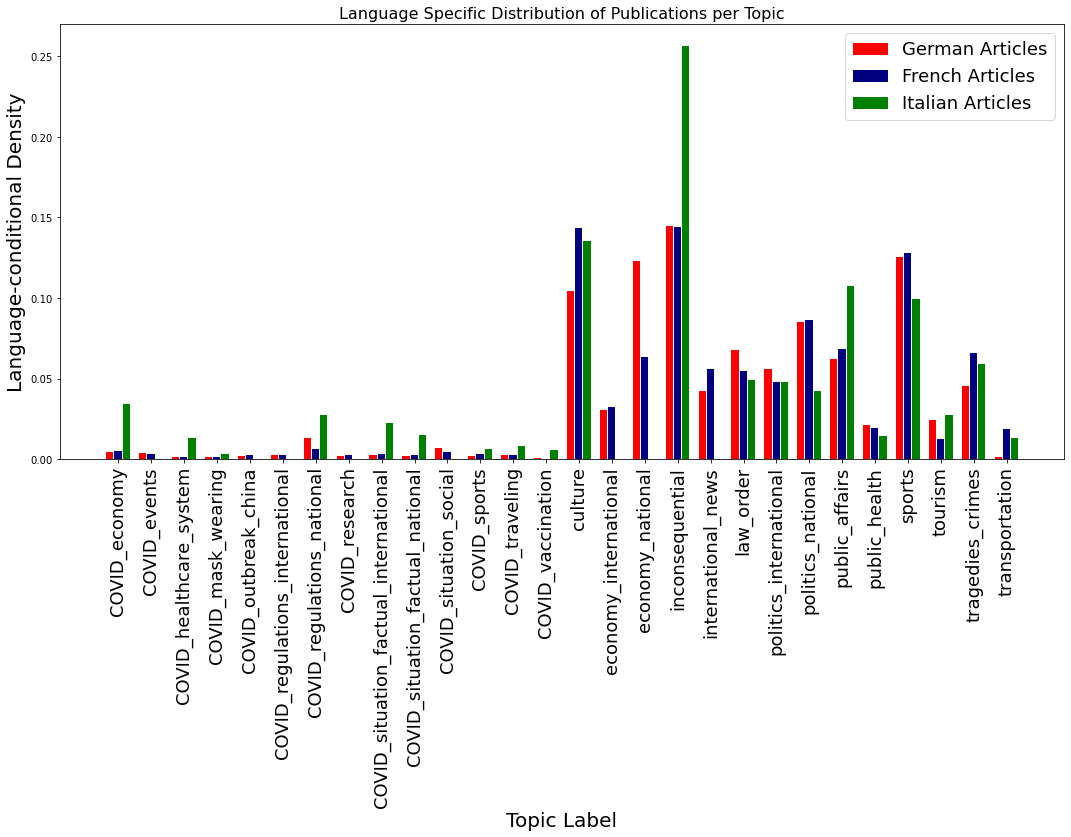

In [8]:
# Apply the above defined function to compare the language specific distribution of publications per topic
show_publ_dist_topics(articles)

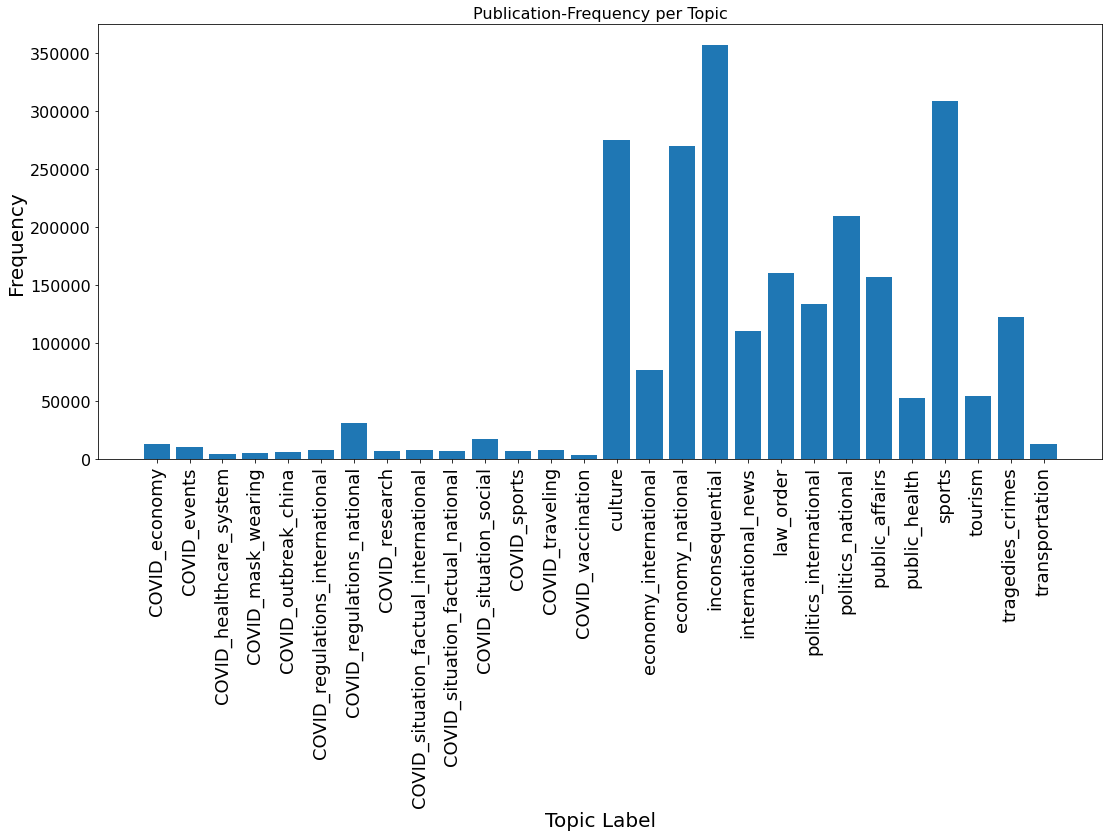

In [9]:
## Overall
# Apply the above defined function to show the overall distribution of publications per topic
show_publ_freq_topics_overall(articles)

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
1.1 Distribution of publications per topic (COVID topics)
</h3>
</div>

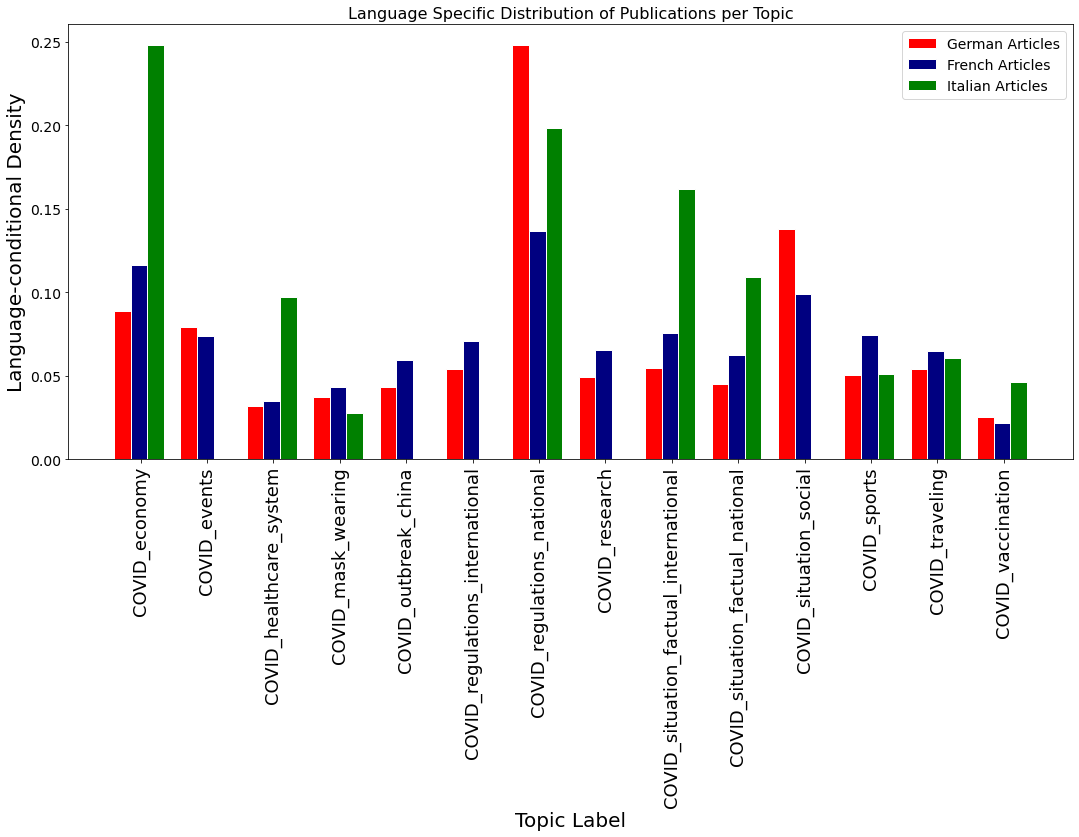

In [10]:
# Apply the above defined function to compare the language specific distribution of publications per COVID topic
show_publ_dist_COVID_topics(articles)

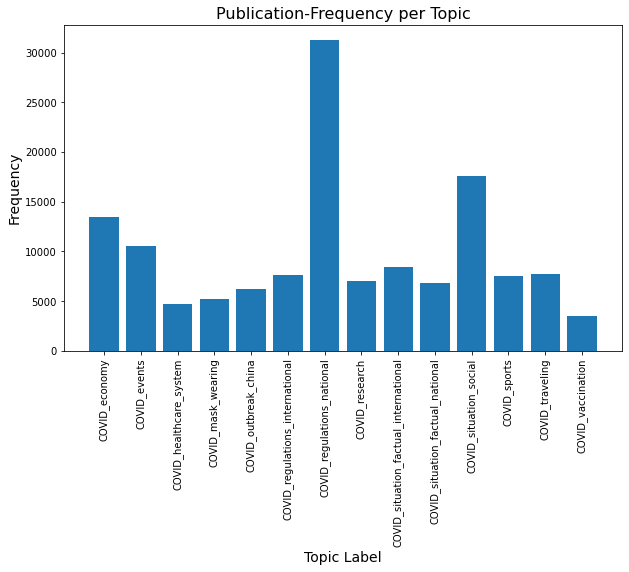

In [11]:
## Overall
# Apply the above defined function to show the overall distribution of publications per COVID topic
show_publ_freq_COVID_topics_overall(articles)

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
2. Topic specific EDA
</h2>
</div>

In [12]:
## Define all function needed subsequently
# Define a function to compare the topic specific average polarity of the articles per language
def compare_senti_by_topic_across_polarity_type(articles):
    # Get all topics
    topics = np.unique(articles['Topic_fine'])
    # Create an initial dataframe
    init_df = pd.DataFrame(index = topics.tolist())
    # Get the average polarity per Topic for the differenty Vader polarity types
    avg_1 = articles.groupby(['Topic_fine'])['Vader_polarity_adj'].mean()
    avg_2 = articles.groupby(['Topic_fine'])['Vader_polarity_adj_2'].mean()
    # Create a dataframe from these values
    avg_1 = pd.DataFrame(avg_1.values, index = avg_1.index, columns = ['values'])
    avg_2 = pd.DataFrame(avg_2.values, index = avg_2.index, columns = ['values'])
    # Create a dataframe containing the correct values for the visualization
    avg_1 = init_df.merge(avg_1, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    avg_2 = init_df.merge(avg_2, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    # Plot the topic specific average polarity of the articles per Vader polarity types
    fig = plt.figure(figsize = (18,8))
    # Set the width of the bars
    barwidth = 0.4
    # Set the position of the bars on the X-axis
    r1 = np.arange(len(topics))
    r2 = [x + barwidth for x in r1]
    #r3 = [x + barwidth for x in r2]
    # Make the plot
    plt.bar(r1, avg_1['values'].values, color = 'gray',     width = barwidth, edgecolor = 'white', label = 'Adjusted Vader Polarity')
    plt.bar(r2, avg_2['values'].values, color = 'seagreen', width = barwidth, edgecolor = 'white', label = 'Adjusted Vader Polarity II')
    # Add ticks
    plt.xlabel('Topic Label', fontsize = 20)
    plt.xticks([r + 1.1*barwidth for r in range(len(topics))], avg_1.index.to_list(), rotation = 'vertical', fontsize = 18)
    plt.ylabel('Average Polarity Score', fontsize = 20)
    plt.tick_params(axis = 'y', labelsize = 16)
    # Add title
    plt.title('Average Polarity by Topic')
    # Create legend & Show graphic
    plt.legend(fontsize = 16)
    plt.show()
    

# Define a function to compare the topic specific average polarity of the articles per language (ADJUSTED)
def compare_senti_by_topic_across_language(articles, polarity_type = 'Vader_polarity_adj'):
    # Get all topics
    topics = np.unique(articles['Topic_fine'])
    # Create an initial dataframe
    init_df = pd.DataFrame(index = topics.tolist())
    # Get the average polarity per Topic for the language specific articles
    avg_de = articles.loc[articles['language'] == 'de'].groupby(['Topic_fine'])[polarity_type].mean()
    avg_fr = articles.loc[articles['language'] == 'fr'].groupby(['Topic_fine'])[polarity_type].mean()
    avg_it = articles.loc[articles['language'] == 'it'].groupby(['Topic_fine'])[polarity_type].mean()
    # Create a dataframe from these values
    avg_de = pd.DataFrame(avg_de.values, index = avg_de.index, columns = ['values'])
    avg_fr = pd.DataFrame(avg_fr.values, index = avg_fr.index, columns = ['values'])
    avg_it = pd.DataFrame(avg_it.values, index = avg_it.index, columns = ['values'])
    # Create a dataframe containing the correct values for the visualization
    avg_de = init_df.merge(avg_de, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    avg_fr = init_df.merge(avg_fr, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    avg_it = init_df.merge(avg_it, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    # Plot the topic specific average polarity of the articles per language
    fig = plt.figure(figsize = (18,8))
    # Set the width of the bars
    barwidth = 0.25
    # Set the position of the bars on the X-axis
    r1 = np.arange(len(topics))
    r2 = [x + barwidth for x in r1]
    r3 = [x + barwidth for x in r2]
    # Make the plot
    plt.bar(r1, avg_de['values'].values, color = 'red',   width = barwidth, edgecolor = 'white', label = 'German Articles')
    plt.bar(r2, avg_fr['values'].values, color = 'navy',  width = barwidth, edgecolor = 'white', label = 'French Articles')
    plt.bar(r3, avg_it['values'].values, color = 'green', width = barwidth, edgecolor = 'white', label = 'Italian Articles')
    # Add ticks
    plt.xlabel('Topic Label')
    plt.xticks([r + 1.1*barwidth for r in range(len(topics))], avg_de.index.to_list(), rotation = 'vertical')
    plt.ylabel('Language-conditional average Polarity Score')
    # Add title
    plt.title('Language Specific Average Polarity by Topic')
    # Create legend & Show graphic
    plt.legend()
    plt.show()

# Define a function to compare the COVID topic specific average polarity of the articles per language
def compare_senti_by_COVID_topic_across_language(articles, polarity_type = 'Vader_polarity_adj'):
    # Get all COVID topics
    topics = np.unique(articles.loc[articles['Topic_fine'].isin(covid_topics), 'Topic_fine'])
    # Create an initial dataframe
    init_df = pd.DataFrame(index = topics.tolist())
    # Get the average polarity per Topic for the language specific articles
    avg_de = articles.loc[np.logical_and(articles['Topic_fine'].isin(covid_topics), articles['language'] == 'de')].groupby(['Topic_fine'])[polarity_type].mean()
    avg_fr = articles.loc[np.logical_and(articles['Topic_fine'].isin(covid_topics), articles['language'] == 'fr')].groupby(['Topic_fine'])[polarity_type].mean()
    avg_it = articles.loc[np.logical_and(articles['Topic_fine'].isin(covid_topics), articles['language'] == 'it')].groupby(['Topic_fine'])[polarity_type].mean()
    # Create a dataframe from these values
    avg_de = pd.DataFrame(avg_de.values, index = avg_de.index, columns = ['values'])
    avg_fr = pd.DataFrame(avg_fr.values, index = avg_fr.index, columns = ['values'])
    avg_it = pd.DataFrame(avg_it.values, index = avg_it.index, columns = ['values'])
    # Create a dataframe containing the correct values for the visualization
    avg_de = init_df.merge(avg_de, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    avg_fr = init_df.merge(avg_fr, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    avg_it = init_df.merge(avg_it, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    # Plot the topic specific average polarity of the articles per language
    fig = plt.figure(figsize = (18,8))
    # Set the width of the bars
    barwidth = 0.25
    # Set the position of the bars on the X-axis
    r1 = np.arange(len(topics))
    r2 = [x + barwidth for x in r1]
    r3 = [x + barwidth for x in r2]
    # Make the plot
    plt.bar(r1, avg_de['values'].values, color = 'red',   width = barwidth, edgecolor = 'white', label = 'German Articles')
    plt.bar(r2, avg_fr['values'].values, color = 'navy',  width = barwidth, edgecolor = 'white', label = 'French Articles')
    plt.bar(r3, avg_it['values'].values, color = 'green', width = barwidth, edgecolor = 'white', label = 'Italian Articles')
    # Add ticks
    plt.xlabel('Topic Label')
    plt.xticks([r + 1.1*barwidth for r in range(len(topics))], avg_de.index.to_list(), rotation = 'vertical')
    plt.ylabel('Language-conditional average Polarity Score')
    # Add title
    plt.title('Language Specific Average Polarity by Topic')
    # Create legend & Show graphic
    plt.legend()
    plt.show()


# Define a function to display the topic specific development of the articles' average sentiment over time
def show_senti_development(articles, topic, topic_fulltext, polarity_type = 'Vader_polarity_adj', weekly_mincount = 0, threshold = 0, date_min = None):
    # Get a list of boolean values indicating the selected articles
    selection = np.logical_and(articles['Topic_fine'] == topic, articles['Affiliation_Prob_fine'] >= threshold)
    # Extract the considered time frame
    if date_min == None:
        date_min = articles.loc[selection, 'publication_date'].min()
    else:
        date_min = pd.to_datetime(date_min, yearfirst = True)
    date_max = articles.loc[selection, 'publication_date'].max()

    # Get the average polarity scores for each year_week combination among the considered topic specific articles
    polarity_by_week = articles.loc[selection].groupby('year_week')[polarity_type].mean()
    # Get the number of published articles for each year_week combination among the considered topic specific articles
    counts_by_week   = articles.loc[selection].groupby('year_week')[polarity_type].count()
    # Create a dataframe containing the correct x and y coordinates to create the graph below
    polarity_by_week = pd.DataFrame(polarity_by_week.values, index = polarity_by_week.index, columns = ['values'])
    polarity_by_week['counts'] = counts_by_week.values
    polarity_by_week = pd.DataFrame(index = np.unique(articles.loc[np.logical_and(articles['publication_date'] >= date_min, articles['publication_date'] <= date_max), 'year_week'])).merge(
                                    polarity_by_week, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    polarity_by_week['x'] = np.arange(polarity_by_week.shape[0])
    polarity_by_week.dropna(inplace = True)
    # Filtering according to the chosen parameters
    polarity_by_week = polarity_by_week.loc[polarity_by_week['counts'] >= weekly_mincount]

    # Adjust the selection variable to the remaining timeframe
    selection = np.logical_and(selection, np.logical_and(articles['year_week'] >= polarity_by_week.index.min(), articles['year_week'] <= polarity_by_week.index.max()))

    # Get the average Swiss Stringency Index for each year_week combination of the language specific articles
    ch_stringency_by_week = articles.loc[np.logical_and(articles['publication_date'] >= date_min, articles['publication_date'] <= date_max)].groupby('year_week')['ch_stridx'].mean()
    # Create a dataframe containing the correct x and y coordinates to create the graph below
    ch_stringency_by_week = pd.DataFrame(ch_stringency_by_week.values, index = ch_stringency_by_week.index, columns = ['values']).sort_index()
    ch_stringency_by_week['x'] = np.arange(ch_stringency_by_week.shape[0])
    # Restrict the values to the considered timeframe
    ch_stringency_by_week = ch_stringency_by_week.loc[np.logical_and(ch_stringency_by_week.index >= polarity_by_week.index.min(), ch_stringency_by_week.index <= polarity_by_week.index.max())]

    # Show the development of the weekly average polarity scores of the topic specific articles
    fig, ax1 = plt.subplots(figsize = (10, 8))
    # Get readable labels and the according axis-ticks for the x-axis
    x_labels  = np.sort(articles.loc[np.logical_and(articles['year_week'] >= polarity_by_week.index.min(), articles['year_week'] <= polarity_by_week.index.max()), 'year_month'].unique())
    x_pos_min_frac = float(articles.loc[selection, 'publication_date'].min().strftime('%W'))/53*12
    x_pos_min_frac = x_pos_min_frac - int(x_pos_min_frac)
    x_pos_max_frac = float(articles.loc[selection, 'publication_date'].max().strftime('%W'))/53*12
    x_pos_max_frac = x_pos_max_frac - int(x_pos_max_frac)
    if np.logical_not(x_pos_min_frac == 0):
        x_labels = x_labels[1:]
        n_months = len(x_labels) - 1 + (1 - x_pos_min_frac) + x_pos_max_frac
        x_pos_min = polarity_by_week['x'].min() + ((polarity_by_week['x'].max() - polarity_by_week['x'].min())/n_months)*(1 - x_pos_min_frac)
    else:
        n_months = len(x_labels) - 1 + x_pos_max_frac
        x_pos_min = polarity_by_week['x'].min()
    x_pos_max = polarity_by_week['x'].max() - ((polarity_by_week['x'].max() - polarity_by_week['x'].min())/n_months)*x_pos_max_frac
    x_pos = np.linspace(x_pos_min, x_pos_max, len(x_labels))
    # Set up the plot to show the development of the articles' sentiment over time
    ax1.plot(polarity_by_week['x'].values, polarity_by_week['values'].values, color = 'blue', linewidth = 1, alpha = 1, linestyle = 'solid', label = 'Weekly Average Polarity Score')
    ax1.set_title("Average Sentiment of "+topic_fulltext+" Articles over Time")
    ax1.set_xlabel("Year-Month")
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(x_labels, rotation = 90, ha = 'center')
    ax1.set_ylabel("Polarity Score", color = 'blue')
    ax1.tick_params(axis = 'y', labelcolor = 'blue')
    ax1.spines['top'].set_visible(False)
    # Set up the plot to show the development of the Swiss National Covid-Stringency Index over time
    ax2 = ax1.twinx()
    ax2.plot(ch_stringency_by_week['x'].values, ch_stringency_by_week['values'].values, color = 'red', linewidth = 1, alpha = 0.9, linestyle = '--', label = 'Weekly Covid-Stringency Index of Switzerland')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(x_labels, rotation = 90, ha = 'center')
    ax2.set_ylabel('Swiss Covid Stringency Index', color = 'red')
    ax2.tick_params(axis = 'y', labelcolor = 'red')
    ax2.spines['top'].set_visible(False)
    # Create a legend and display the plot
    fig.legend()
    plt.show()

# Define a function to display the topic specific development of the weekly publication frequency over time
def show_publ_frequency_development(articles, topic, topic_fulltext, threshold = 0):
    # Get a list of boolean values indicating the selected articles
    selection = np.logical_and(articles['Topic_fine'] == topic, articles['Affiliation_Prob_fine'] >= threshold)
    # Extract the considered time frame
    date_min = articles.loc[selection, 'publication_date'].min()
    date_max = articles.loc[selection, 'publication_date'].max()

    # Get the number of published articles for each year_week combination among the considered topic specific articles
    counts_by_week   = articles.loc[selection].groupby('year_week')['Topic_fine'].count()
    # Create a dataframe containing the correct x and y coordinates to create the graph below
    counts_by_week = pd.DataFrame(counts_by_week.values, index = counts_by_week.index, columns = ['counts'])
    counts_by_week = pd.DataFrame(index = np.unique(articles.loc[np.logical_and(articles['publication_date'] >= date_min, articles['publication_date'] <= date_max), 'year_week'])).merge(
                                    counts_by_week, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    counts_by_week['x'] = np.arange(counts_by_week.shape[0])
    counts_by_week.dropna(inplace = True)

    # Get the average Swiss Stringency Index for each year_week combination of the language specific articles
    ch_stringency_by_week = articles.loc[np.logical_and(articles['publication_date'] >= date_min, articles['publication_date'] <= date_max)].groupby('year_week')['ch_stridx'].mean()
    # Create a dataframe containing the correct x and y coordinates to create the graph below
    ch_stringency_by_week = pd.DataFrame(ch_stringency_by_week.values, index = ch_stringency_by_week.index, columns = ['values']).sort_index()
    ch_stringency_by_week['x'] = np.arange(ch_stringency_by_week.shape[0])
    # Restrict the values to the considered timeframe
    ch_stringency_by_week = ch_stringency_by_week.loc[np.logical_and(ch_stringency_by_week.index >= counts_by_week.index.min(), ch_stringency_by_week.index <= counts_by_week.index.max())]

    # Show the development of the weekly average polarity scores of the topic specific articles
    fig, ax1 = plt.subplots(figsize = (10, 8))
    # Get readable labels and the according axis-ticks for the x-axis
    x_labels  = np.sort(articles.loc[np.logical_and(articles['publication_date'] >= date_min, articles['publication_date'] <= date_max), 'year_month'].unique())
    x_pos_min_frac = float(articles.loc[selection, 'publication_date'].min().strftime('%W'))/53*12
    x_pos_min_frac = x_pos_min_frac - int(x_pos_min_frac)
    x_pos_max_frac = float(articles.loc[selection, 'publication_date'].max().strftime('%W'))/53*12
    x_pos_max_frac = x_pos_max_frac - int(x_pos_max_frac)
    if np.logical_not(x_pos_min_frac == 0):
        x_labels = x_labels[1:]
        n_months = len(x_labels) - 1 + (1 - x_pos_min_frac) + x_pos_max_frac
        x_pos_min = counts_by_week['x'].min() + ((counts_by_week['x'].max() - counts_by_week['x'].min())/n_months)*(1 - x_pos_min_frac)
    else:
        n_months = len(x_labels) - 1 + x_pos_max_frac
        x_pos_min = counts_by_week['x'].min()
    x_pos_max = counts_by_week['x'].max() - ((counts_by_week['x'].max() - counts_by_week['x'].min())/n_months)*x_pos_max_frac
    x_pos = np.linspace(x_pos_min, x_pos_max, len(x_labels))
    # Set up the plot to show the development of the frequency of weekly published articles for the topic under consideration
    ax1.plot(counts_by_week['x'].values, counts_by_week['counts'].values, color = 'green', linewidth = 1, alpha = 1, linestyle = 'solid', label = 'Weekly published '+topic_fulltext+' Articles')
    ax1.set_title("Weekly Publication-Frequency of "+topic_fulltext+" Articles")
    ax1.set_xlabel("Year-Month")
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(x_labels, rotation = 90, ha = 'center')
    ax1.set_ylabel('Weekly Publication Frequency', color = 'green')
    ax1.tick_params(axis = 'y', labelcolor = 'green')
    ax1.spines['top'].set_visible(False)
    # Set up the plot to show the development of the Swiss National Covid-Stringency Index over time
    ax2 = ax1.twinx()
    ax2.plot(ch_stringency_by_week['x'].values, ch_stringency_by_week['values'].values, color = 'red', linewidth = 1, alpha = 0.9, linestyle = '--', label = 'Weekly Covid-Stringency Index of Switzerland')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(x_labels, rotation = 90, ha = 'center')
    ax2.set_ylabel('Swiss Covid Stringency Index', color = 'red')
    ax2.tick_params(axis = 'y', labelcolor = 'red')
    ax2.spines['top'].set_visible(False)

    # Create a legend and display the plot
    fig.legend()
    plt.show()

# Define a function to display and compare the COVID topic specific frequency of the monthly published articles
def compare_publ_frequency_development_across_COVID_topics_monthly(articles):
    # Get the average polarity scores for each year_week combination of the topic specific articles
    counts_by_month = []
    for topic in np.sort(articles.loc[articles['Topic_fine'].isin(covid_topics), 'Topic_fine'].unique()):
        counts_by_month.append(articles.loc[articles['Topic_fine'] == topic].groupby('year_month')['Topic_fine'].count())

    # Get the average Swiss Stringency Index for each year_week combination
    ch_stringency_by_month = articles.groupby('year_month')['ch_stridx'].mean()

    # Show the development of the weekly average polarity scores of the language specific articles
    fig, ax1 = plt.subplots(figsize = (12, 11))
    # Get readable labels and the according axis-ticks for the x-axis
    x_labels = np.sort(articles['year_month'].unique())
    x_pos    = np.arange(len(x_labels))
    # Define the color palette to be used
    colors = ['navy','dodgerblue','cyan','teal','lime','green','olive','black','magenta','crimson','darkorange','gold','sienna','lightcoral','grey']
    # Set up the plot to show the development of the articles' sentiment over time
    i = 0
    for topic in np.sort(articles.loc[articles['Topic_fine'].isin(covid_topics), 'Topic_fine'].unique()):
        ax1.plot(counts_by_month[i].index, counts_by_month[i].values, color = colors[i], linewidth = 1.5, alpha = 0.8, linestyle = 'solid', label = topic)
        i += 1
    ax1.set_title("Development of the Monthly Publication Frequency over Time by Topic")
    ax1.set_xlabel("Year-Month")
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(x_labels, rotation = 90, ha = 'center')
    ax1.set_ylabel("Monthly Publication Frequency", color = 'black')
    ax1.tick_params(axis = 'y', labelcolor = 'black')
    ax1.spines['top'].set_visible(False)
    # Set up the plot to show the development of the Swiss National Covid-Stringency Index over time
    ax2 = ax1.twinx()
    ax2.plot(ch_stringency_by_month.index, ch_stringency_by_month.values, color = 'red', linewidth = 2, alpha = 1, linestyle = '--', label = 'CH Covid-Stringency Index')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(x_labels, rotation = 90, ha = 'center')
    ax2.set_ylabel('Swiss Covid Stringency Index', color = 'red')
    ax2.tick_params(axis = 'y', labelcolor = 'red')
    ax2.spines['top'].set_visible(False)
    # Create a legend and display the plot
    fig.legend(ncol = 4)
    plt.show()


# Define a function to display and compare the COVID topic specific development of the articles' sentiment over time
def compare_senti_development_across_COVID_topics_monthly(articles, polarity_type = 'Vader_polarity_adj', date_min = None):
    # Define the starting date of the time frame to consider
    if date_min == None:
        date_min = articles['publication_date'].min()
    else:
        date_min = pd.to_datetime(date_min, yearfirst = True)

    # Get the average polarity scores for each year_week combination of the topic specific articles
    polarity_by_month = []
    for topic in np.sort(articles.loc[articles['Topic_fine'].isin(covid_topics), 'Topic_fine'].unique()):
        polarity_by_month.append(articles.loc[np.logical_and(articles['publication_date'] >= date_min, articles['Topic_fine'] == topic)].groupby('year_month')[polarity_type].mean())

    # Get the average Swiss Stringency Index for each year_week combination
    ch_stringency_by_month = articles.loc[articles['publication_date'] >= date_min].groupby('year_month')['ch_stridx'].mean()

    # Show the development of the weekly average polarity scores of the language specific articles
    fig, ax1 = plt.subplots(figsize = (12, 11))
    # Get readable labels and the according axis-ticks for the x-axis
    x_labels = np.sort(articles.loc[articles['publication_date'] >= date_min, 'year_month'].unique())
    x_pos    = np.arange(len(x_labels))
    # Define the color palette to be used
    colors = ['navy','dodgerblue','cyan','teal','lime','green','olive','black','magenta','crimson','darkorange','gold','sienna','lightcoral','grey']
    # Set up the plot to show the development of the articles' sentiment over time
    i = 0
    for topic in np.sort(articles.loc[articles['Topic_fine'].isin(covid_topics), 'Topic_fine'].unique()):
        ax1.plot(polarity_by_month[i].index, polarity_by_month[i].values, color = colors[i], linewidth = 1.5, alpha = 0.8, linestyle = 'solid', label = topic)
        i += 1
    ax1.set_title("Development of the Articles' average Sentiment over Time by Topic")
    ax1.set_xlabel("Year-Month")
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(x_labels, rotation = 90, ha = 'center')
    ax1.set_ylabel("Polarity Score", color = 'black')
    ax1.tick_params(axis = 'y', labelcolor = 'black')
    ax1.spines['top'].set_visible(False)
    # Set up the plot to show the development of the Swiss National Covid-Stringency Index over time
    ax2 = ax1.twinx()
    ax2.plot(ch_stringency_by_month.index, ch_stringency_by_month.values, color = 'red', linewidth = 2, alpha = 1, linestyle = '--', label = 'CH Covid-Stringency Index')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(x_labels, rotation = 90, ha = 'center')
    ax2.set_ylabel('Swiss Covid Stringency Index', color = 'red')
    ax2.tick_params(axis = 'y', labelcolor = 'red')
    ax2.spines['top'].set_visible(False)
    # Create a legend and display the plot
    fig.legend(ncol = 4)
    plt.show()

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
2.1.1 Average polarity by topic (all topics)
</h3>
</div>

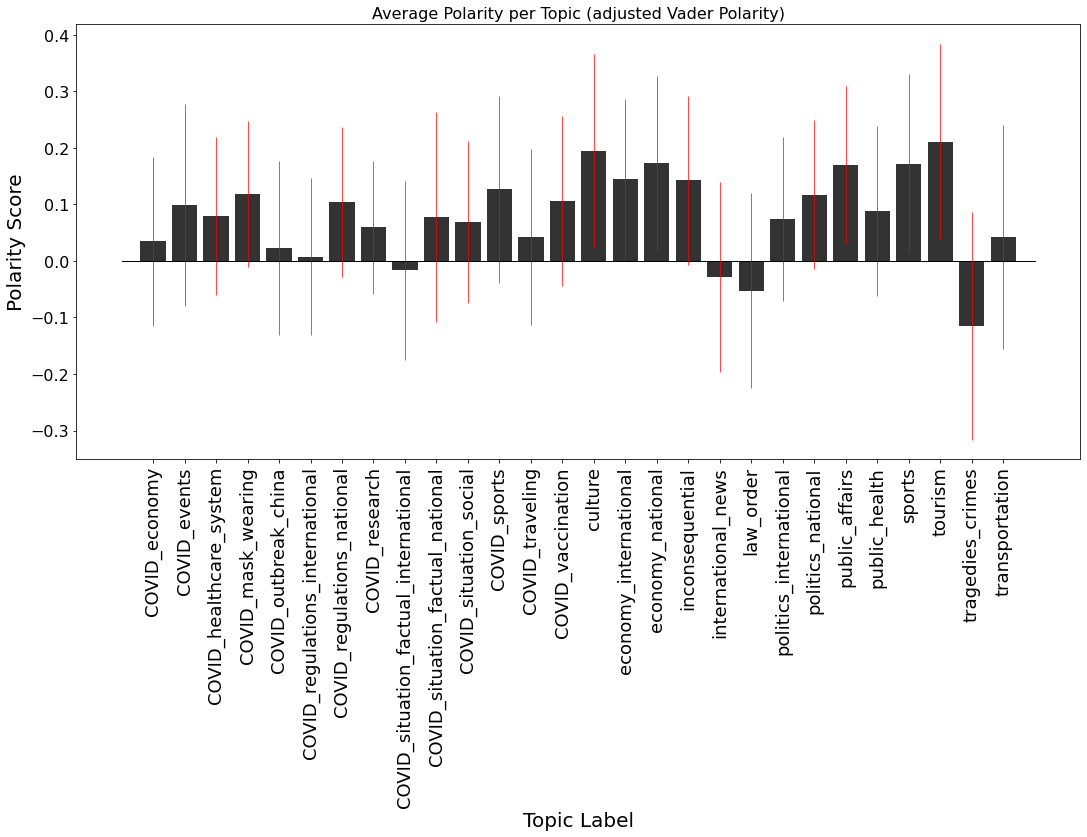

In [13]:
## Display the average Vader polarity per topic together with the standard deviation (using VPA)
# Get the average Vader polarity per topic
avg_pol_by_topic = articles.groupby('Topic_fine')['Vader_polarity_adj'].mean()
std_pol_by_topic = articles.groupby('Topic_fine')['Vader_polarity_adj'].std()
# Plot the average Vader polarity per topic
fig = plt.figure(figsize = (18,8))
ax = fig.add_subplot(111)
x_pos = np.arange(len(avg_pol_by_topic.index))
ax.bar(x_pos, avg_pol_by_topic.values, yerr = std_pol_by_topic.values, align = 'center', color = 'black', alpha = 0.8, ecolor = 'red', error_kw = {'lw': 0.7})
ax.plot([min(x_pos)-1,max(x_pos)+1], [0,0], color = 'black', linewidth = 1)
ax.set_xticks(x_pos)
ax.set_xticklabels(avg_pol_by_topic.index, rotation = 90, ha = 'center', fontsize = 18)
ax.set_title('Average Polarity per Topic (adjusted Vader Polarity)')
ax.set_xlabel('Topic Label', fontsize = 20)
ax.set_ylabel('Polarity Score', fontsize = 20)
ax.tick_params(axis = 'y', labelsize = 16)
# Display the plot
plt.show()

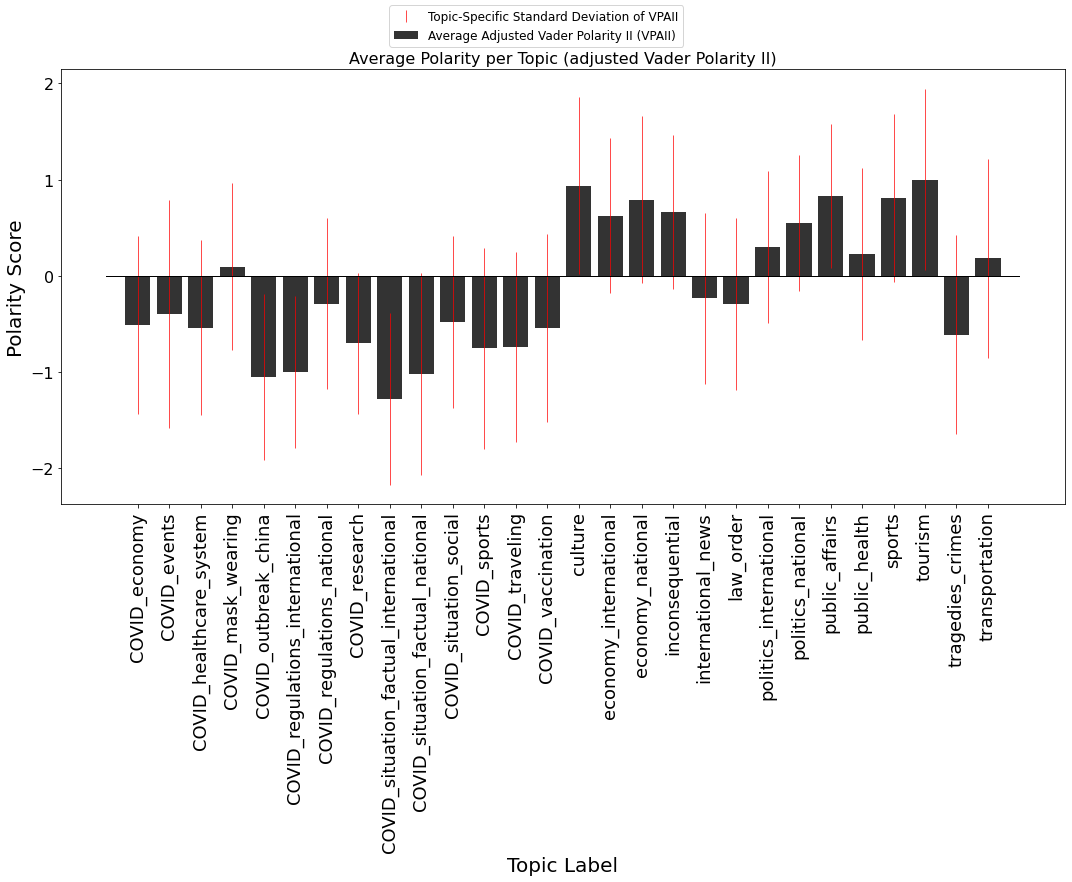

In [14]:
## 1 Display the average Vader polarity per topic together with the standard deviation (using rescaled VPAII)
# Get the average Vader polarity per topic
avg_pol_by_topic = articles.groupby('Topic_fine')['Vader_polarity_adj_2_rsc'].mean()
std_pol_by_topic = articles.groupby('Topic_fine')['Vader_polarity_adj_2_rsc'].std()
# Plot the average Vader polarity per topic
fig = plt.figure(figsize = (18,8))
ax = fig.add_subplot(111)
x_pos = np.arange(len(avg_pol_by_topic.index))
ax.bar(x_pos, avg_pol_by_topic.values, yerr = std_pol_by_topic.values, align = 'center', color = 'black', alpha = 0.8, ecolor = 'red', 
        error_kw = {'lw': 0.7, 'label': 'Topic-Specific Standard Deviation of VPAII'}, label = 'Average Adjusted Vader Polarity II (VPAII)')
ax.plot([min(x_pos)-1,max(x_pos)+1], [0,0], color = 'black', linewidth = 1)
ax.set_xticks(x_pos)
ax.set_xticklabels(avg_pol_by_topic.index, rotation = 90, ha = 'center', fontsize = 18)
ax.set_title('Average Polarity per Topic (adjusted Vader Polarity II)')
ax.set_xlabel('Topic Label', fontsize = 20)
ax.set_ylabel('Polarity Score', fontsize = 20)
ax.tick_params(axis = 'y', labelsize = 16)
# Display the plot
fig.legend(loc = 'best', fontsize = 12)
plt.show()

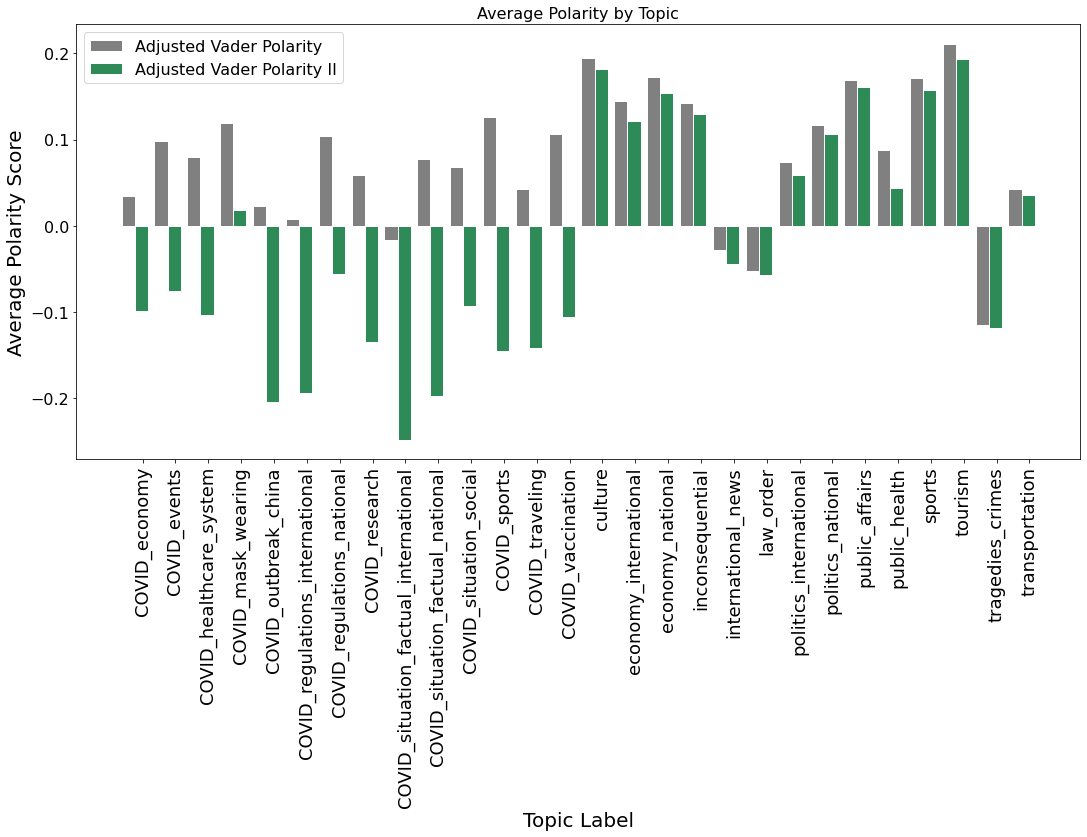

In [15]:
# Apply the above defined function to compare the topic specific average polarity of the articles among the different adjusted Vader polarity types
compare_senti_by_topic_across_polarity_type(articles)

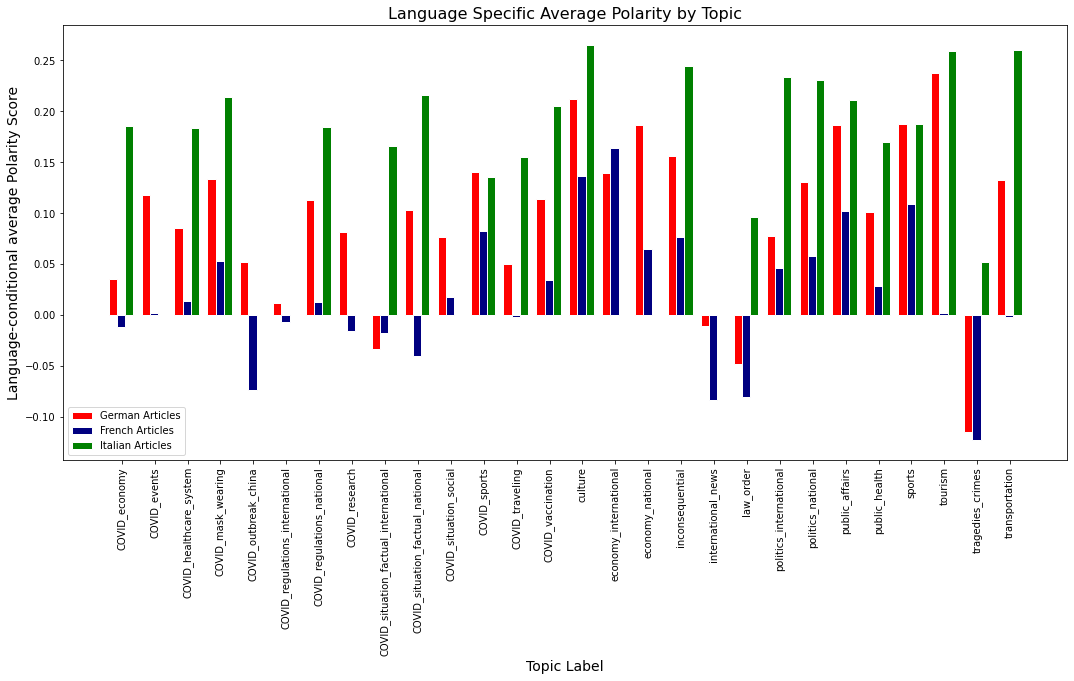

In [16]:
# Apply the above defined function to compare the topic specific average polarity of the articles per language (using the VPA)
compare_senti_by_topic_across_language(articles, polarity_type = 'Vader_polarity_adj')

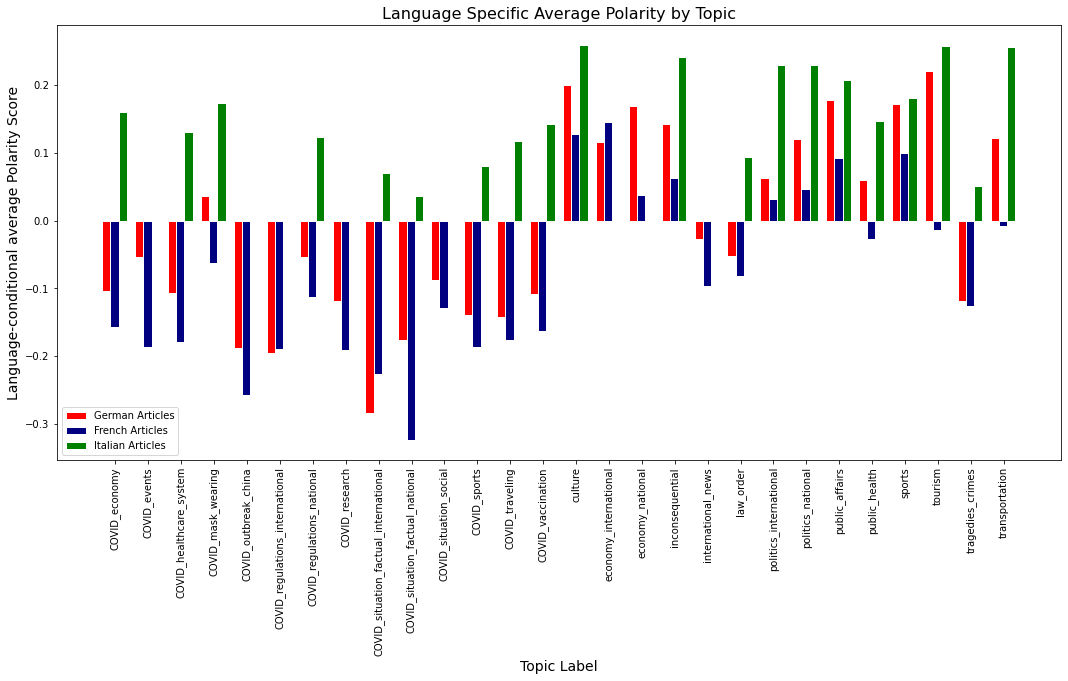

In [17]:
# Apply the above defined function to compare the topic specific average polarity of the articles per language (using the VPAII)
compare_senti_by_topic_across_language(articles, polarity_type = 'Vader_polarity_adj_2')

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
2.1.2 Average polarity by topic (COVID topics)
</h3>
</div>

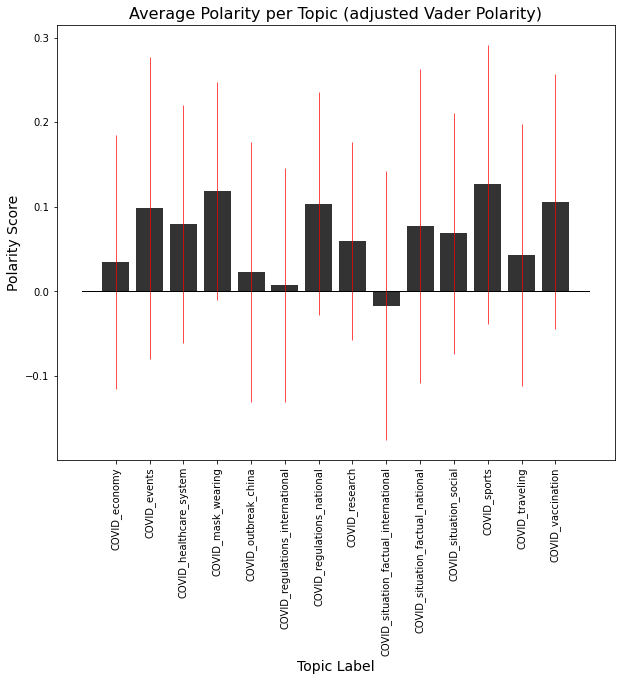

In [18]:
## Display the average Vader polarity per COVID topic together with the standard deviation (using VPA)
# Get the average Vader polarity per topic
avg_pol_by_topic = articles.loc[articles['Topic_fine'].isin(covid_topics)].groupby('Topic_fine')['Vader_polarity_adj'].mean()
std_pol_by_topic = articles.loc[articles['Topic_fine'].isin(covid_topics)].groupby('Topic_fine')['Vader_polarity_adj'].std()
# Plot the average Vader polarity per topic
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
x_pos = np.arange(len(avg_pol_by_topic.index))
ax.bar(x_pos, avg_pol_by_topic.values, yerr = std_pol_by_topic.values, align = 'center', color = 'black', alpha = 0.8, ecolor = 'red', error_kw = {'lw': 0.7})
ax.plot([min(x_pos)-1,max(x_pos)+1], [0,0], color = 'black', linewidth = 1)
ax.set_xticks(x_pos)
ax.set_xticklabels(avg_pol_by_topic.index, rotation = 90, ha = 'center')
ax.set_title('Average Polarity per Topic (adjusted Vader Polarity)')
ax.set_xlabel('Topic Label')
ax.set_ylabel('Polarity Score')
# Display the plot
plt.show()

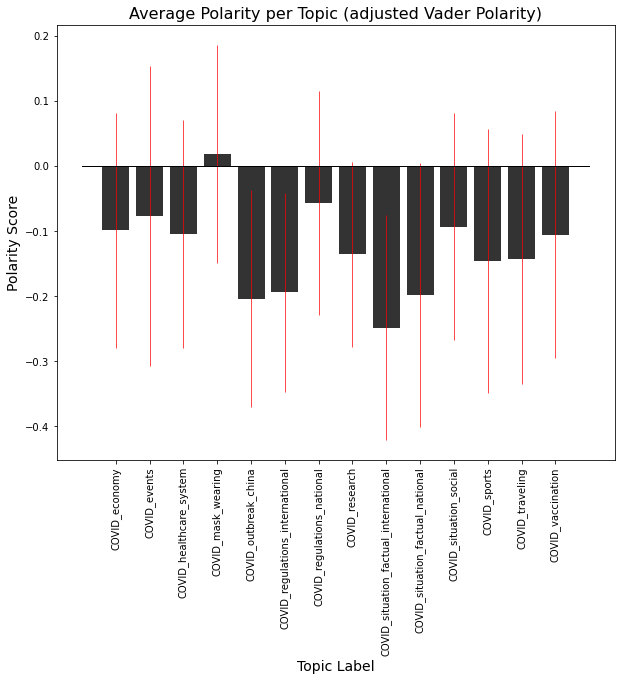

In [19]:
## Display the average Vader polarity per COVID topic together with the standard deviation (using VPAII)
# Get the average Vader polarity per topic
avg_pol_by_topic = articles.loc[articles['Topic_fine'].isin(covid_topics)].groupby('Topic_fine')['Vader_polarity_adj_2'].mean()
std_pol_by_topic = articles.loc[articles['Topic_fine'].isin(covid_topics)].groupby('Topic_fine')['Vader_polarity_adj_2'].std()
# Plot the average Vader polarity per topic
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
x_pos = np.arange(len(avg_pol_by_topic.index))
ax.bar(x_pos, avg_pol_by_topic.values, yerr = std_pol_by_topic.values, align = 'center', color = 'black', alpha = 0.8, ecolor = 'red', error_kw = {'lw': 0.7})
ax.plot([min(x_pos)-1,max(x_pos)+1], [0,0], color = 'black', linewidth = 1)
ax.set_xticks(x_pos)
ax.set_xticklabels(avg_pol_by_topic.index, rotation = 90, ha = 'center')
ax.set_title('Average Polarity per Topic (adjusted Vader Polarity)')
ax.set_xlabel('Topic Label')
ax.set_ylabel('Polarity Score')
# Display the plot
plt.show()

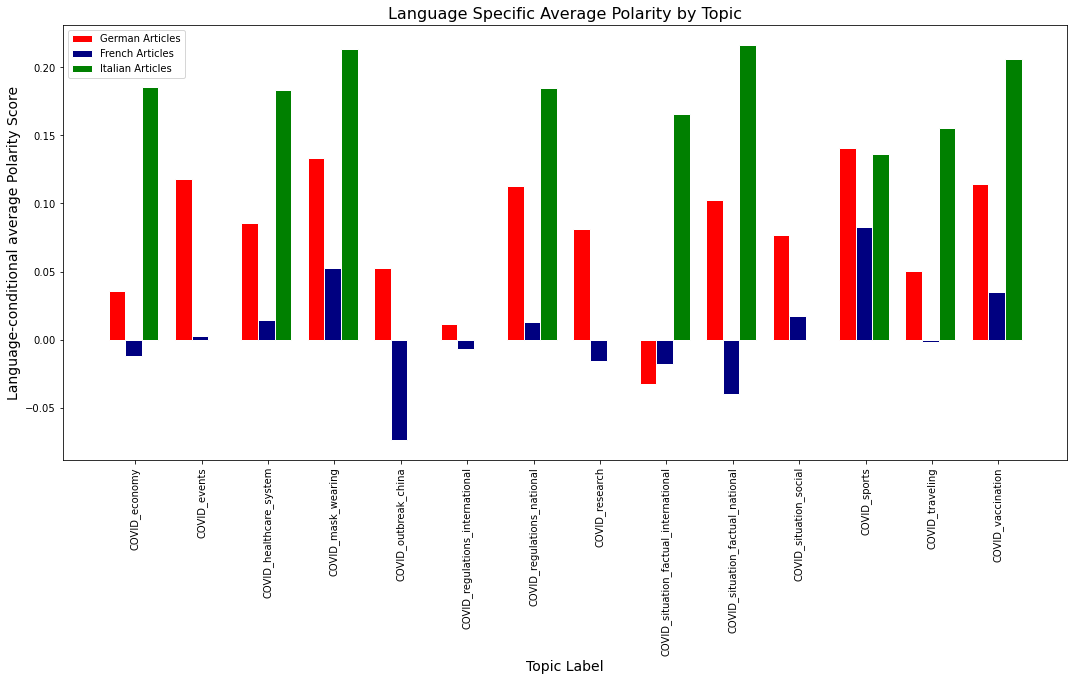

In [20]:
# Apply the above defined function to compare the COVID topic specific average polarity of the articles per language (using the VPA)
compare_senti_by_COVID_topic_across_language(articles, polarity_type = 'Vader_polarity_adj')

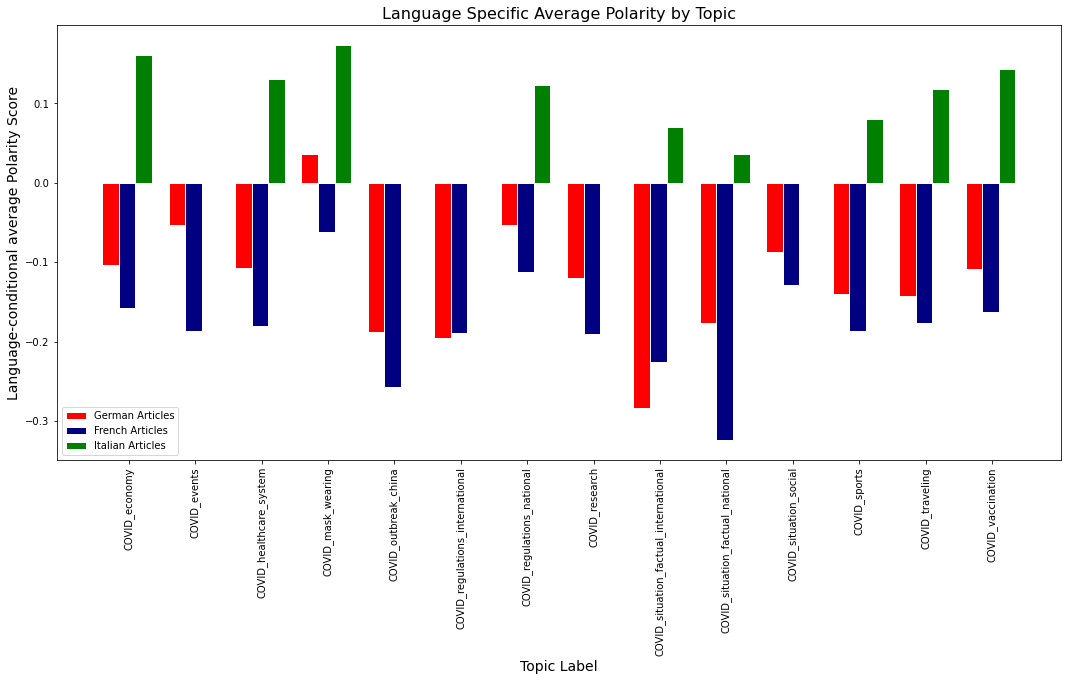

In [21]:
# Apply the above defined function to compare the COVID topic specific average polarity of the articles per language (using the VPAII)
compare_senti_by_COVID_topic_across_language(articles, polarity_type = 'Vader_polarity_adj_2')

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
2.2 Development of the publication frequency over time (COVID topics)
</h3>
</div>

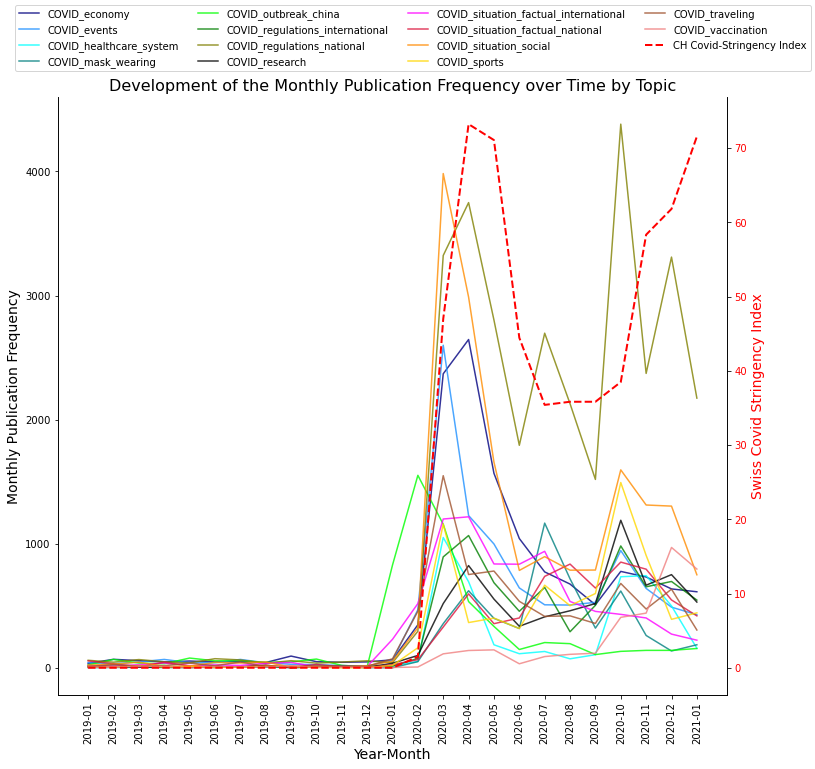

In [22]:
# Display and compare the COVID topic specific development of the monthly publication frequency over time
compare_publ_frequency_development_across_COVID_topics_monthly(articles)

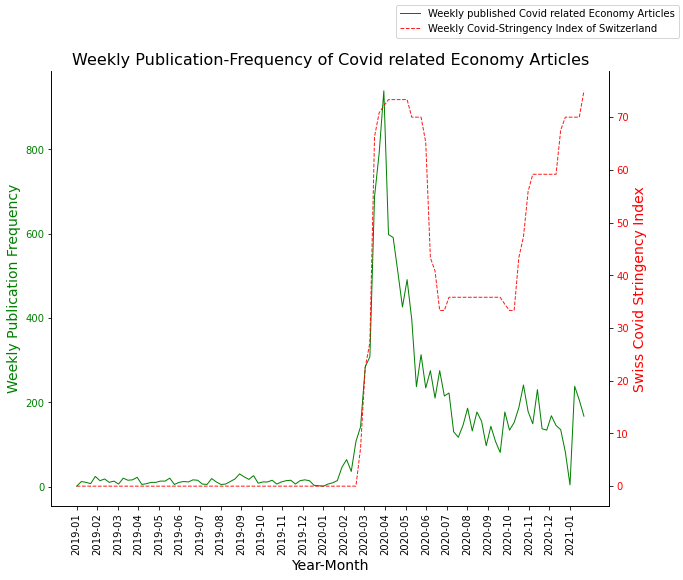

In [23]:
# COVID_economy articles frequency
show_publ_frequency_development(articles, 'COVID_economy', 'Covid related Economy')

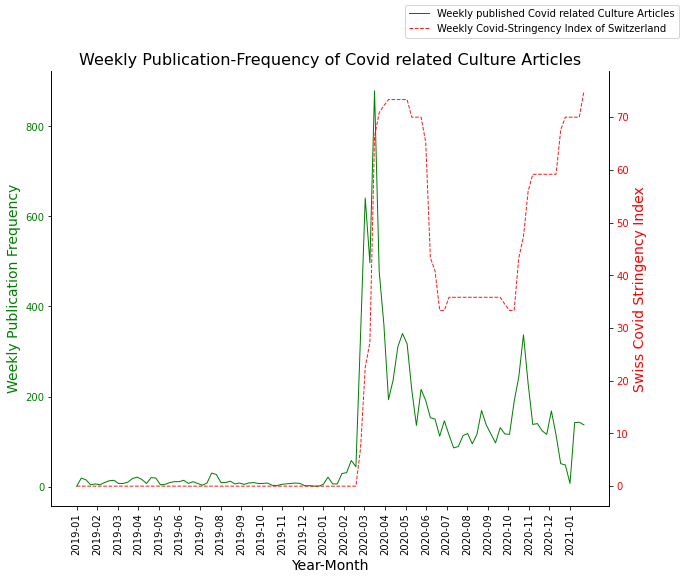

In [24]:
# COVID_events articles frequency
show_publ_frequency_development(articles, 'COVID_events', 'Covid related Culture')

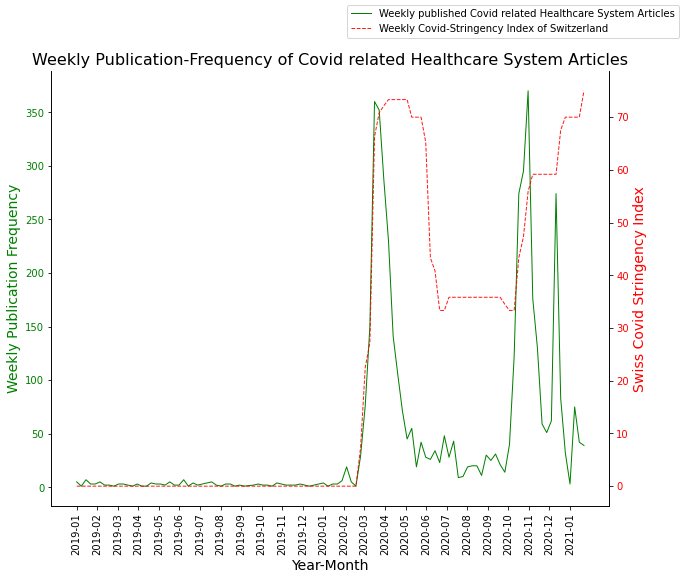

In [25]:
# COVID_healthcare_system articles frequency
show_publ_frequency_development(articles, 'COVID_healthcare_system', 'Covid related Healthcare System')

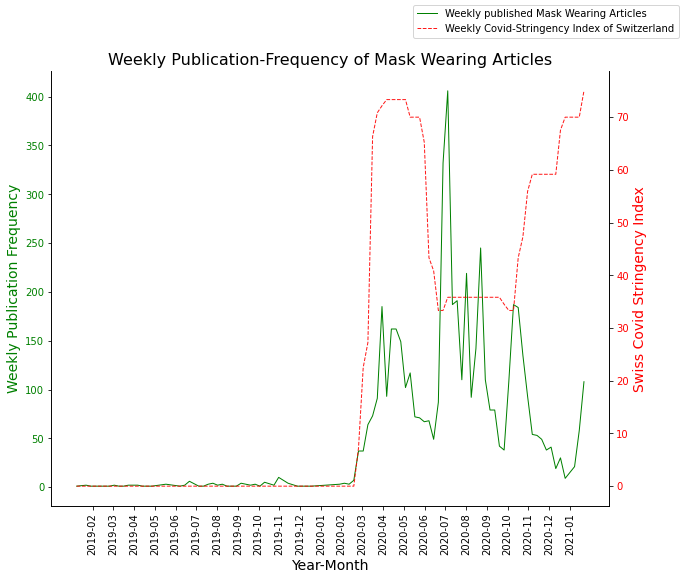

In [26]:
# COVID_mask_wearing articles frequency
show_publ_frequency_development(articles, 'COVID_mask_wearing', 'Mask Wearing')

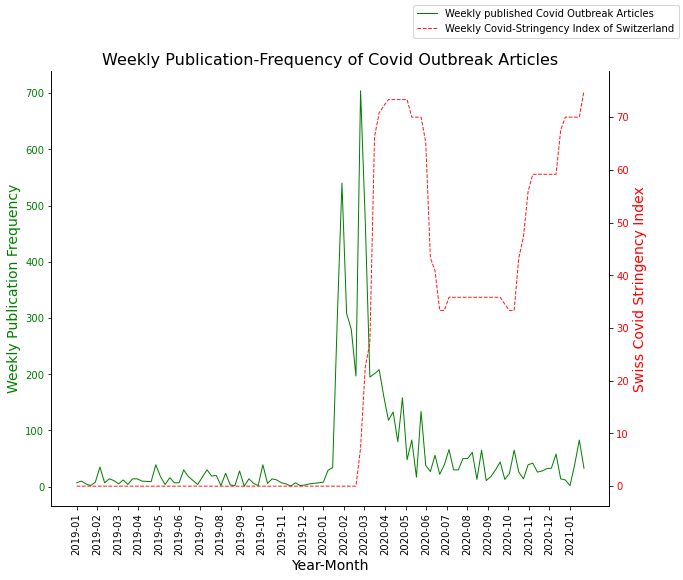

In [27]:
# COVID_outbreak_china articles frequency
show_publ_frequency_development(articles, 'COVID_outbreak_china', 'Covid Outbreak')

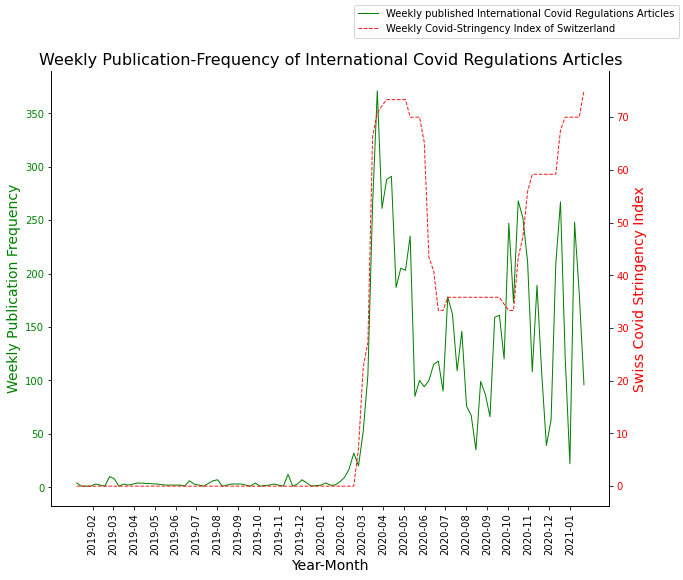

In [28]:
# COVID_regulations_international articles frequency
show_publ_frequency_development(articles, 'COVID_regulations_international', 'International Covid Regulations')

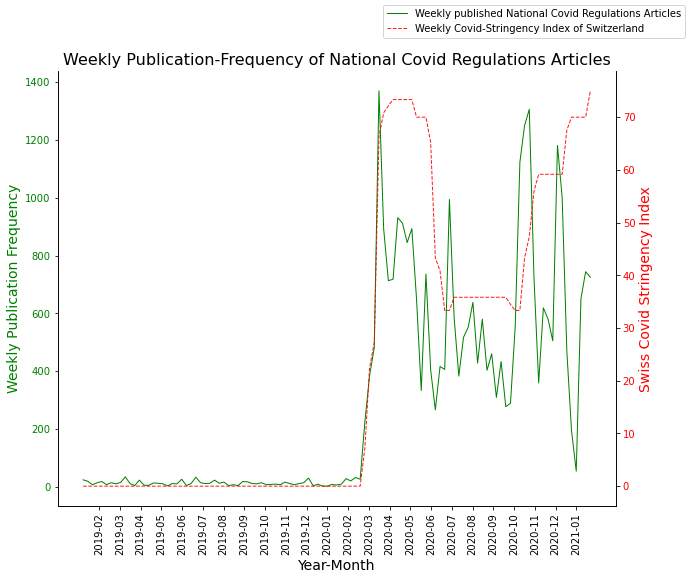

In [29]:
# COVID_regulations_national articles frequency
show_publ_frequency_development(articles, 'COVID_regulations_national', 'National Covid Regulations')

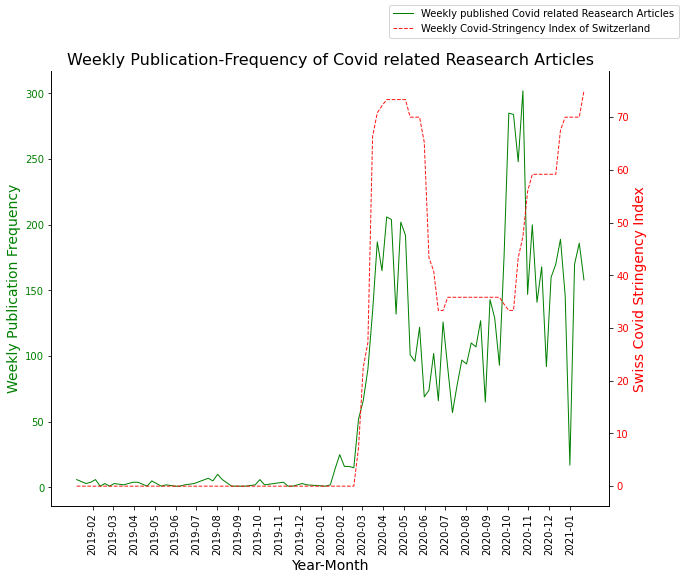

In [30]:
# COVID_research articles frequency
show_publ_frequency_development(articles, 'COVID_research', 'Covid related Reasearch')

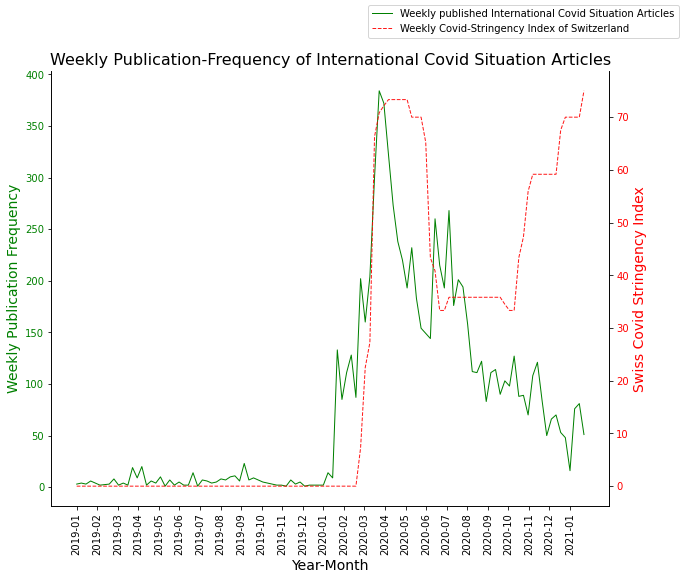

In [31]:
# COVID_situation_factual_international articles frequency
show_publ_frequency_development(articles, 'COVID_situation_factual_international', 'International Covid Situation')

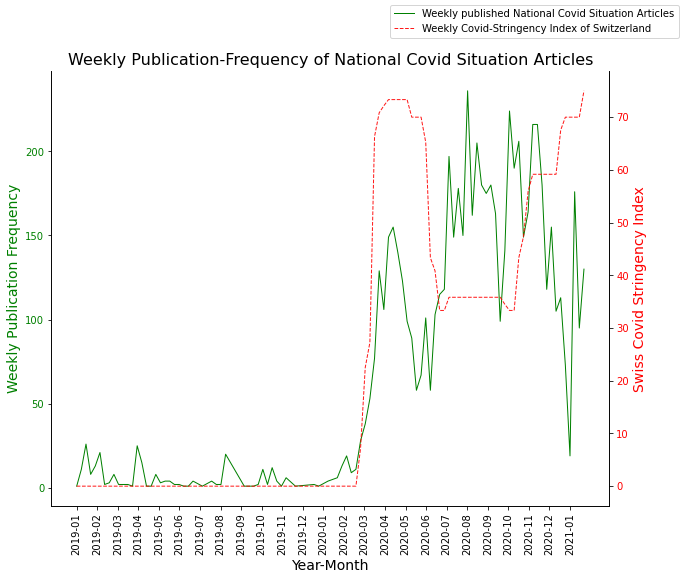

In [32]:
# COVID_situation_factual_national articles frequency
show_publ_frequency_development(articles, 'COVID_situation_factual_national', 'National Covid Situation')

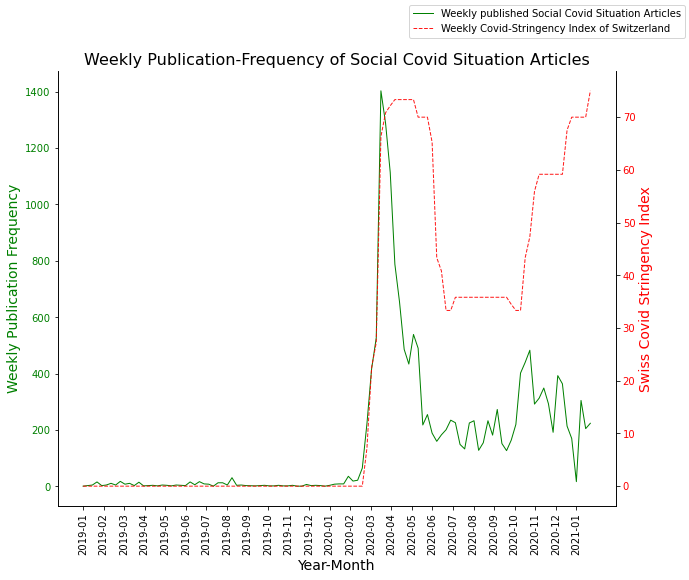

In [33]:
# COVID_situation_social articles frequency
show_publ_frequency_development(articles, 'COVID_situation_social', 'Social Covid Situation')

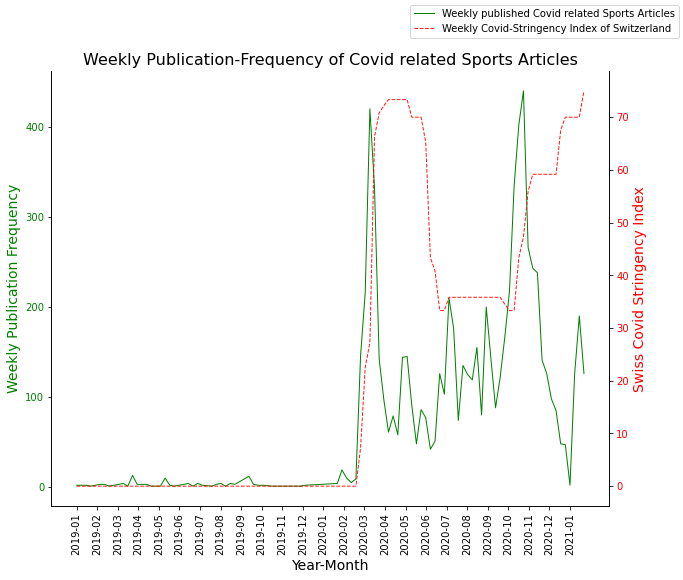

In [34]:
# COVID_sports articles frequency
show_publ_frequency_development(articles, 'COVID_sports', 'Covid related Sports')

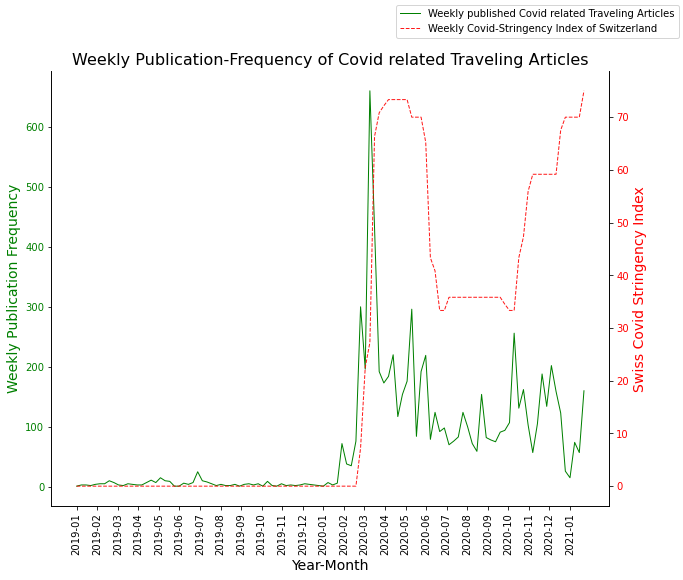

In [35]:
# COVID_traveling articles frequency
show_publ_frequency_development(articles, 'COVID_traveling', 'Covid related Traveling')

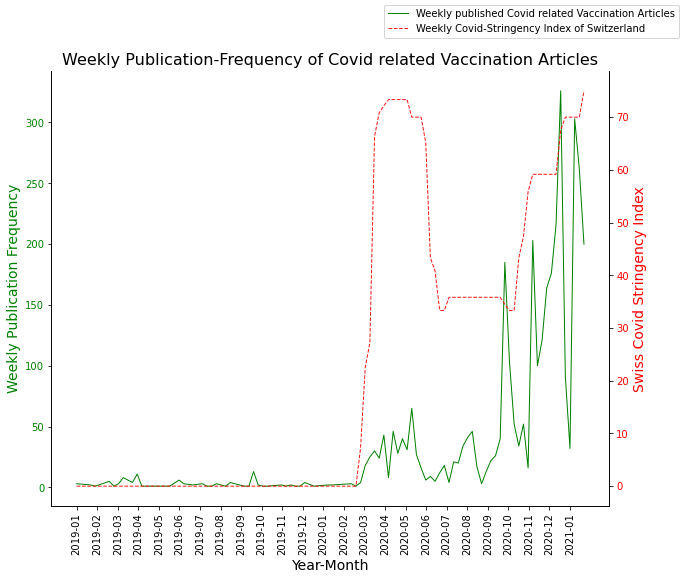

In [36]:
# COVID_vaccination articles frequency
show_publ_frequency_development(articles, 'COVID_vaccination', 'Covid related Vaccination')

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
2.3 Development of the polarity over time
</h3>
</div>

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
2.3.1 COVID topics
</h3>
</div>

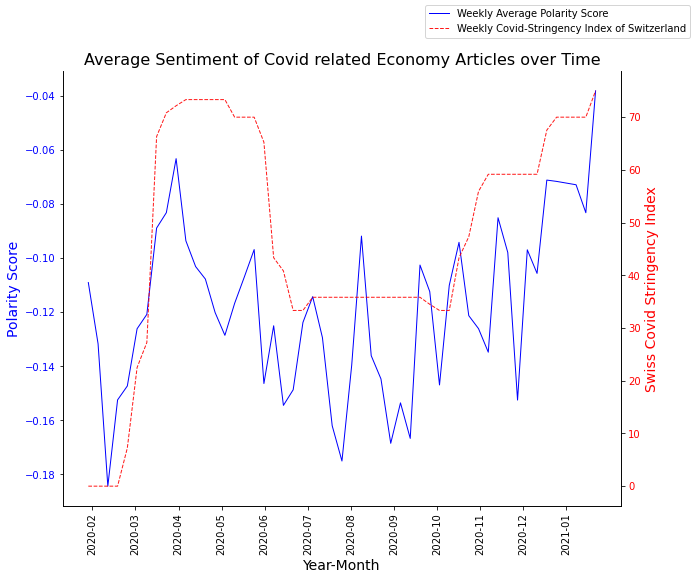

In [37]:
# COVID_economy
show_senti_development(articles, 'COVID_economy', 'Covid related Economy', polarity_type = "Vader_polarity_adj_2", weekly_mincount = 20, date_min = '2020-01-01')

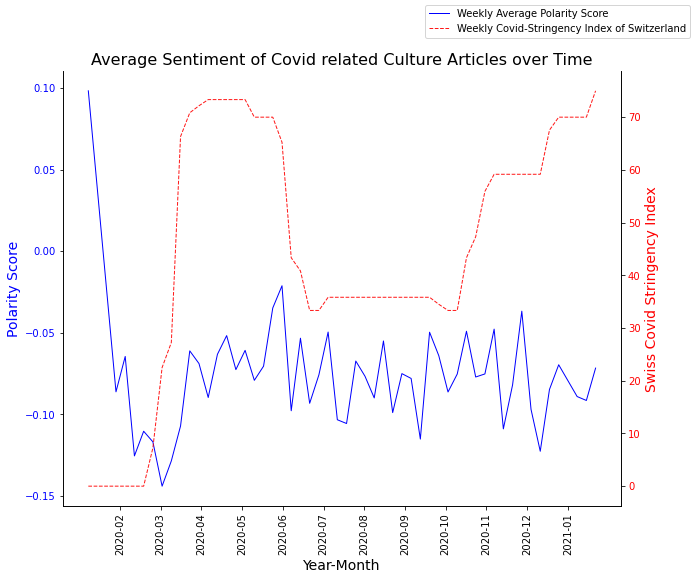

In [38]:
# COVID_events
show_senti_development(articles, 'COVID_events', 'Covid related Culture', polarity_type = "Vader_polarity_adj_2", weekly_mincount = 10, date_min = '2020-01-01')

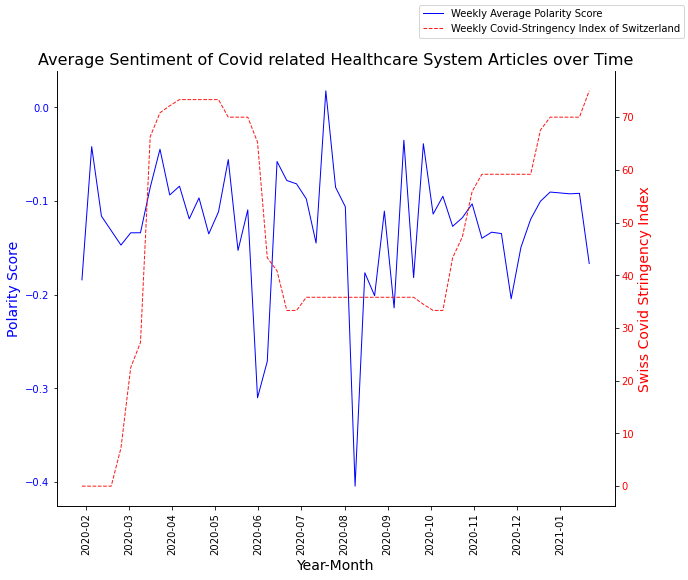

In [39]:
# COVID_healthcare_system
show_senti_development(articles, 'COVID_healthcare_system', 'Covid related Healthcare System', polarity_type = "Vader_polarity_adj_2", weekly_mincount = 5, date_min = '2020-01-01')

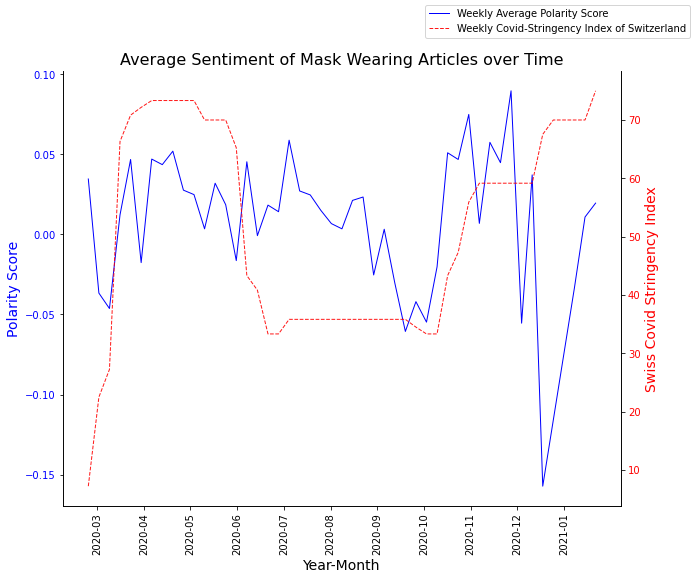

In [40]:
# COVID_mask_wearing
show_senti_development(articles, 'COVID_mask_wearing', 'Mask Wearing', polarity_type = "Vader_polarity_adj_2", weekly_mincount = 15)

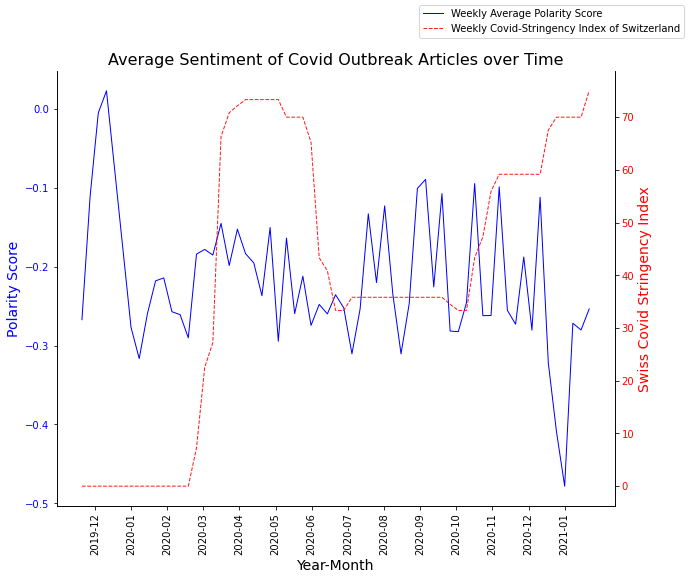

In [41]:
# COVID_outbreak_china
show_senti_development(articles, 'COVID_outbreak_china', 'Covid Outbreak', polarity_type = "Vader_polarity_adj_2", weekly_mincount = 0, date_min = '2019-12-01')

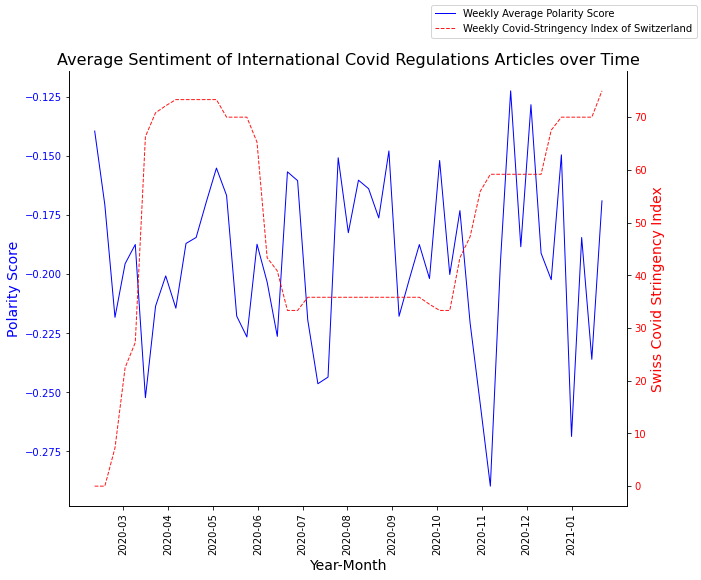

In [42]:
# COVID_regulations_international
show_senti_development(articles, 'COVID_regulations_international', 'International Covid Regulations', polarity_type = "Vader_polarity_adj_2", weekly_mincount = 15)

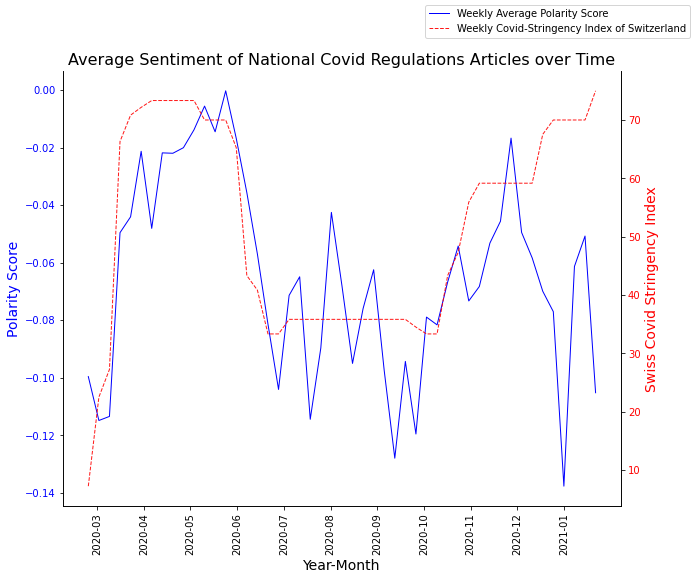

In [43]:
# COVID_regulations_national
show_senti_development(articles, 'COVID_regulations_national', 'National Covid Regulations', polarity_type = "Vader_polarity_adj_2", weekly_mincount = 35)

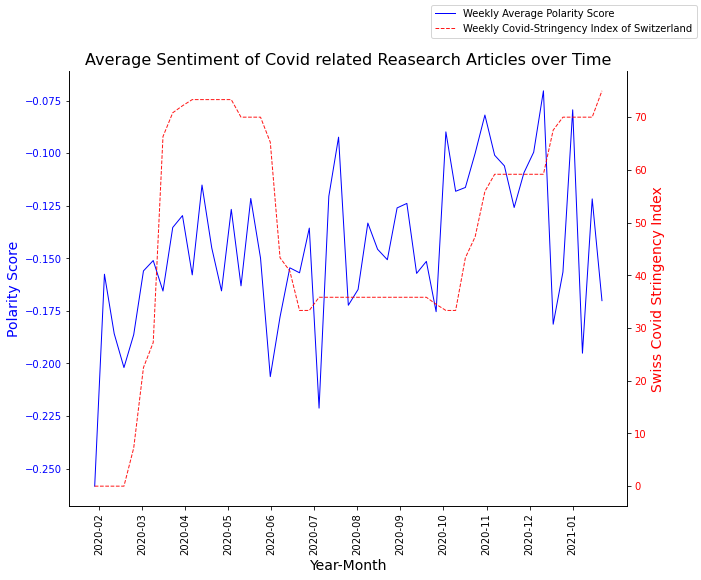

In [44]:
# COVID_research
show_senti_development(articles, 'COVID_research', 'Covid related Reasearch', polarity_type = "Vader_polarity_adj_2", weekly_mincount = 15)

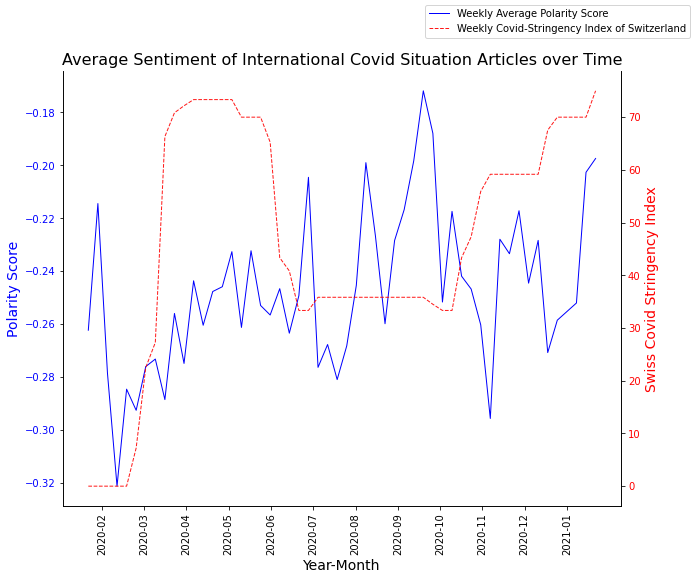

In [45]:
# COVID_situation_factual_international
show_senti_development(articles, 'COVID_situation_factual_international', 'International Covid Situation', polarity_type = "Vader_polarity_adj_2", weekly_mincount = 25)

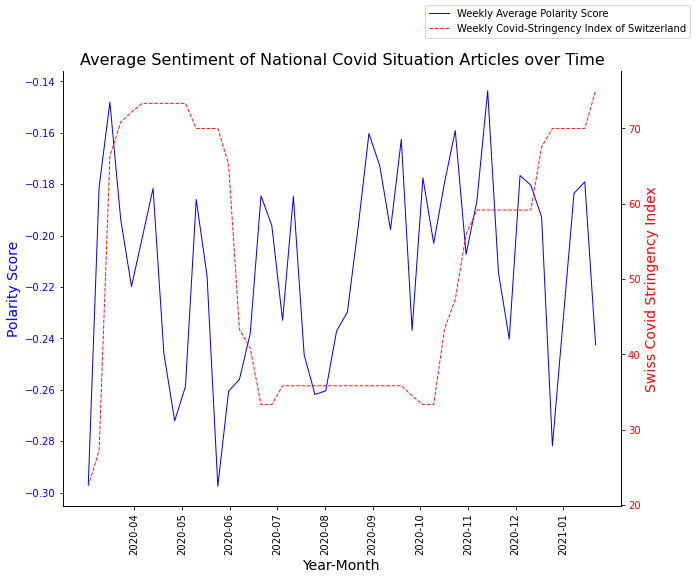

In [46]:
# COVID_situation_factual_national
show_senti_development(articles, 'COVID_situation_factual_national', 'National Covid Situation', polarity_type = "Vader_polarity_adj_2", weekly_mincount = 30)

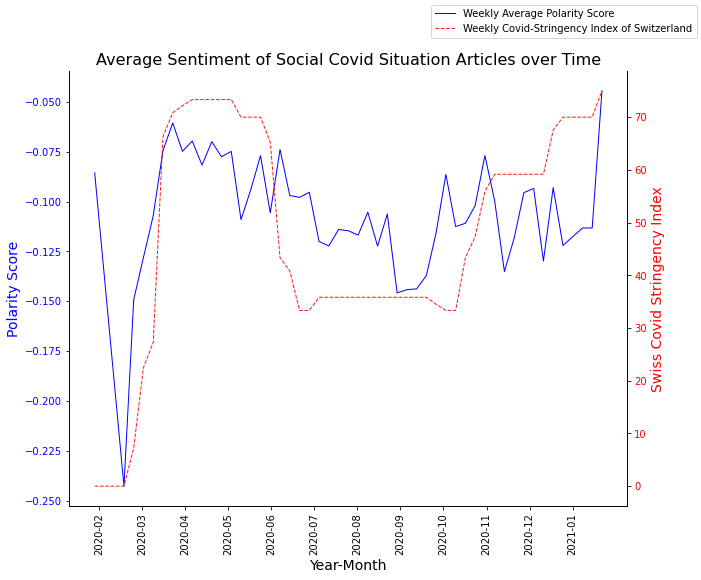

In [47]:
# COVID_situation_social
show_senti_development(articles, 'COVID_situation_social', 'Social Covid Situation', polarity_type = "Vader_polarity_adj_2", weekly_mincount = 35)

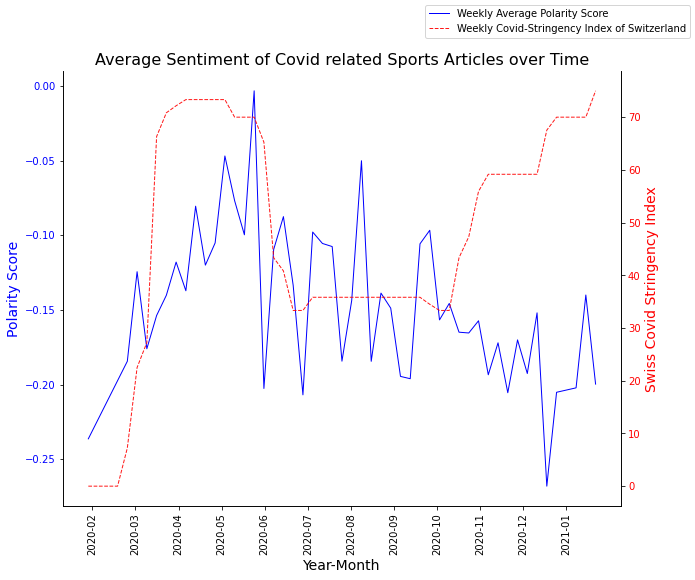

In [48]:
# COVID_sports
show_senti_development(articles, 'COVID_sports', 'Covid related Sports', polarity_type = "Vader_polarity_adj_2", weekly_mincount = 15)

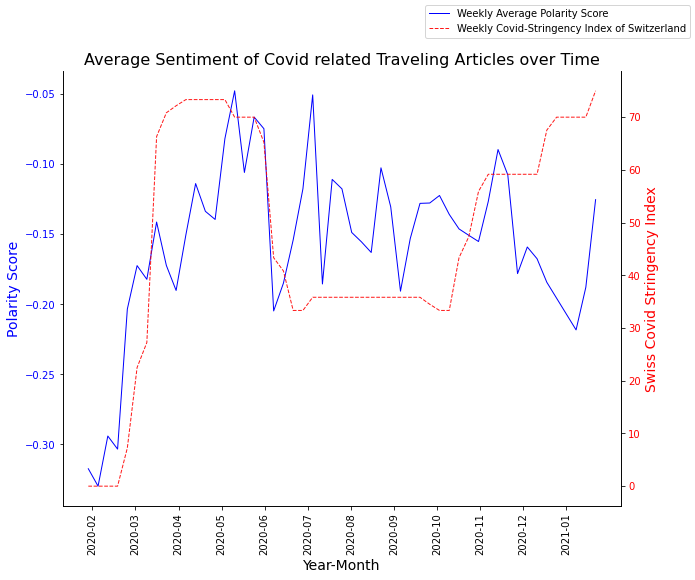

In [49]:
# COVID_traveling
show_senti_development(articles, 'COVID_traveling', 'Covid related Traveling', polarity_type = "Vader_polarity_adj_2", weekly_mincount = 30)

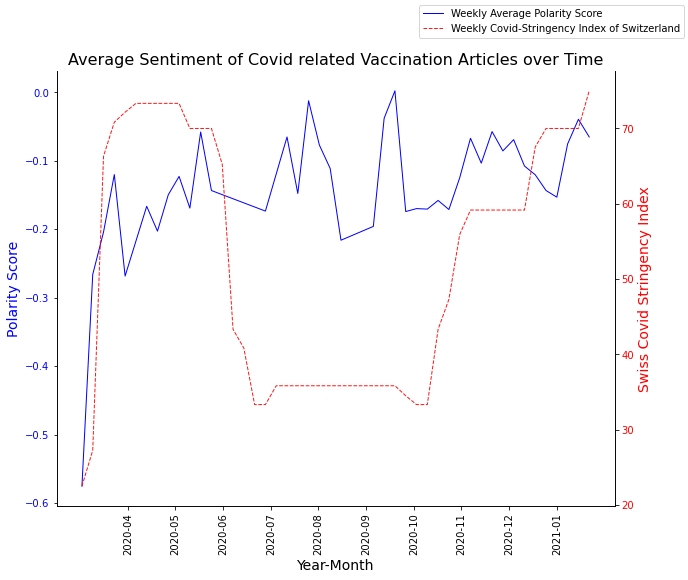

In [50]:
# COVID_vaccination
show_senti_development(articles, 'COVID_vaccination', 'Covid related Vaccination', polarity_type = "Vader_polarity_adj_2", weekly_mincount = 15)

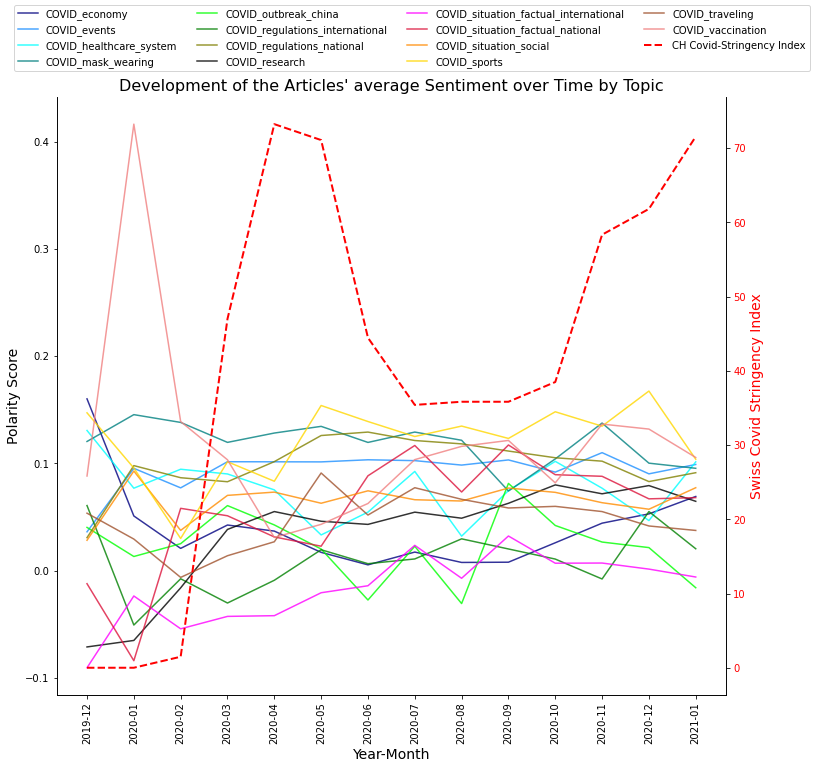

In [51]:
## Overall comparison monthly
# Display and compare the COVID topic specific development of the articles' sentiment over time (using the VPA)
compare_senti_development_across_COVID_topics_monthly(articles, polarity_type = "Vader_polarity_adj", date_min = '2019-12-01')

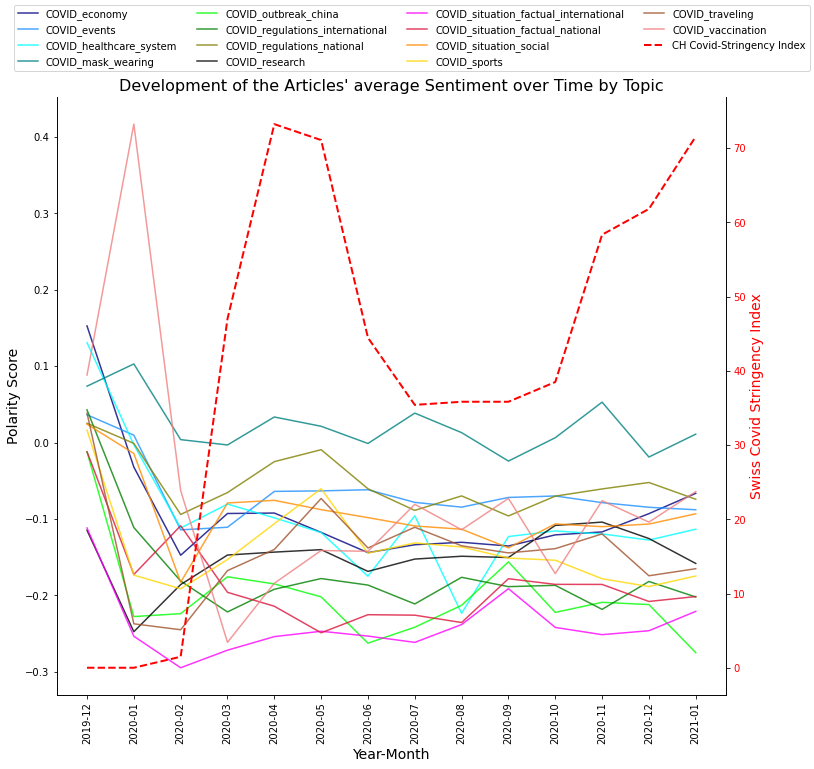

In [52]:
## Overall comparison monthly
# Display and compare the COVID topic specific development of the articles' sentiment over time (using the VPAII)
compare_senti_development_across_COVID_topics_monthly(articles, polarity_type = "Vader_polarity_adj_2", date_min = '2019-12-01')

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
2.3.2 General topics
</h3>
</div>

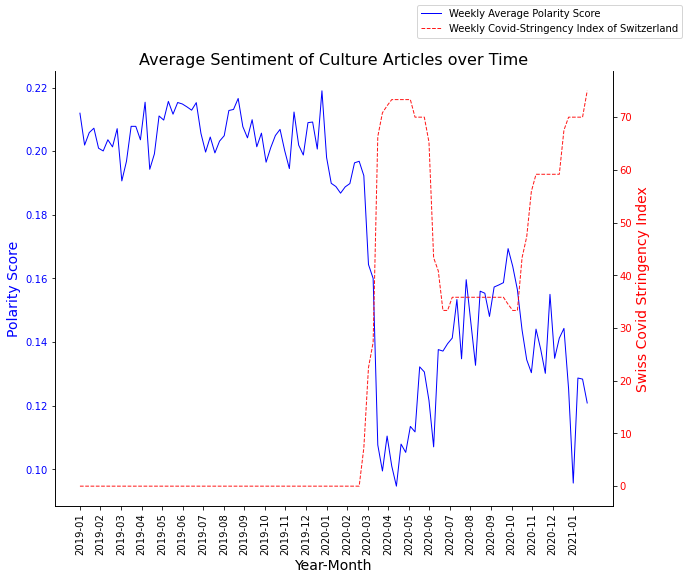

In [53]:
# culture
show_senti_development(articles, 'culture', 'Culture', polarity_type = "Vader_polarity_adj_2")

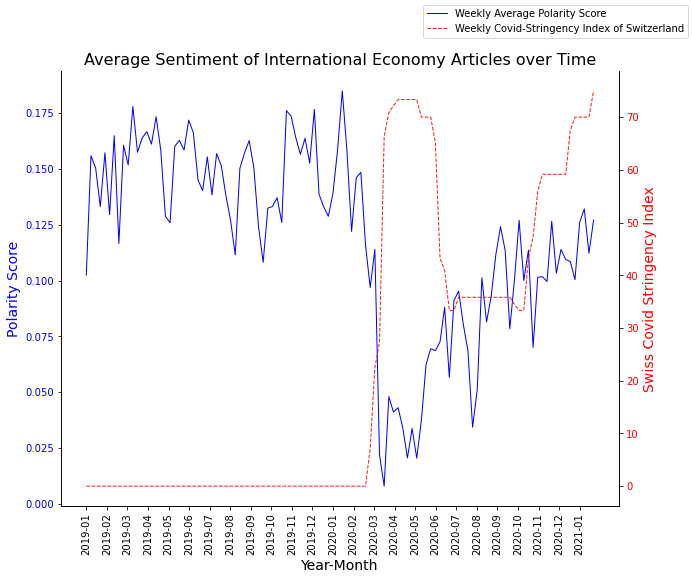

In [54]:
# economy international
show_senti_development(articles, 'economy_international', 'International Economy', polarity_type = "Vader_polarity_adj_2")

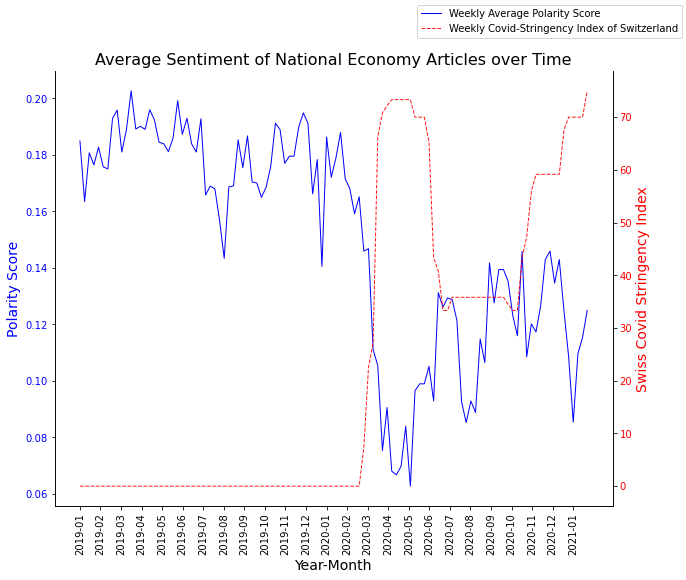

In [55]:
# economy national
show_senti_development(articles, 'economy_national', 'National Economy', polarity_type = "Vader_polarity_adj_2")

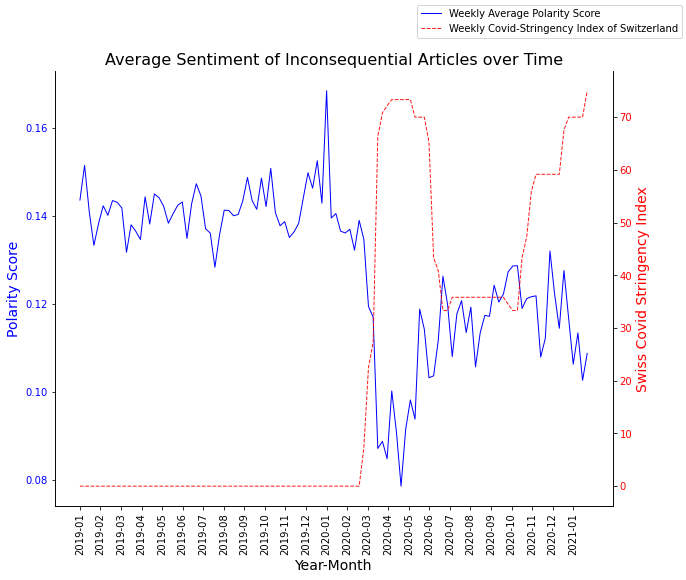

In [56]:
# inconsequential
show_senti_development(articles, 'inconsequential', 'Inconsequential', polarity_type = "Vader_polarity_adj_2")

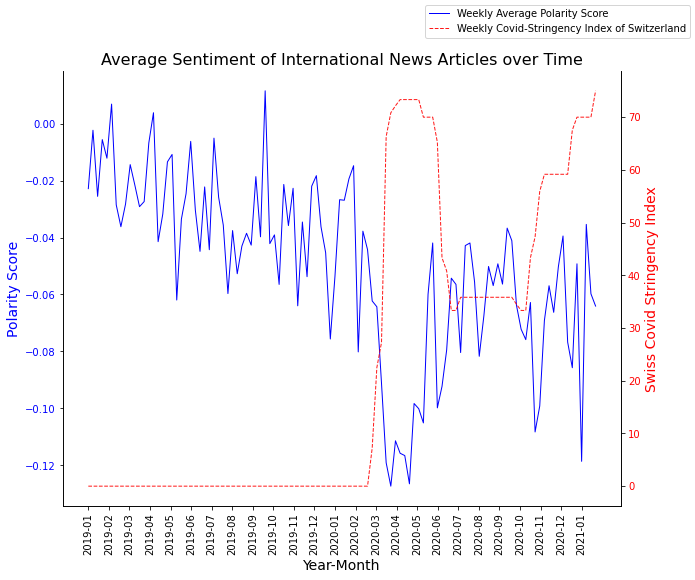

In [57]:
# international news
show_senti_development(articles, 'international_news', 'International News', polarity_type = "Vader_polarity_adj_2")

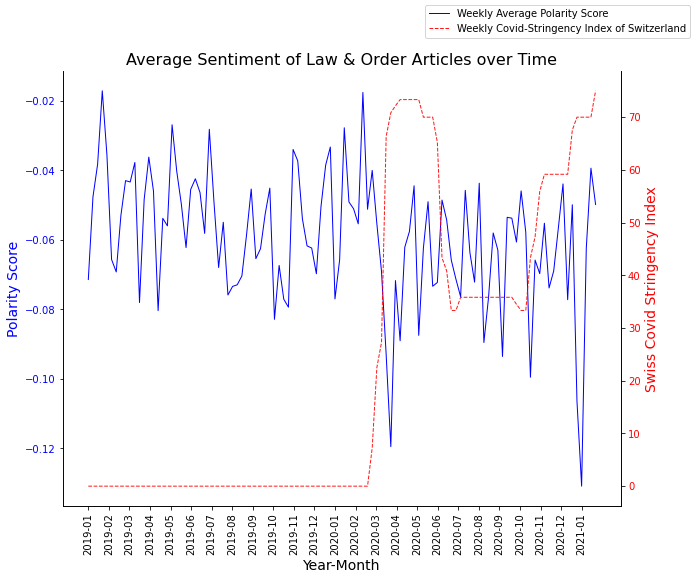

In [58]:
# law & order
show_senti_development(articles, 'law_order', 'Law & Order', polarity_type = "Vader_polarity_adj_2")

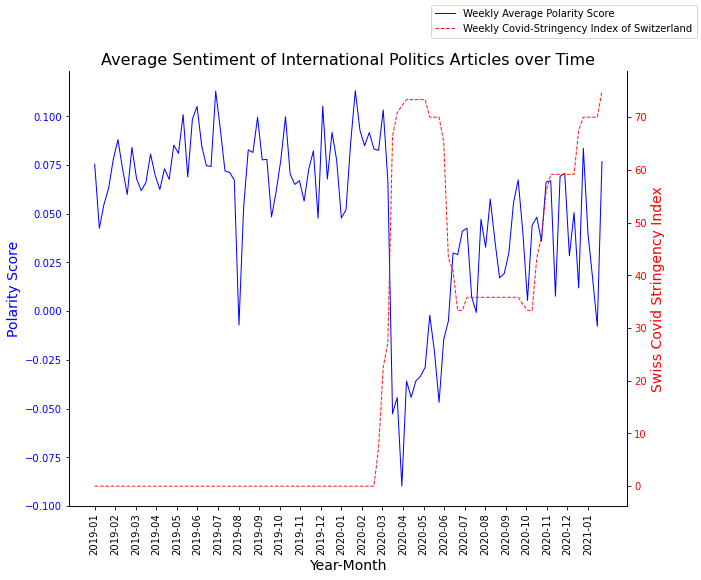

In [59]:
# politics international
show_senti_development(articles, 'politics_international', 'International Politics', polarity_type = "Vader_polarity_adj_2")

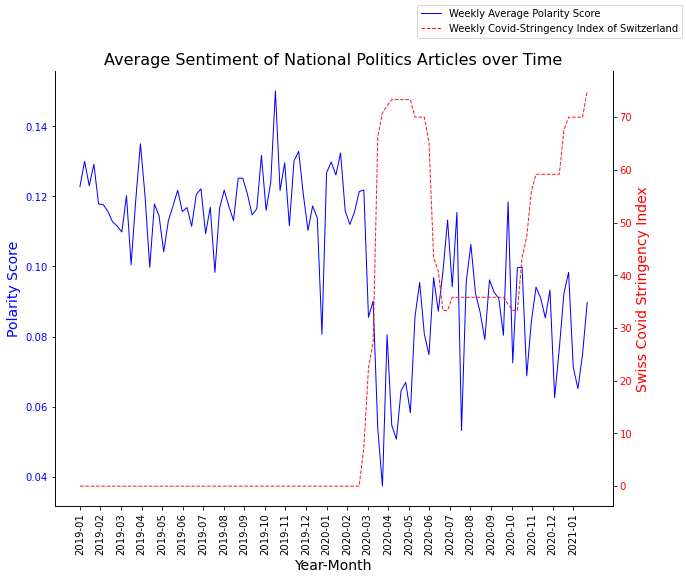

In [60]:
# politics national
show_senti_development(articles, 'politics_national', 'National Politics', polarity_type = "Vader_polarity_adj_2")

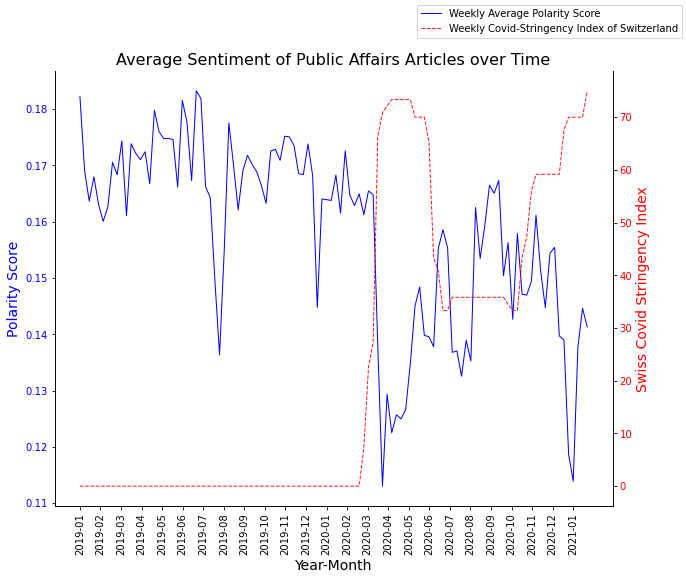

In [61]:
# public affairs
show_senti_development(articles, 'public_affairs', 'Public Affairs', polarity_type = "Vader_polarity_adj_2")

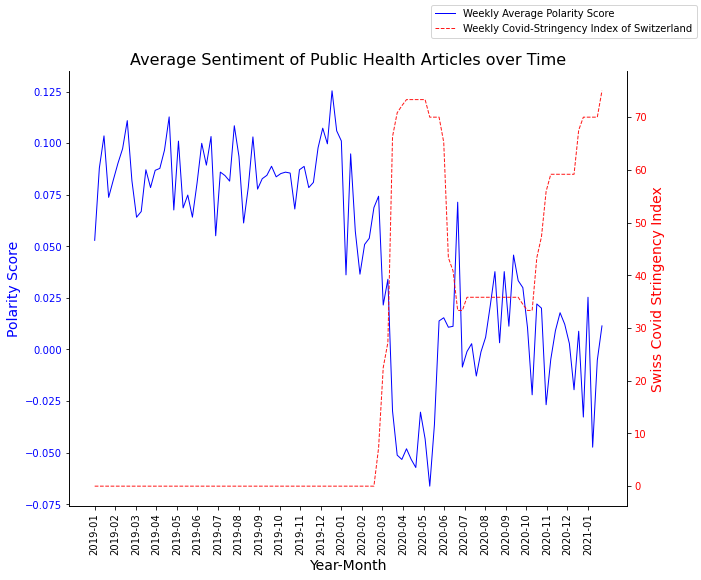

In [62]:
# public health
show_senti_development(articles, 'public_health', 'Public Health', polarity_type = "Vader_polarity_adj_2")

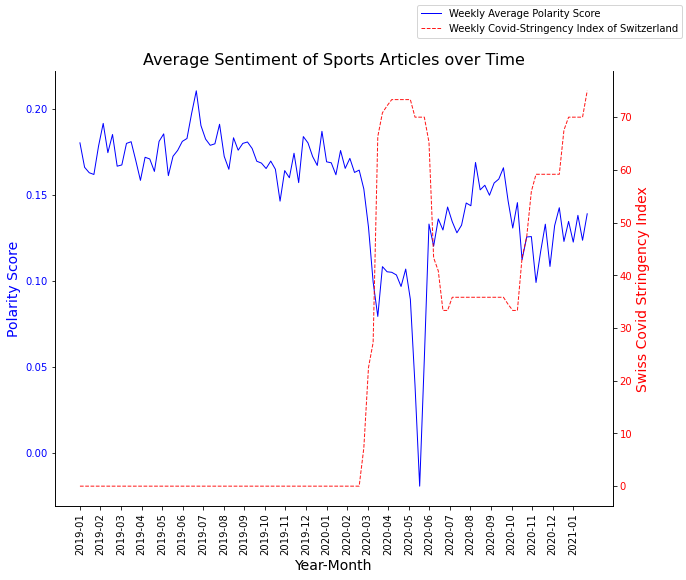

In [63]:
# sports
show_senti_development(articles, 'sports', 'Sports', polarity_type = "Vader_polarity_adj_2")

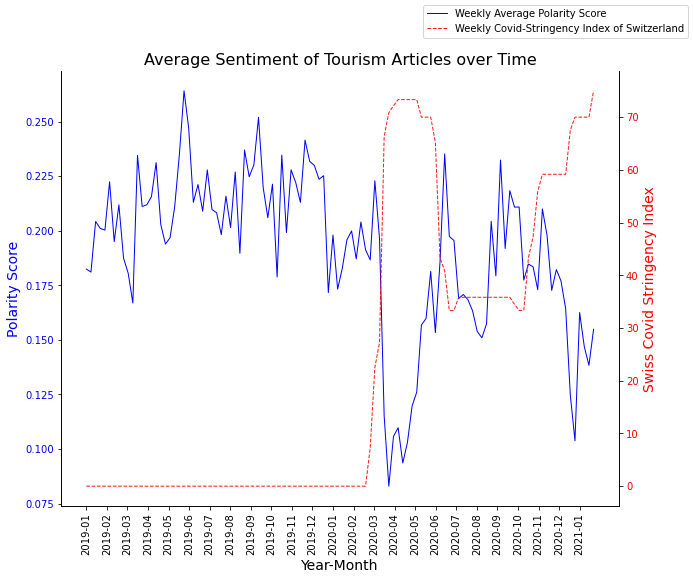

In [64]:
# tourism
show_senti_development(articles, 'tourism', 'Tourism', polarity_type = "Vader_polarity_adj_2")

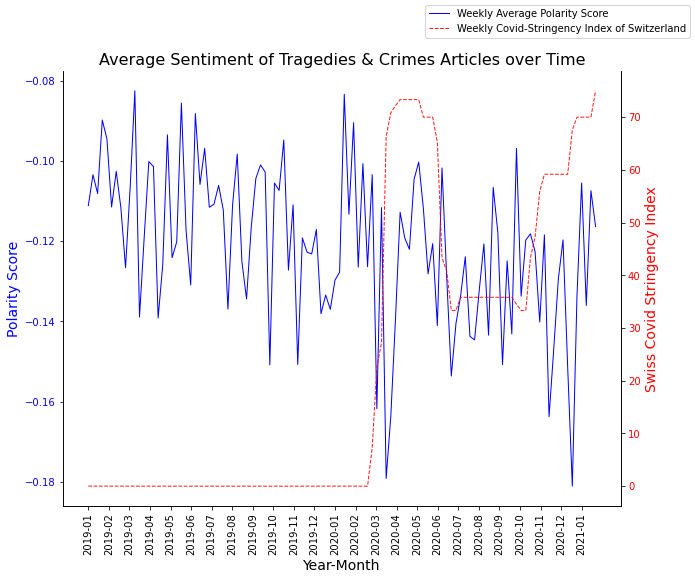

In [65]:
# tragedies_crimes
show_senti_development(articles, 'tragedies_crimes', 'Tragedies & Crimes', polarity_type = "Vader_polarity_adj_2")

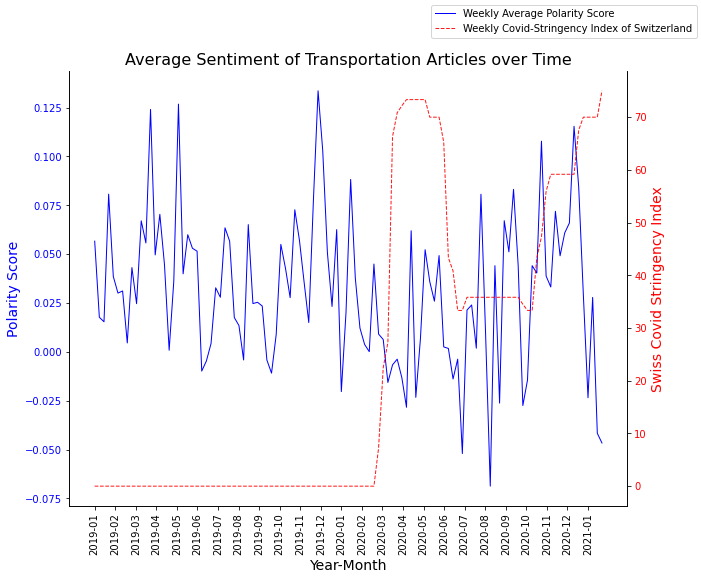

In [66]:
# transportation
show_senti_development(articles, 'transportation', 'Transportation', polarity_type = "Vader_polarity_adj_2")

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
3. News Channel specific EDA
</h2>
</div>

In [67]:
## Define a function to display the topic specific portion of the overall publications for each News Channel
def show_COVID_topic_publication_portion_by_channels(articles, topic, topic_fulltext):
    # Count the overall publications per media channel
    total_counts = np.unique(articles['source_long'], return_counts = True)
    # Create a dataframe containing the number of total publications in a column while using the according media channel as the index
    total_counts = pd.DataFrame({'total_counts': total_counts[1]}, index = total_counts[0]).sort_index()
    # Count the topic specific publications per media channel
    topic_counts = np.unique(articles.loc[articles['Topic_fine'] == topic, 'source_long'], return_counts = True)
    # Create a dataframe containing the topic specific publications in a column while using the according media channel as the index
    topic_counts = pd.DataFrame({'topic_counts': topic_counts[1]}, index = topic_counts[0]).sort_index()
    # Merge both dataframes
    topic_coverage = total_counts.merge(topic_counts, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    # Replace all missing values in the column topic_counts with a 0, since no articles on the focal topic have been published by the corresponding News Channels
    topic_coverage.loc[topic_coverage['topic_counts'].isna(), 'topic_counts'] = 0
    # Create a column containing the topic specific portion of the overall publications for each News Channel
    topic_coverage['topic_portion'] = topic_coverage['topic_counts'].values / topic_coverage['total_counts'].values

    # Plot the topic specific publication portion for each News Channel
    fig = plt.figure(figsize = (13,20))
    ax = fig.add_subplot(111)
    y_pos = np.arange(topic_coverage.shape[0])
    ax.barh(y_pos, topic_coverage['topic_portion'].values, align = 'center', color = 'black', alpha = 0.8, label = 'Portion of '+topic_fulltext+' Articles')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(topic_coverage.index.tolist())
    ax.set_title('Portion of '+topic_fulltext+' Articles by News Channel')
    ax.set_ylabel('News Channel')
    ax.set_xlabel('Portion of Total Publications')
    ax.invert_yaxis() # to read labels from top-to-bottom
    # Display the plot
    plt.legend()
    plt.show()

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
3.1 Topic Coverage by News Channel
</h3>
</div>

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
3.1.1 COVID topics
</h3>
</div>

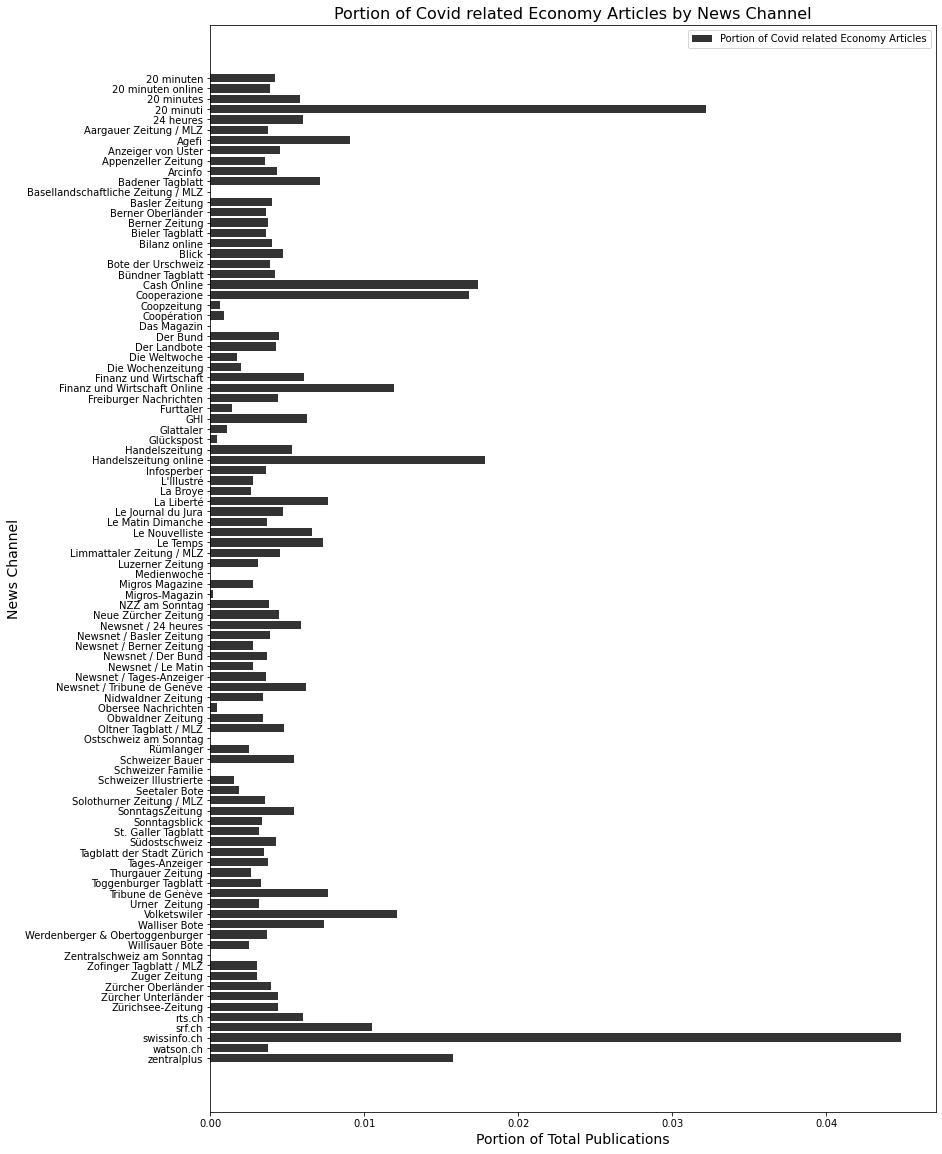

In [68]:
# COVID_economy
show_COVID_topic_publication_portion_by_channels(articles, 'COVID_economy', 'Covid related Economy')

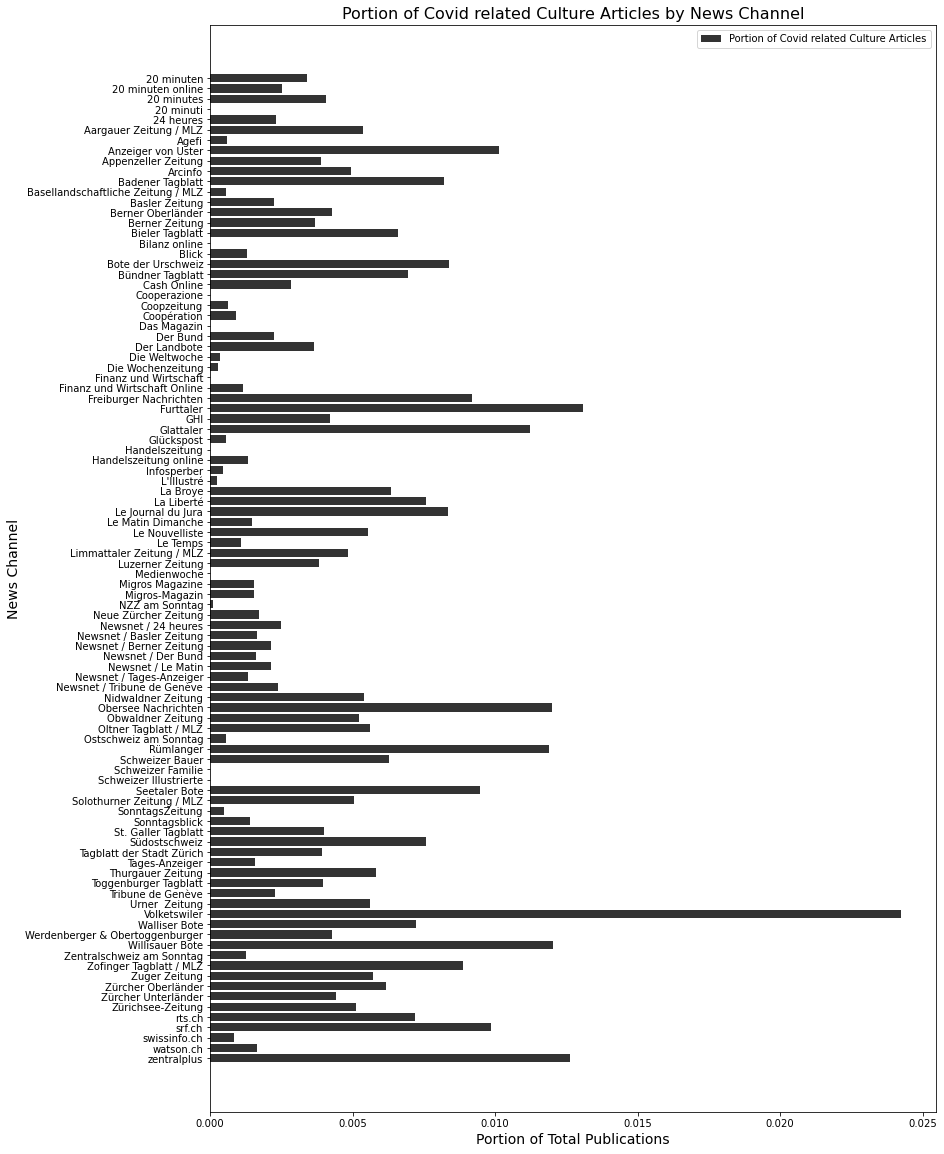

In [69]:
# COVID_events
show_COVID_topic_publication_portion_by_channels(articles, 'COVID_events', 'Covid related Culture')

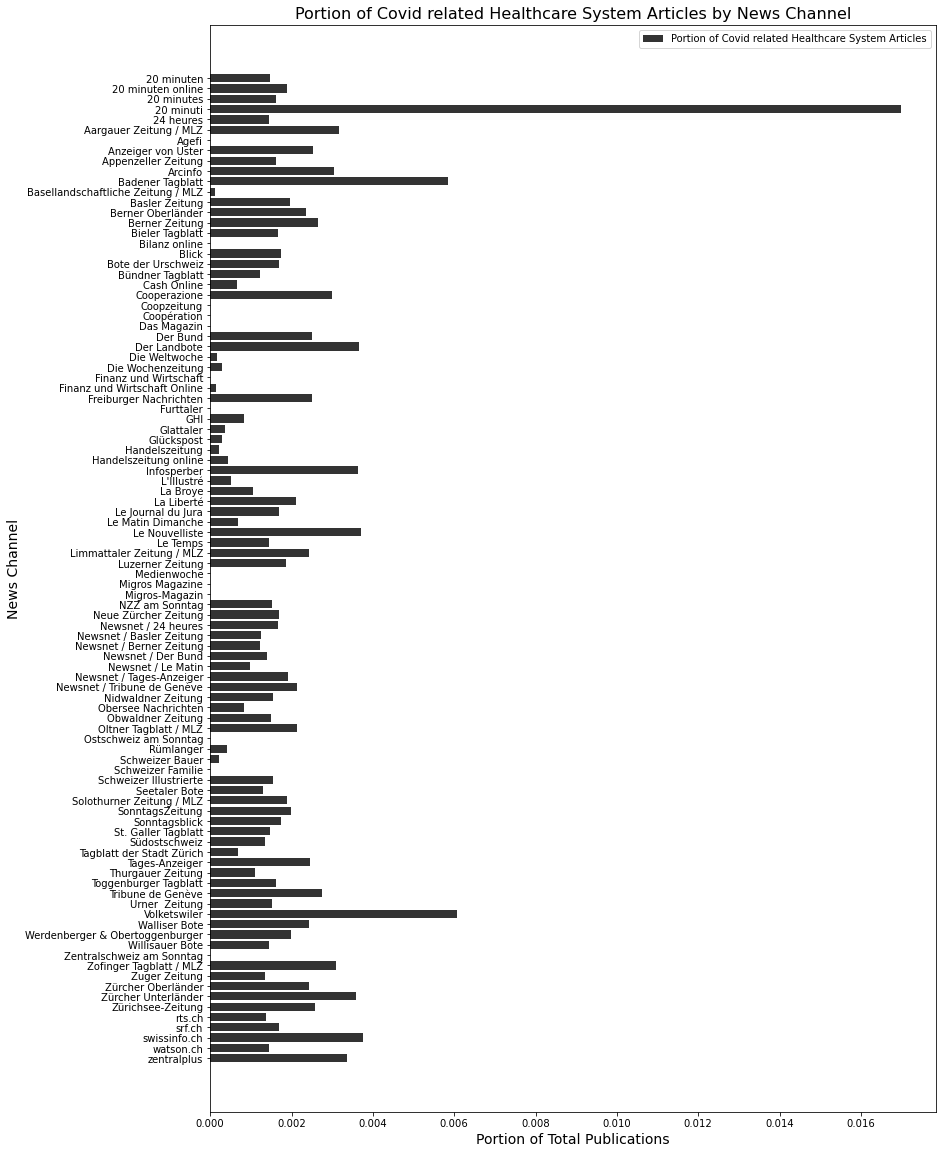

In [70]:
# COVID_healthcare_system
show_COVID_topic_publication_portion_by_channels(articles, 'COVID_healthcare_system', 'Covid related Healthcare System')

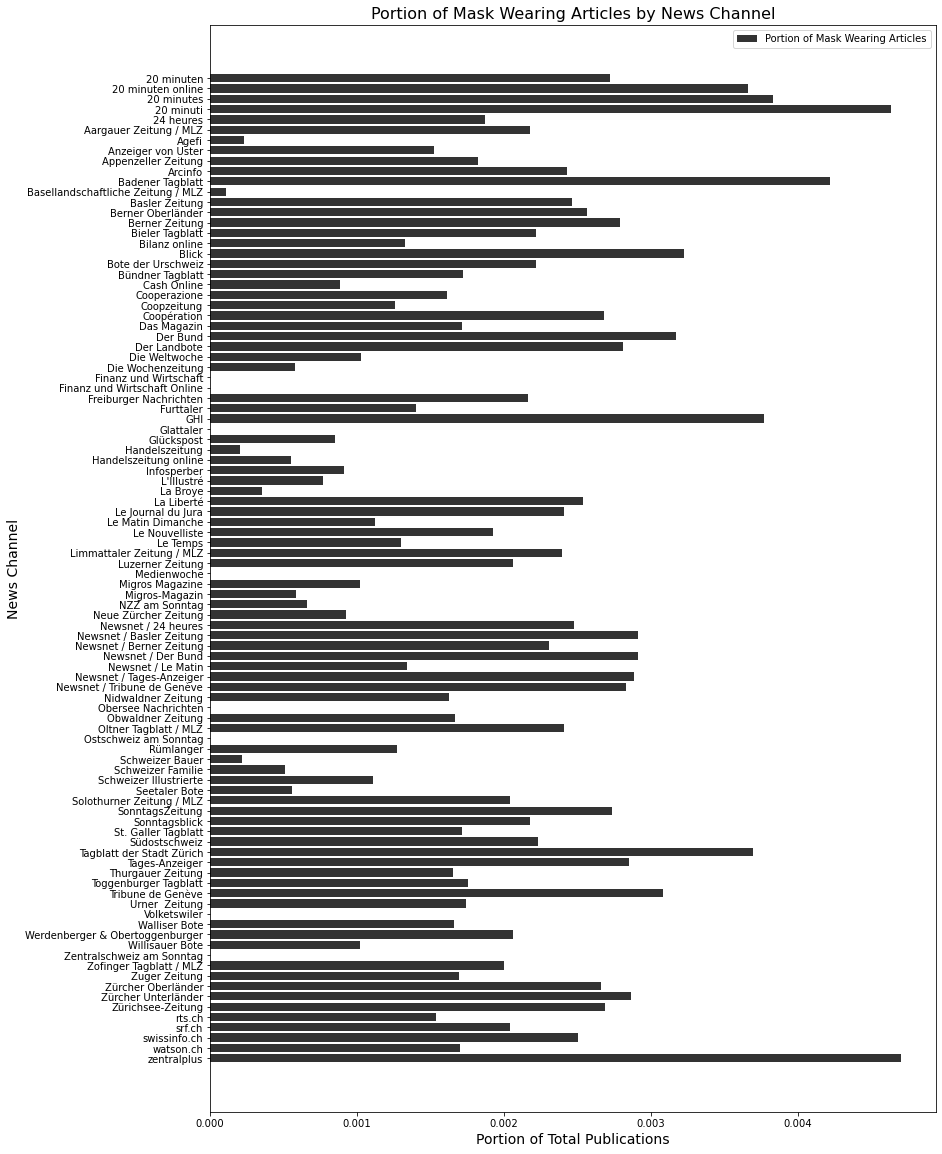

In [71]:
# COVID_mask_wearing
show_COVID_topic_publication_portion_by_channels(articles, 'COVID_mask_wearing', 'Mask Wearing')

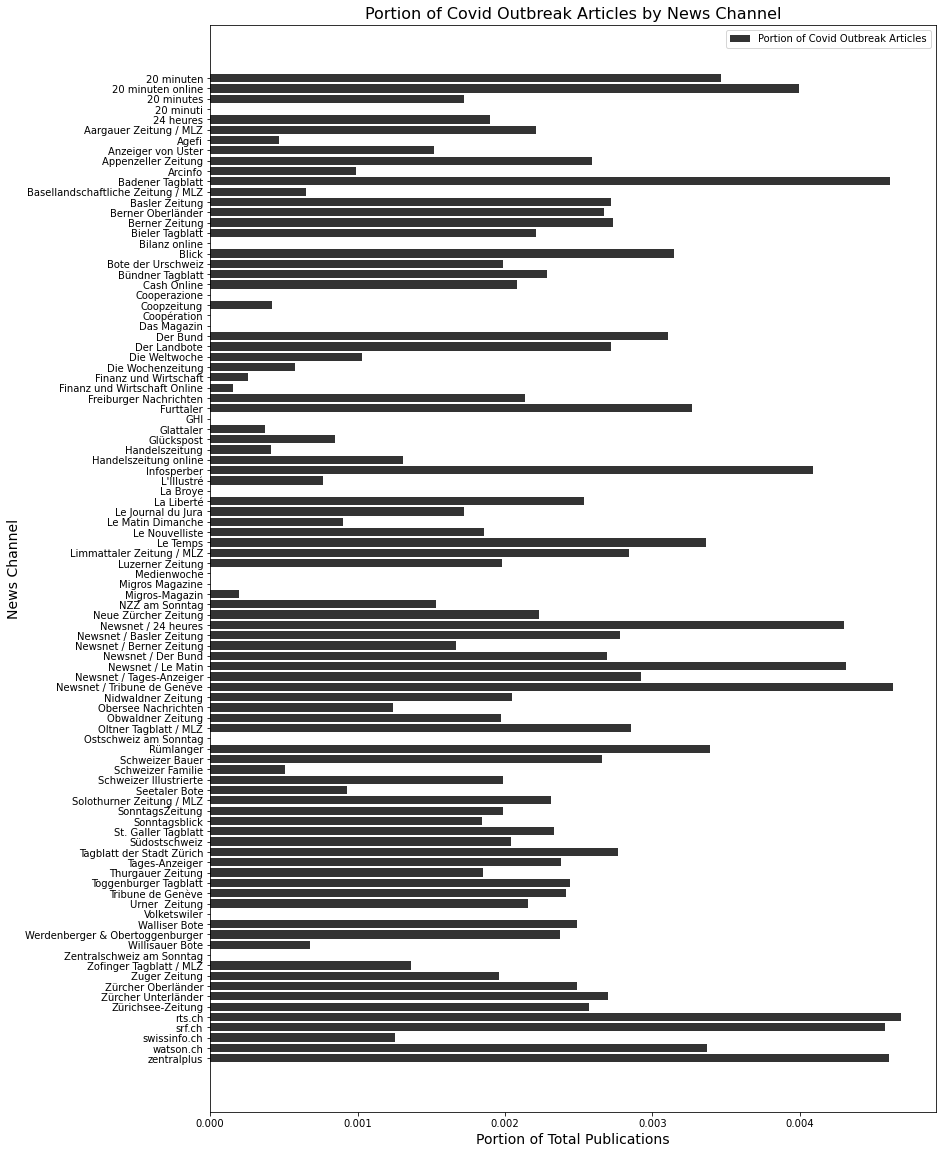

In [72]:
# COVID_outbreak_china
show_COVID_topic_publication_portion_by_channels(articles, 'COVID_outbreak_china', 'Covid Outbreak')

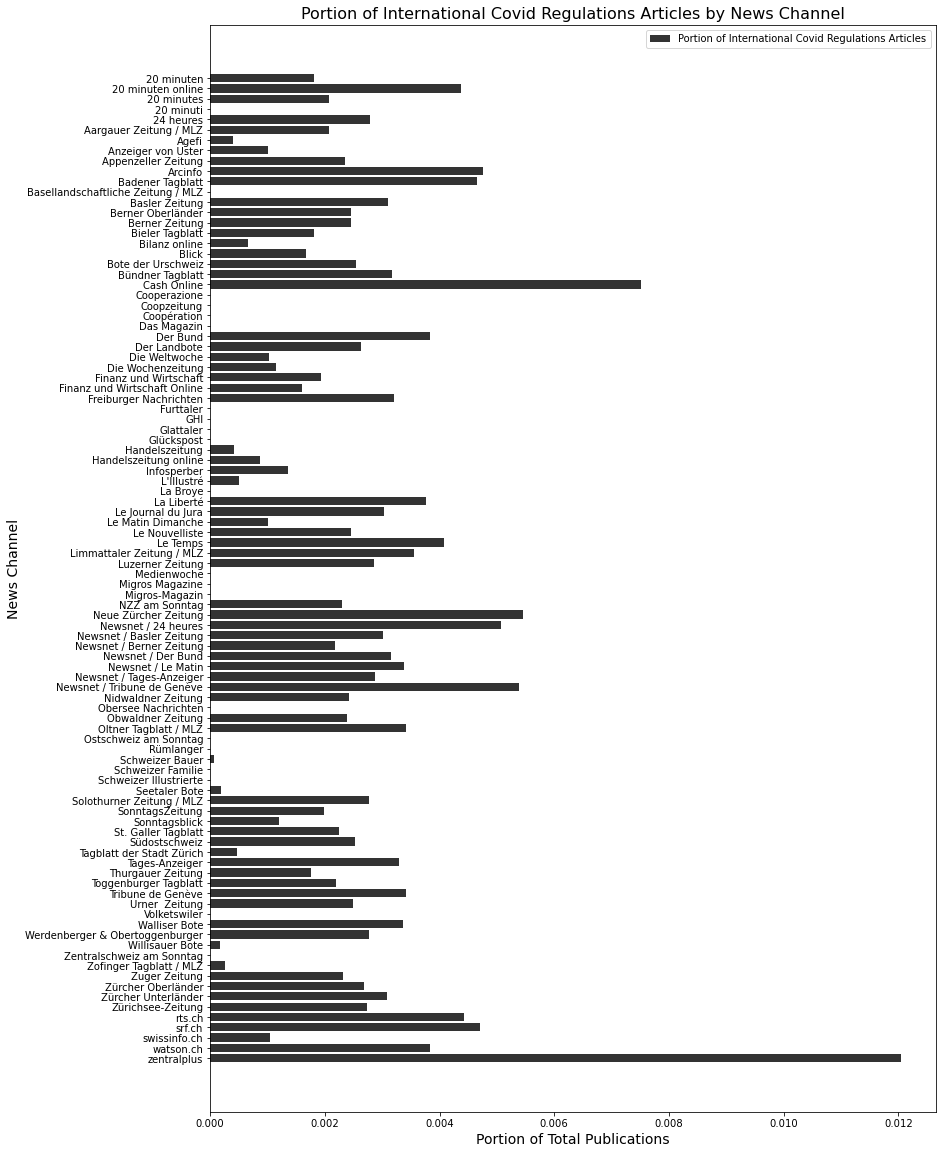

In [73]:
# COVID_regulations_international
show_COVID_topic_publication_portion_by_channels(articles, 'COVID_regulations_international', 'International Covid Regulations')

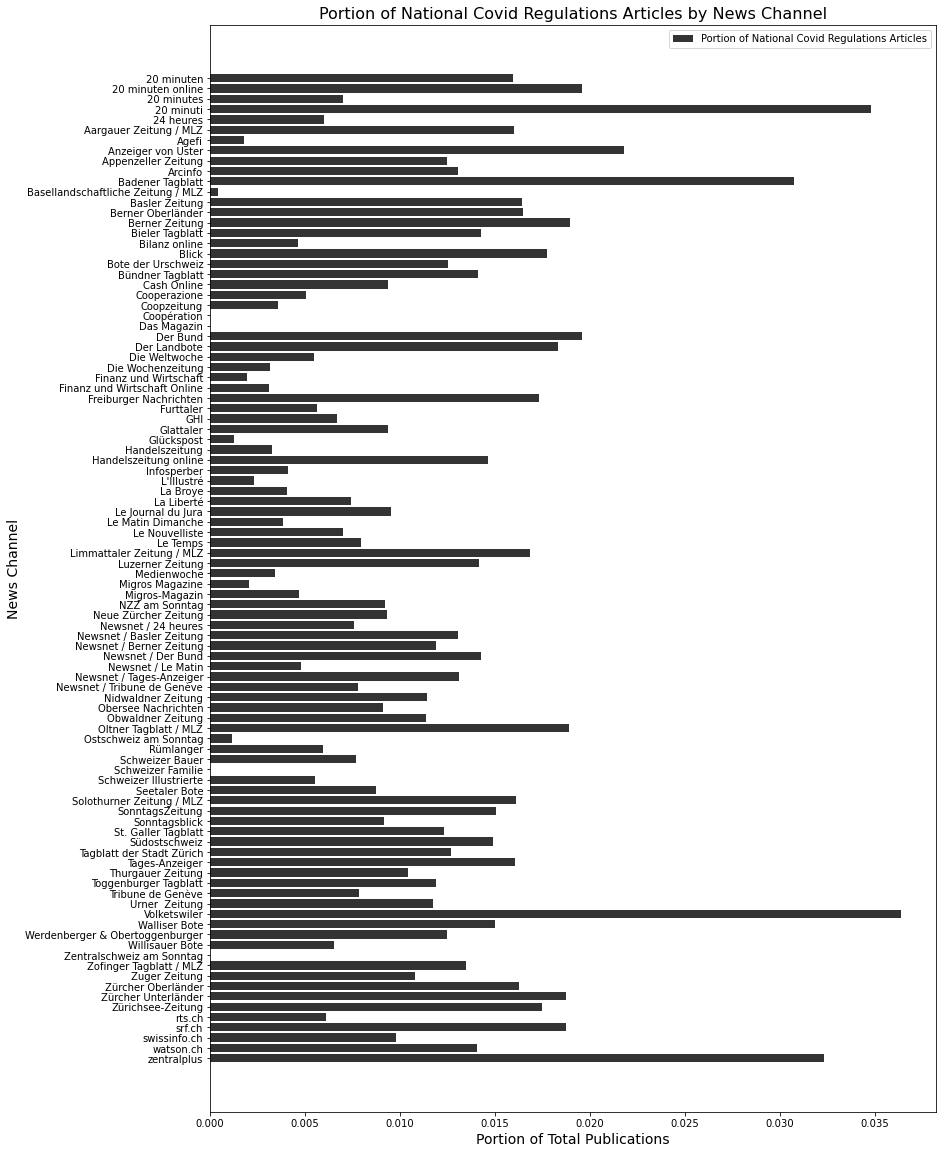

In [74]:
# COVID_regulations_national
show_COVID_topic_publication_portion_by_channels(articles, 'COVID_regulations_national', 'National Covid Regulations')

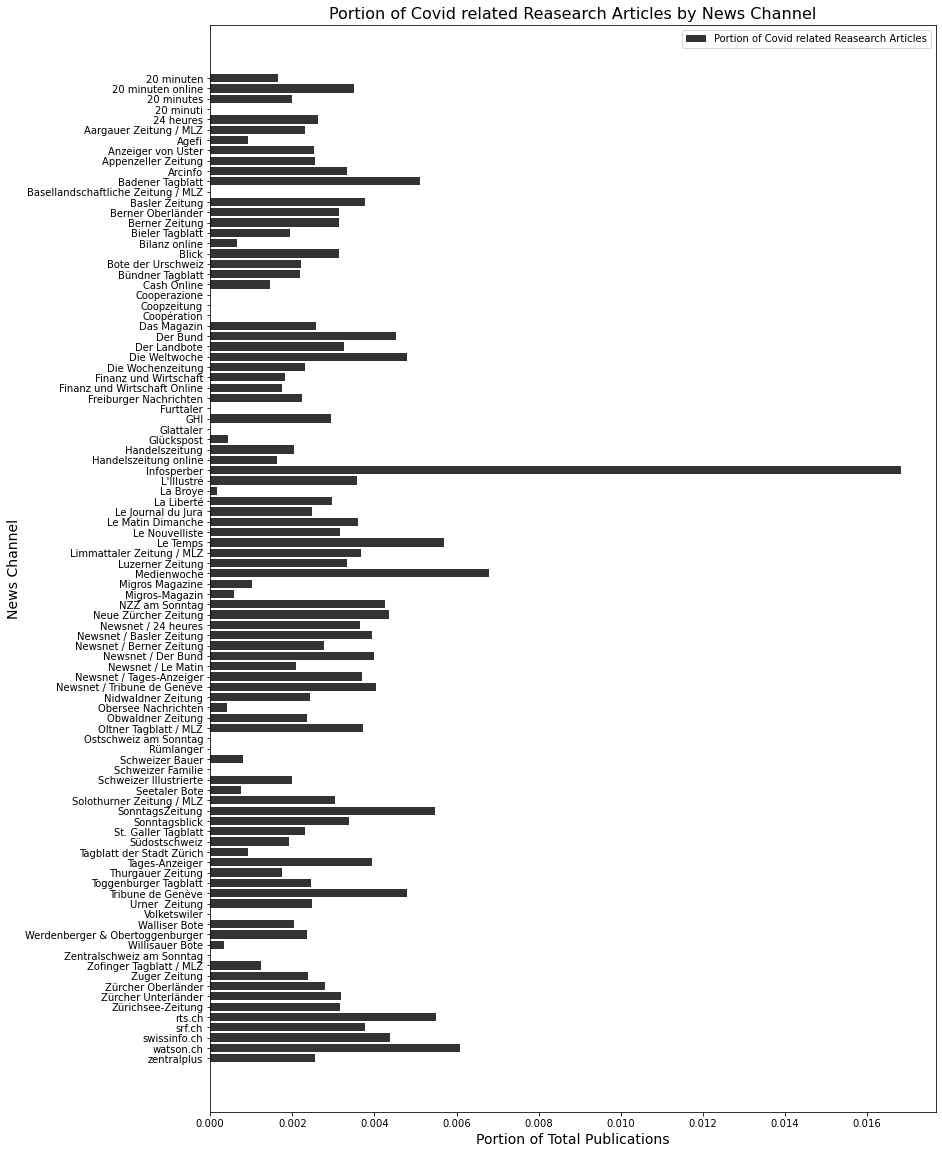

In [75]:
# COVID_research
show_COVID_topic_publication_portion_by_channels(articles, 'COVID_research', 'Covid related Reasearch')

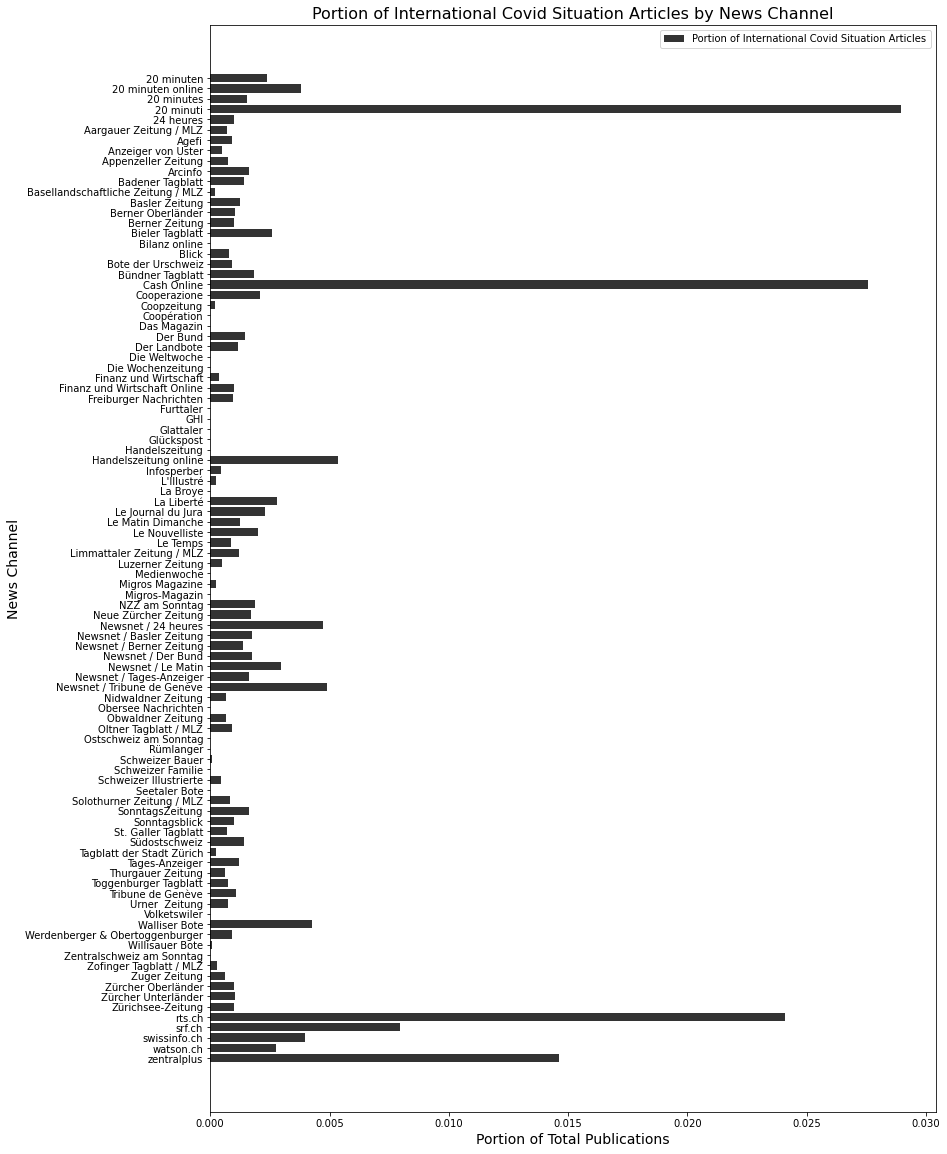

In [76]:
# COVID_situation_factual_international
show_COVID_topic_publication_portion_by_channels(articles, 'COVID_situation_factual_international', 'International Covid Situation')

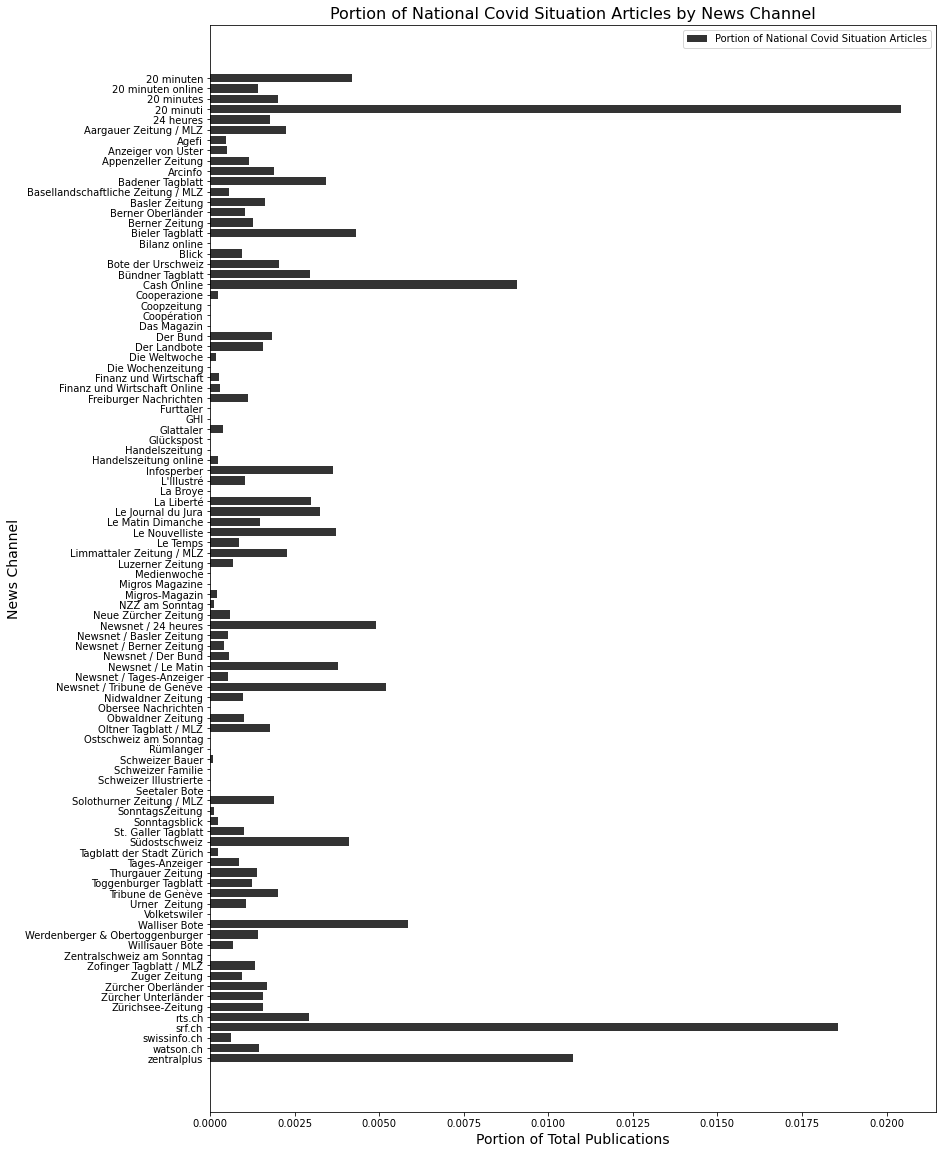

In [77]:
# COVID_situation_factual_national
show_COVID_topic_publication_portion_by_channels(articles, 'COVID_situation_factual_national', 'National Covid Situation')

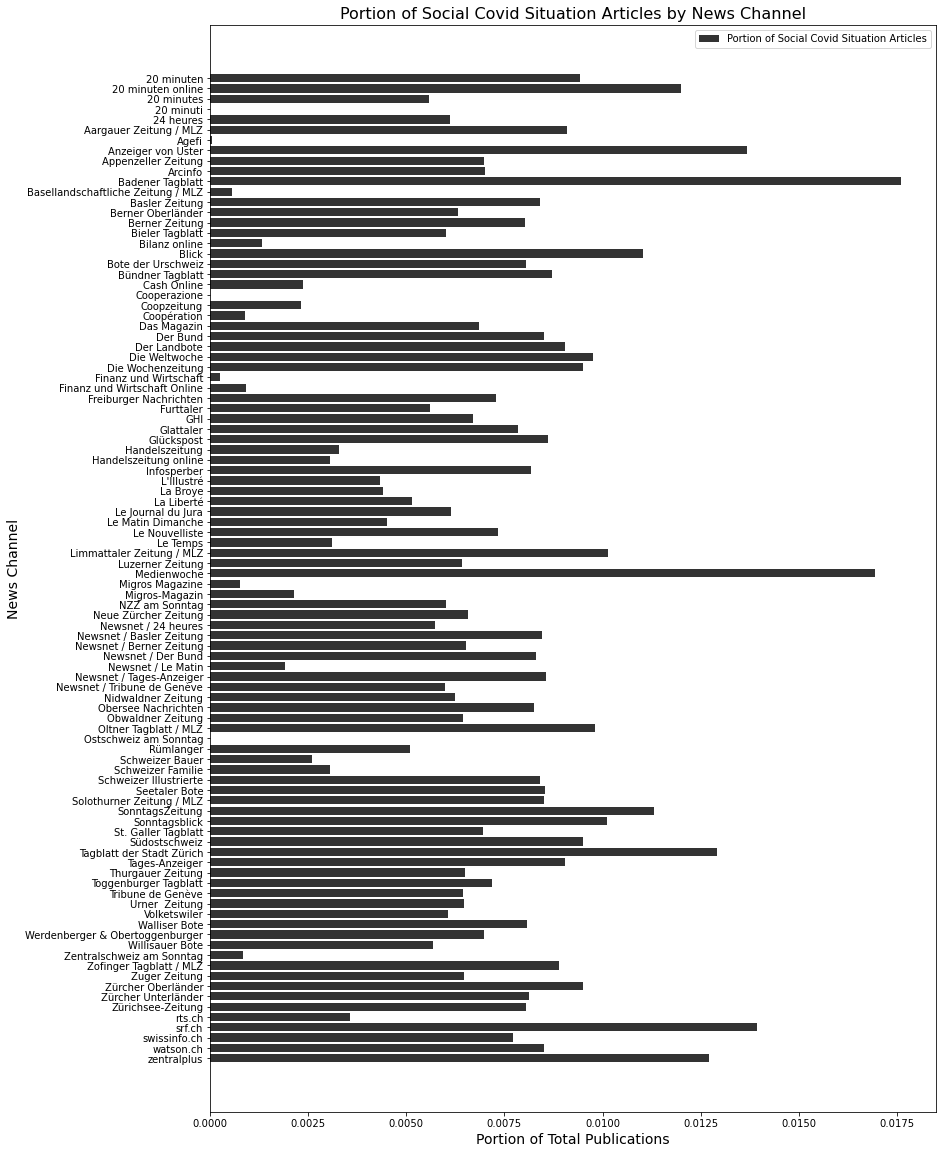

In [78]:
# COVID_situation_social
show_COVID_topic_publication_portion_by_channels(articles, 'COVID_situation_social', 'Social Covid Situation')

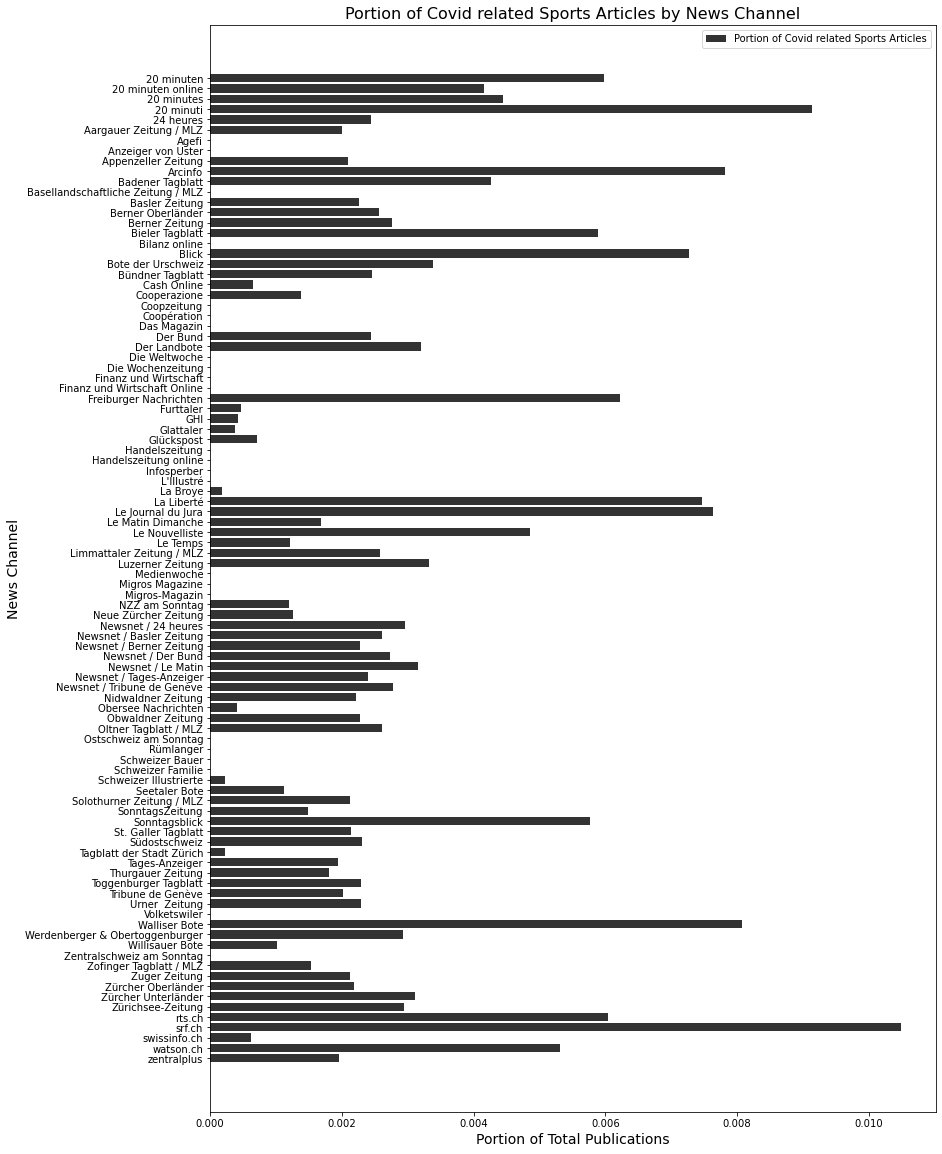

In [79]:
# COVID_sports
show_COVID_topic_publication_portion_by_channels(articles, 'COVID_sports', 'Covid related Sports')

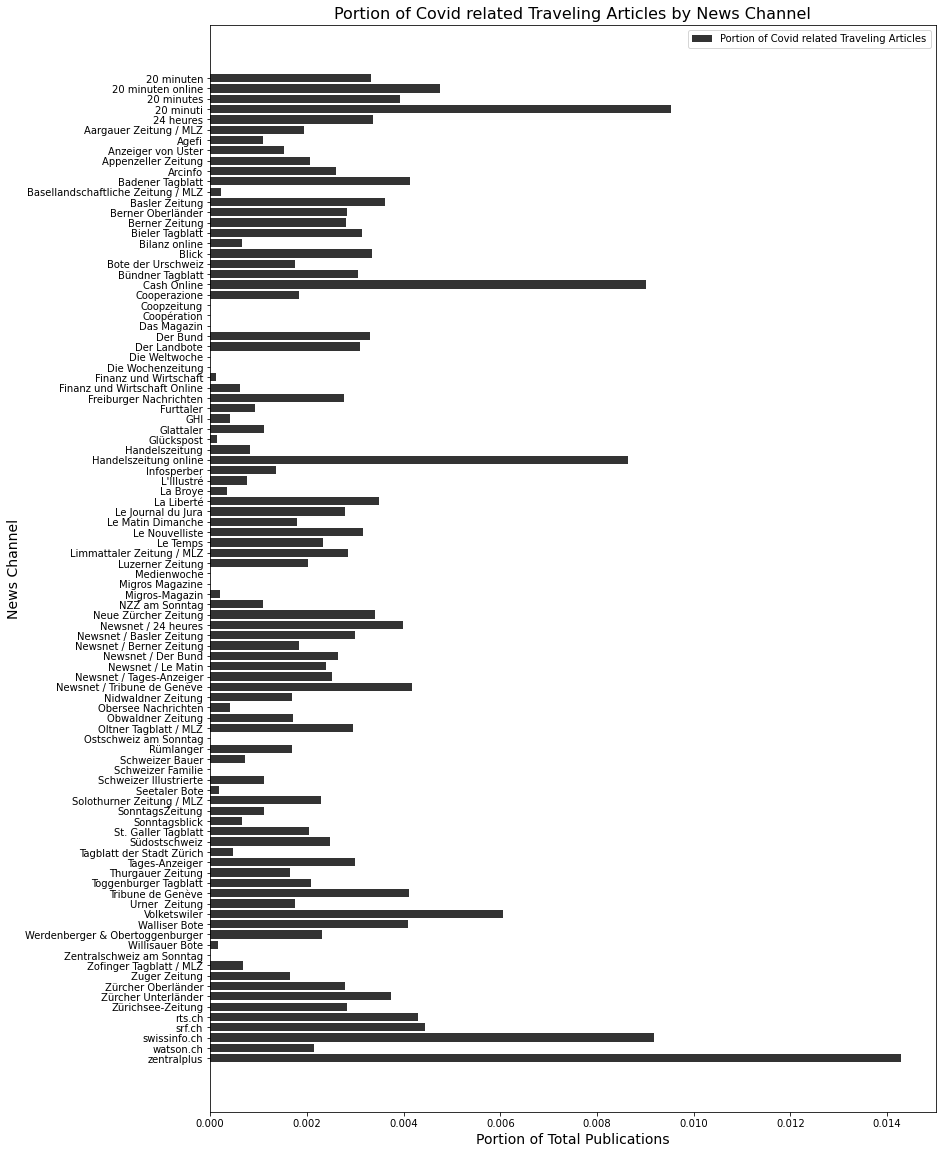

In [80]:
# COVID_traveling
show_COVID_topic_publication_portion_by_channels(articles, 'COVID_traveling', 'Covid related Traveling')

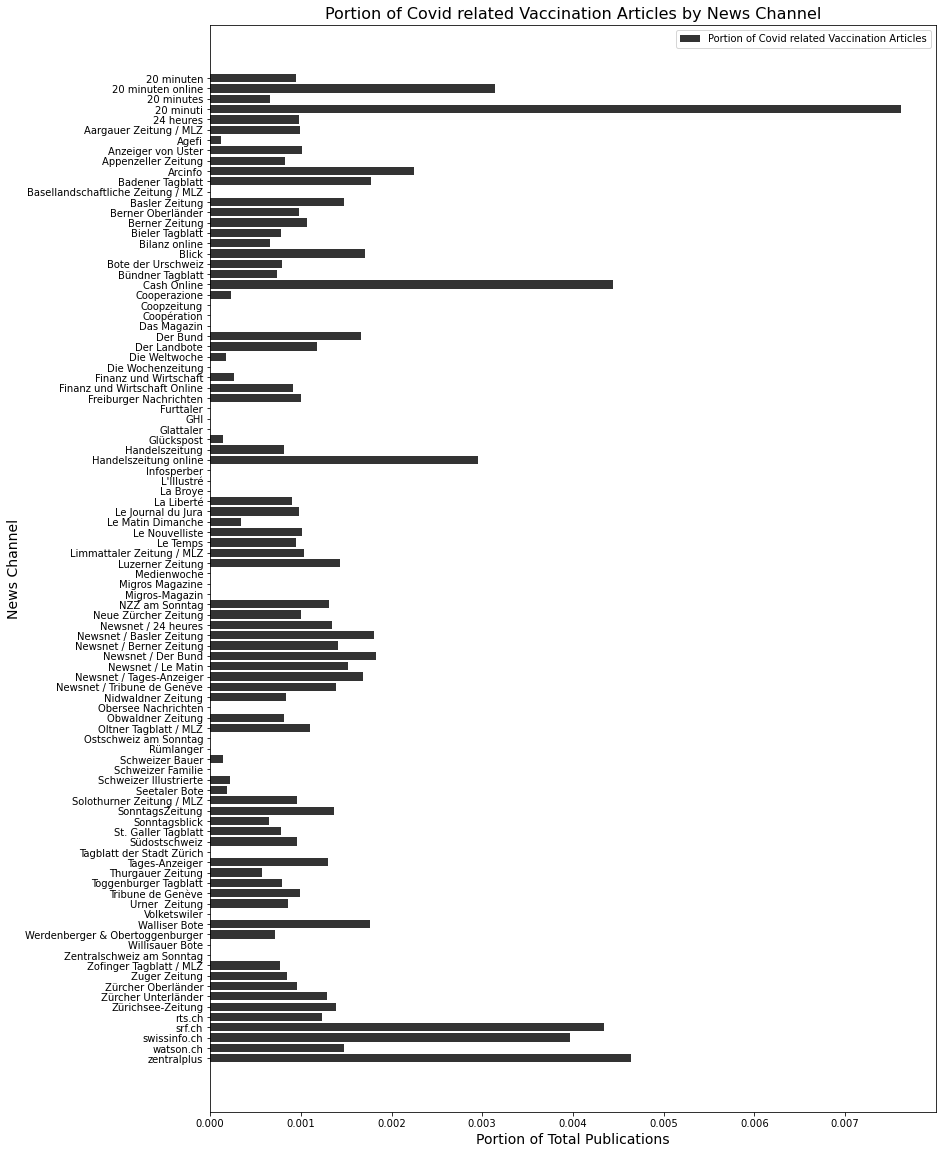

In [81]:
# COVID_vaccination
show_COVID_topic_publication_portion_by_channels(articles, 'COVID_vaccination', 'Covid related Vaccination')

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
3.1.2 General topics
</h3>
</div>

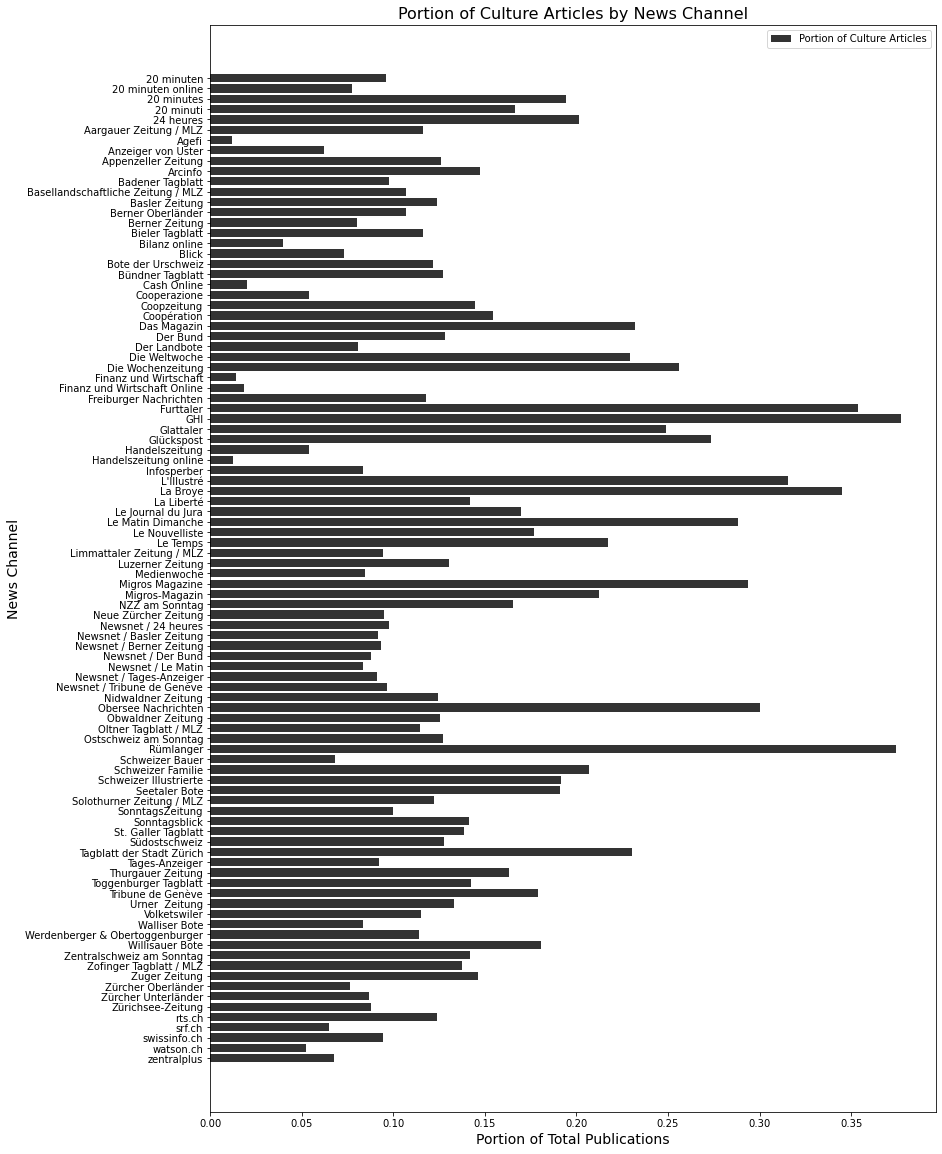

In [82]:
# culture
show_COVID_topic_publication_portion_by_channels(articles, 'culture', 'Culture')

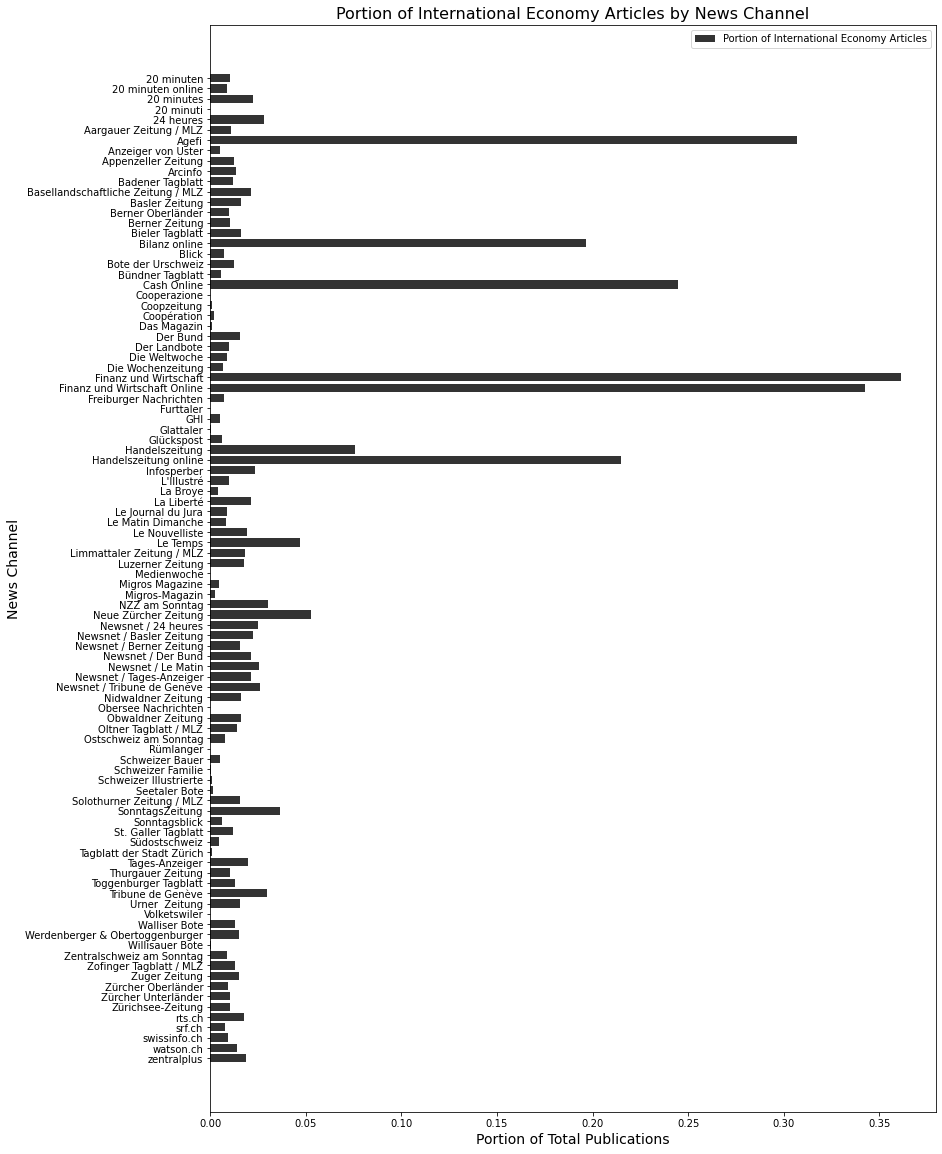

In [83]:
# economy_international
show_COVID_topic_publication_portion_by_channels(articles, 'economy_international', 'International Economy')

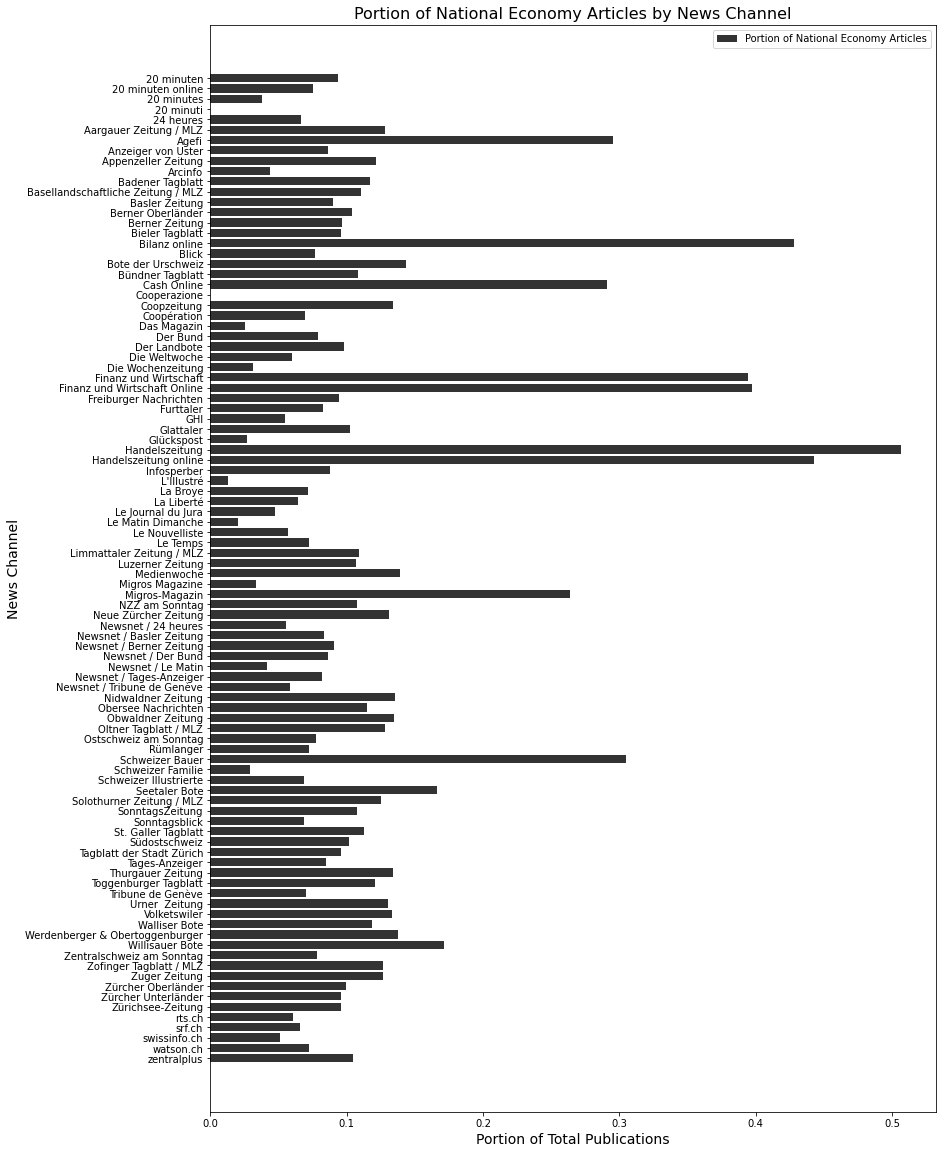

In [84]:
# economy_national
show_COVID_topic_publication_portion_by_channels(articles, 'economy_national', 'National Economy')

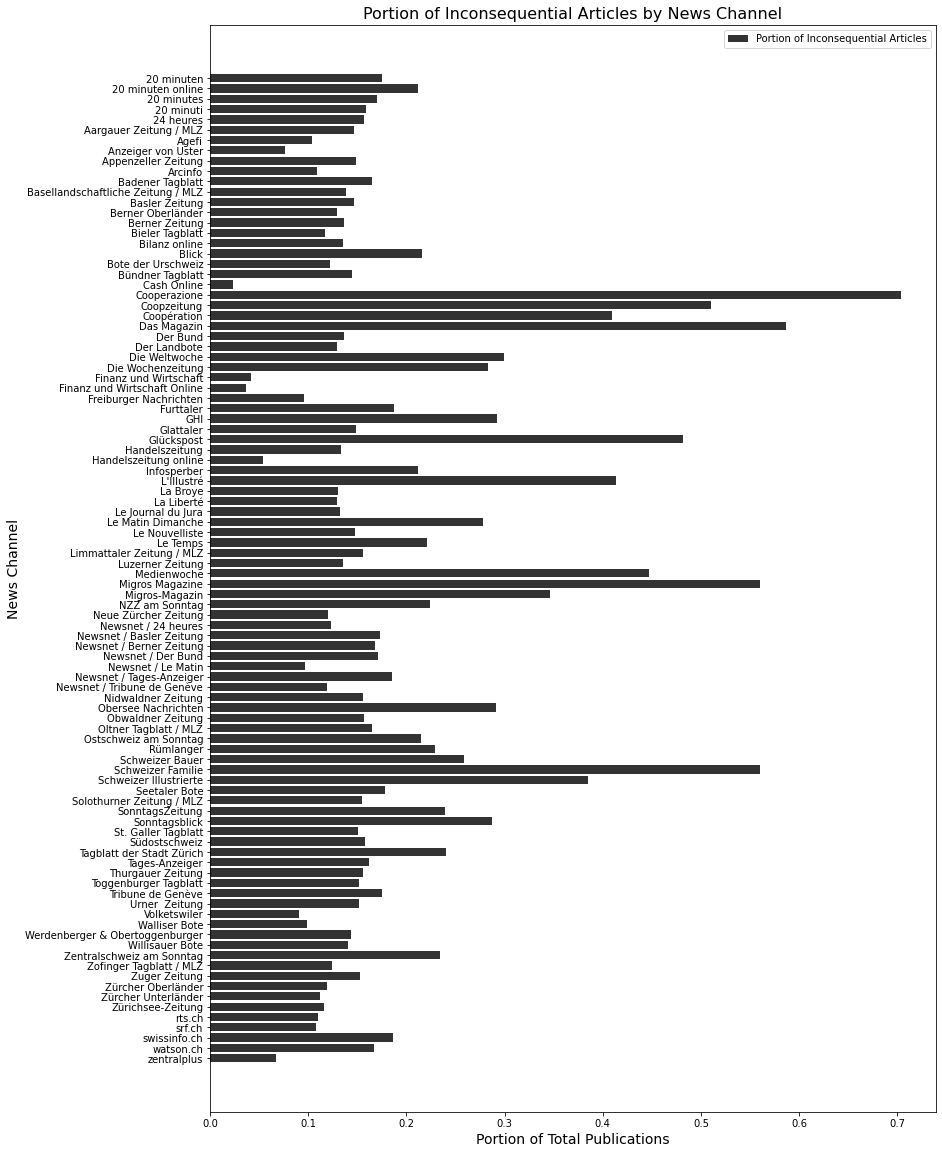

In [85]:
# inconsequential
show_COVID_topic_publication_portion_by_channels(articles, 'inconsequential', 'Inconsequential')

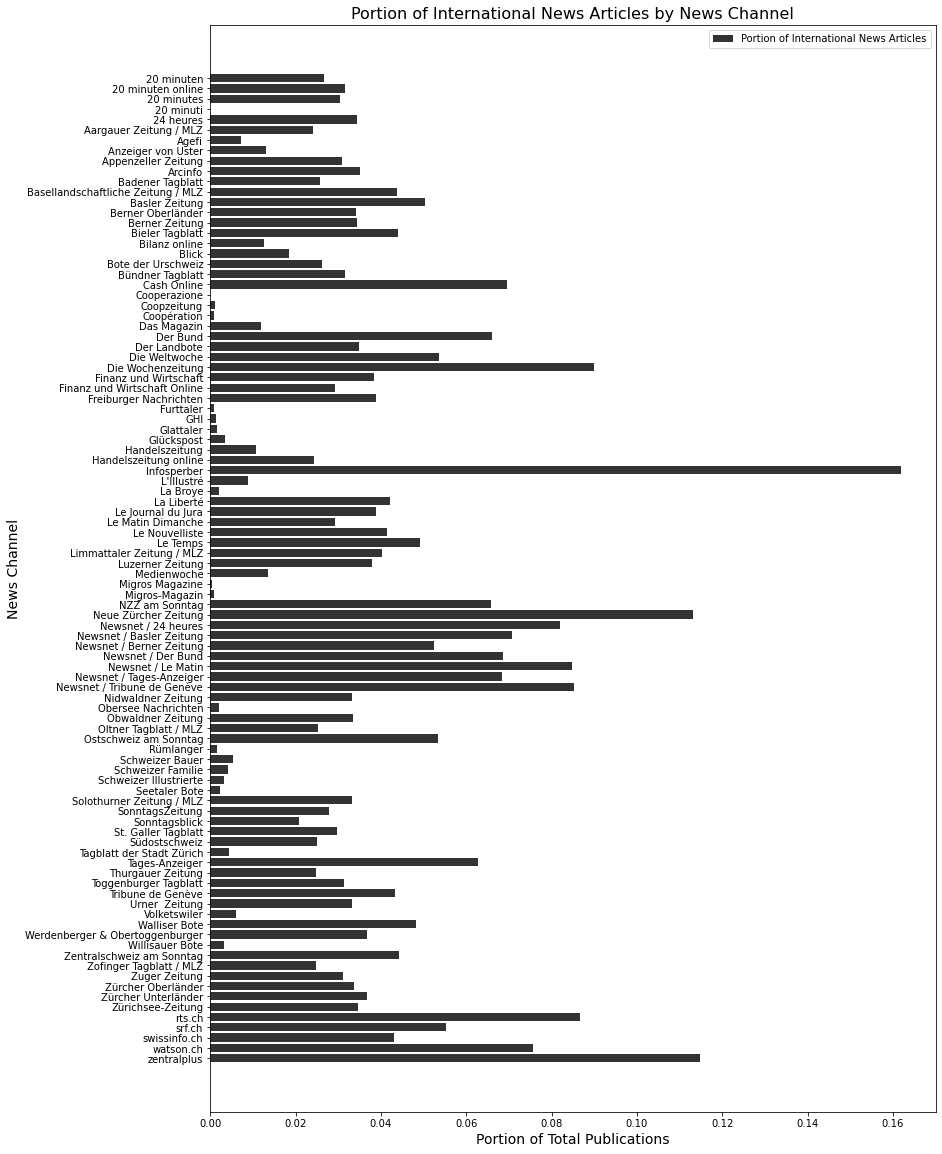

In [86]:
# international_news
show_COVID_topic_publication_portion_by_channels(articles, 'international_news', 'International News')

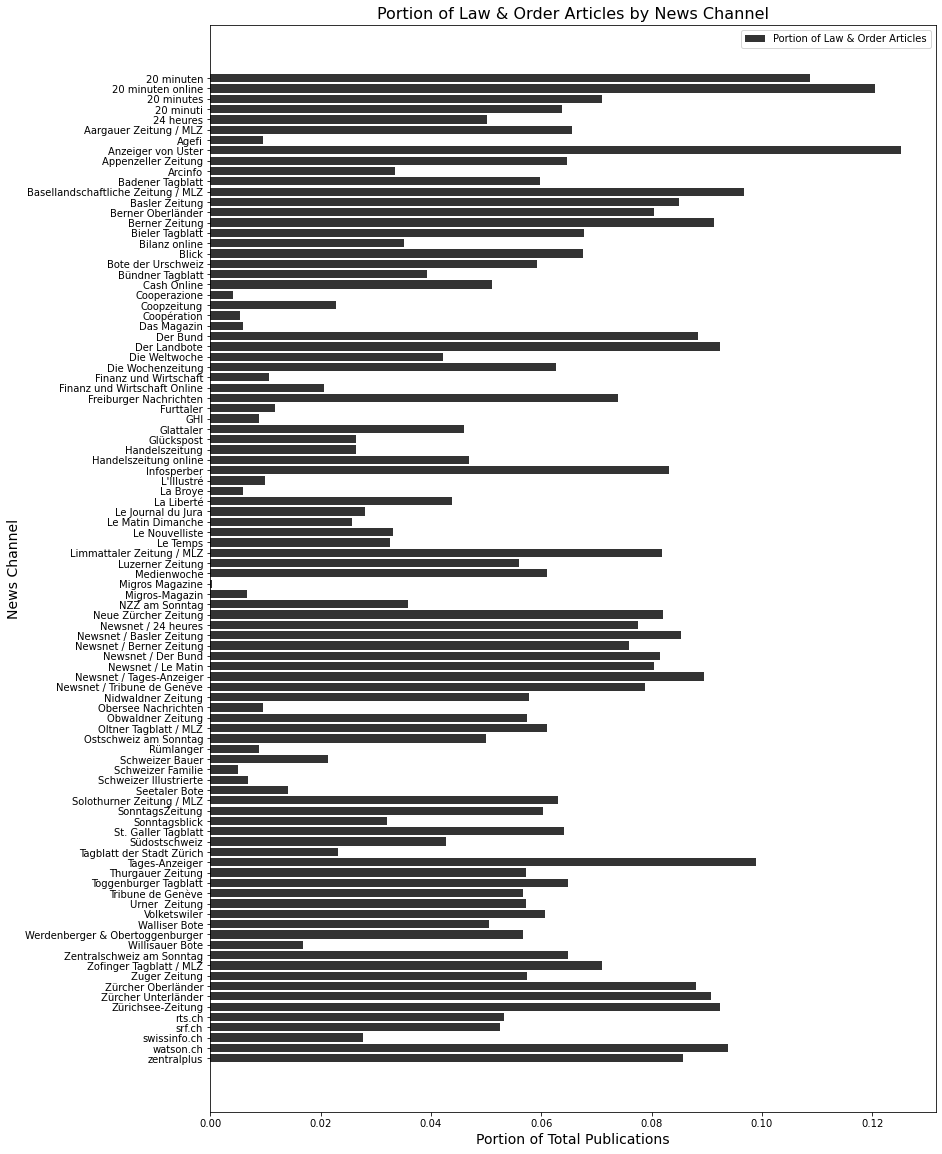

In [87]:
# law_order
show_COVID_topic_publication_portion_by_channels(articles, 'law_order', 'Law & Order')

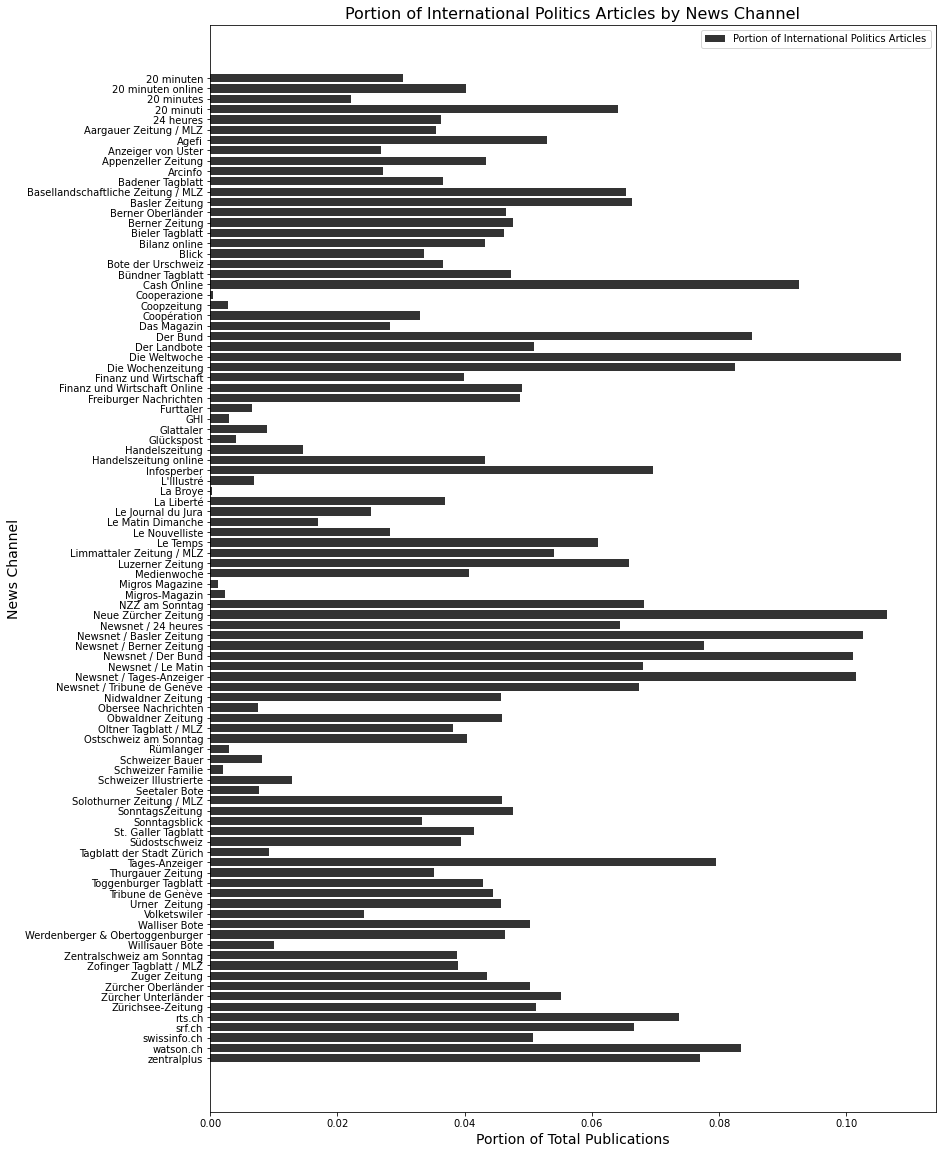

In [88]:
# politics_international
show_COVID_topic_publication_portion_by_channels(articles, 'politics_international', 'International Politics')

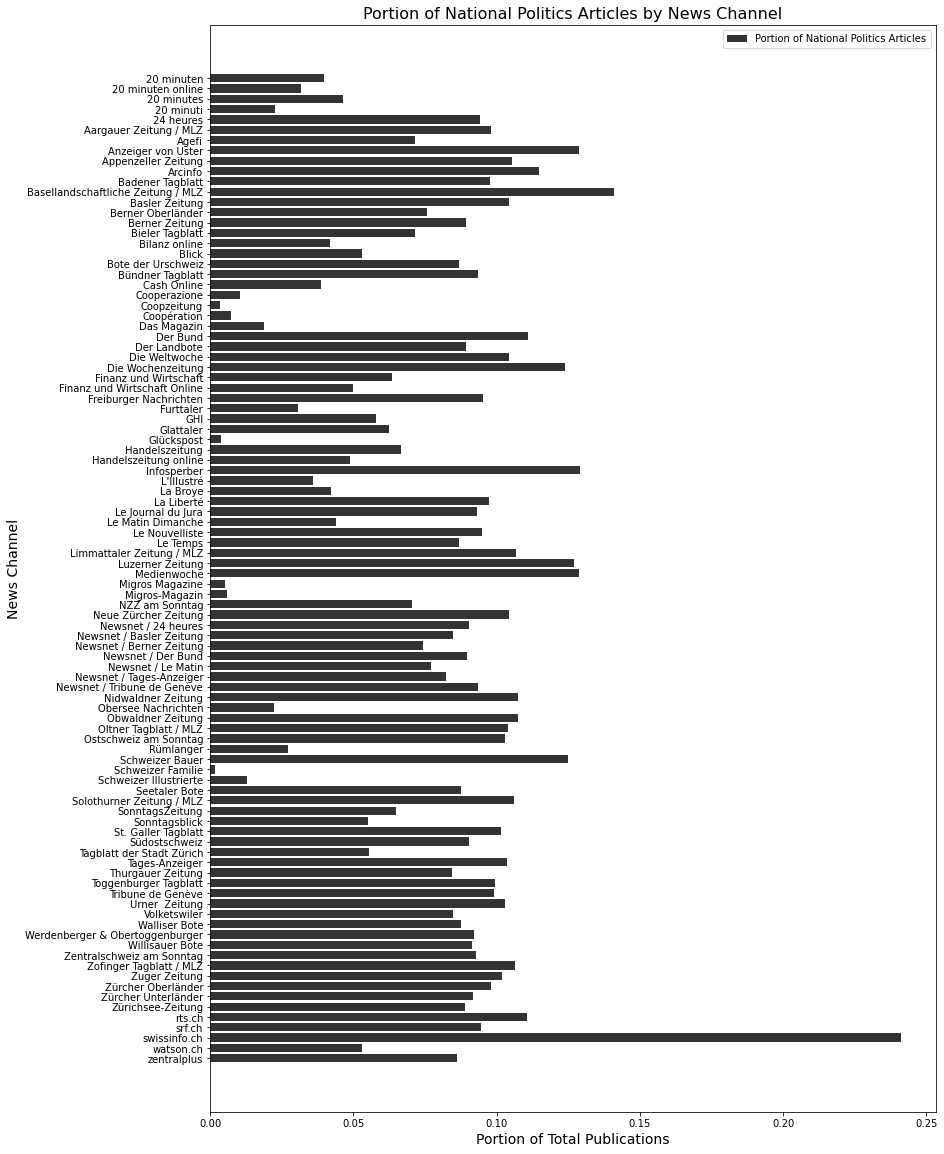

In [89]:
# politics_national
show_COVID_topic_publication_portion_by_channels(articles, 'politics_national', 'National Politics')

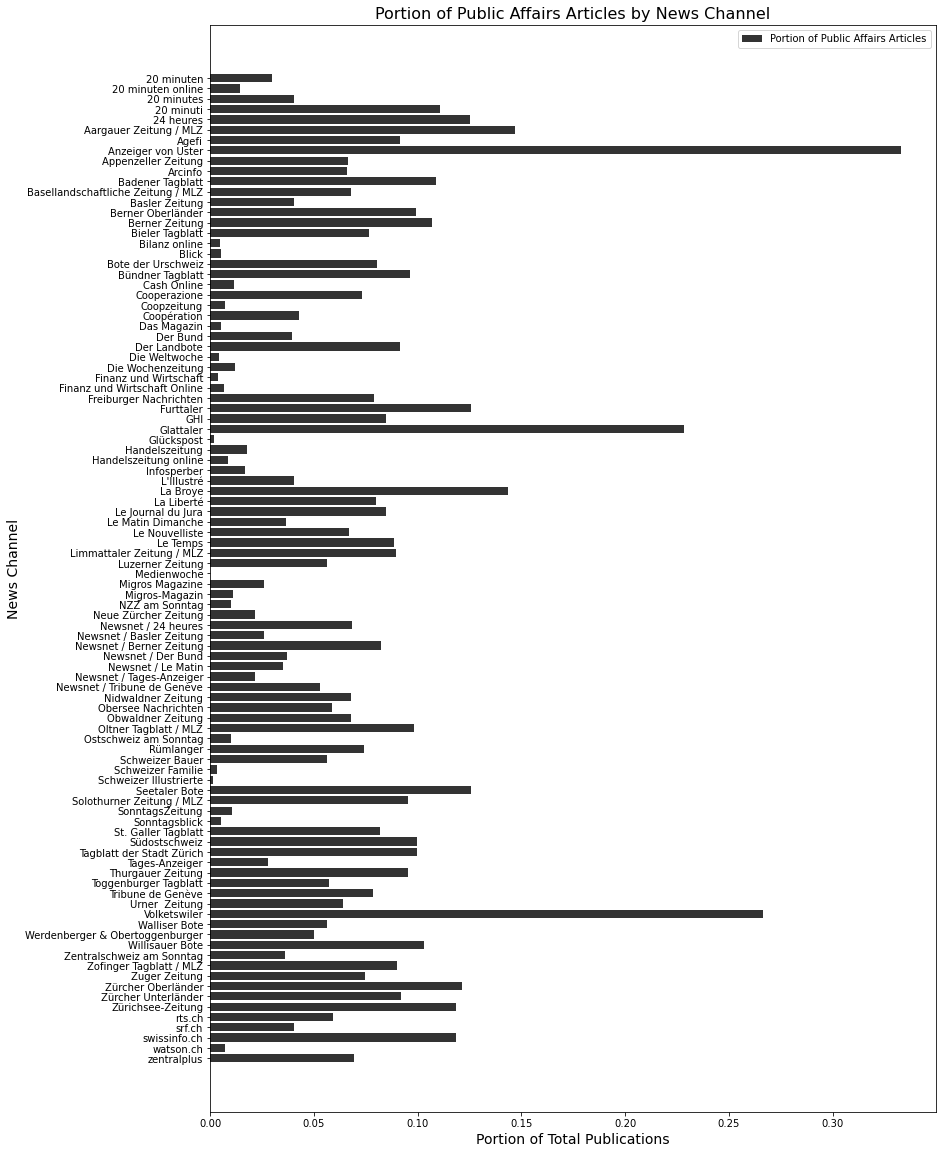

In [90]:
# public_affairs
show_COVID_topic_publication_portion_by_channels(articles, 'public_affairs', 'Public Affairs')

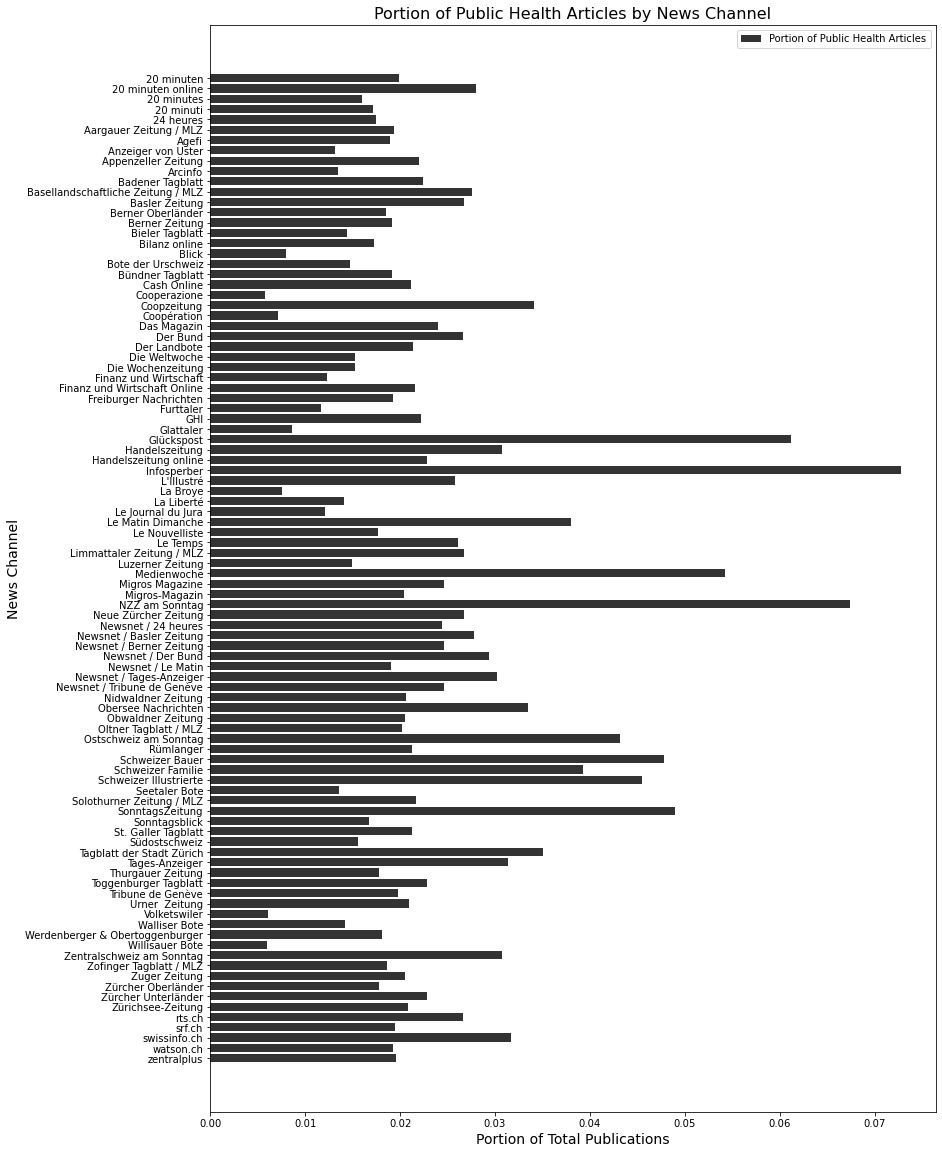

In [91]:
# public_health
show_COVID_topic_publication_portion_by_channels(articles, 'public_health', 'Public Health')

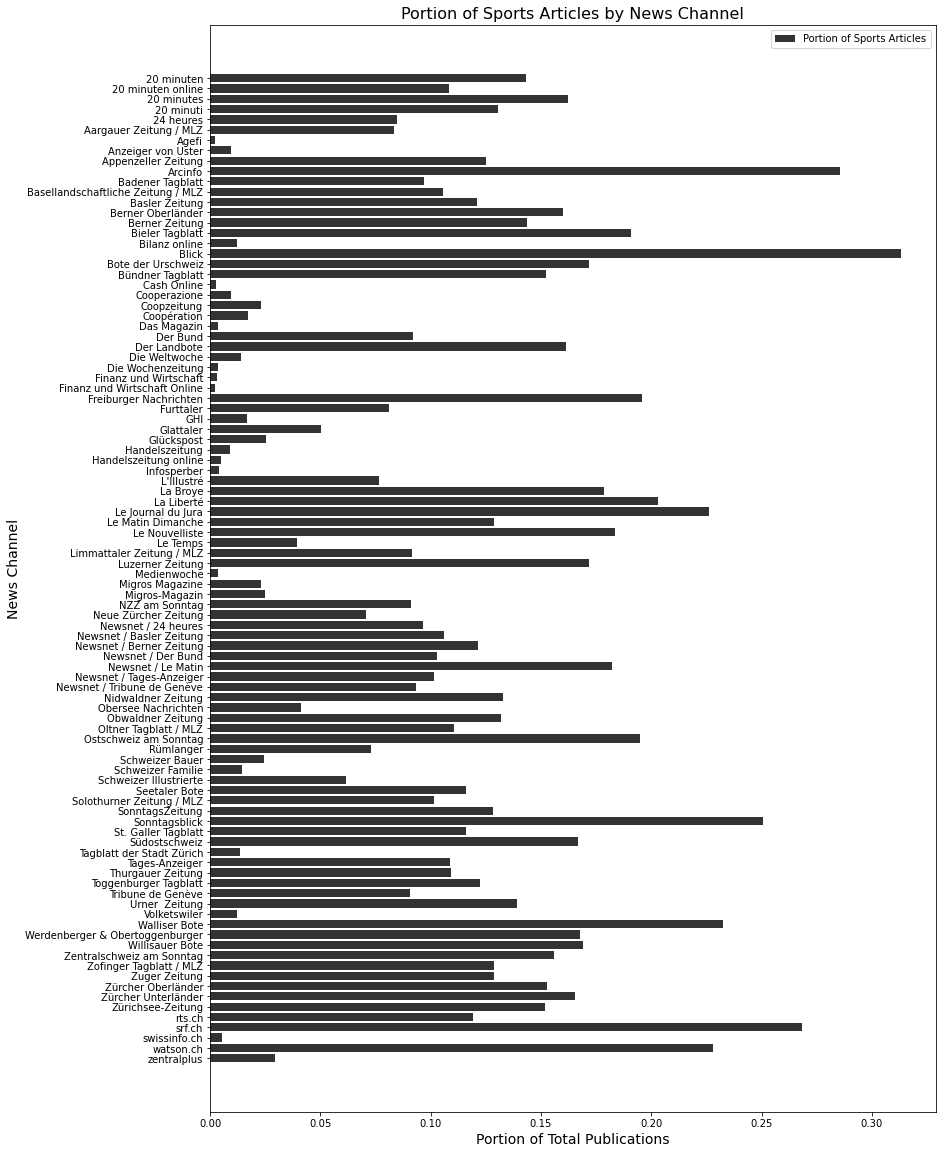

In [92]:
# sports
show_COVID_topic_publication_portion_by_channels(articles, 'sports', 'Sports')

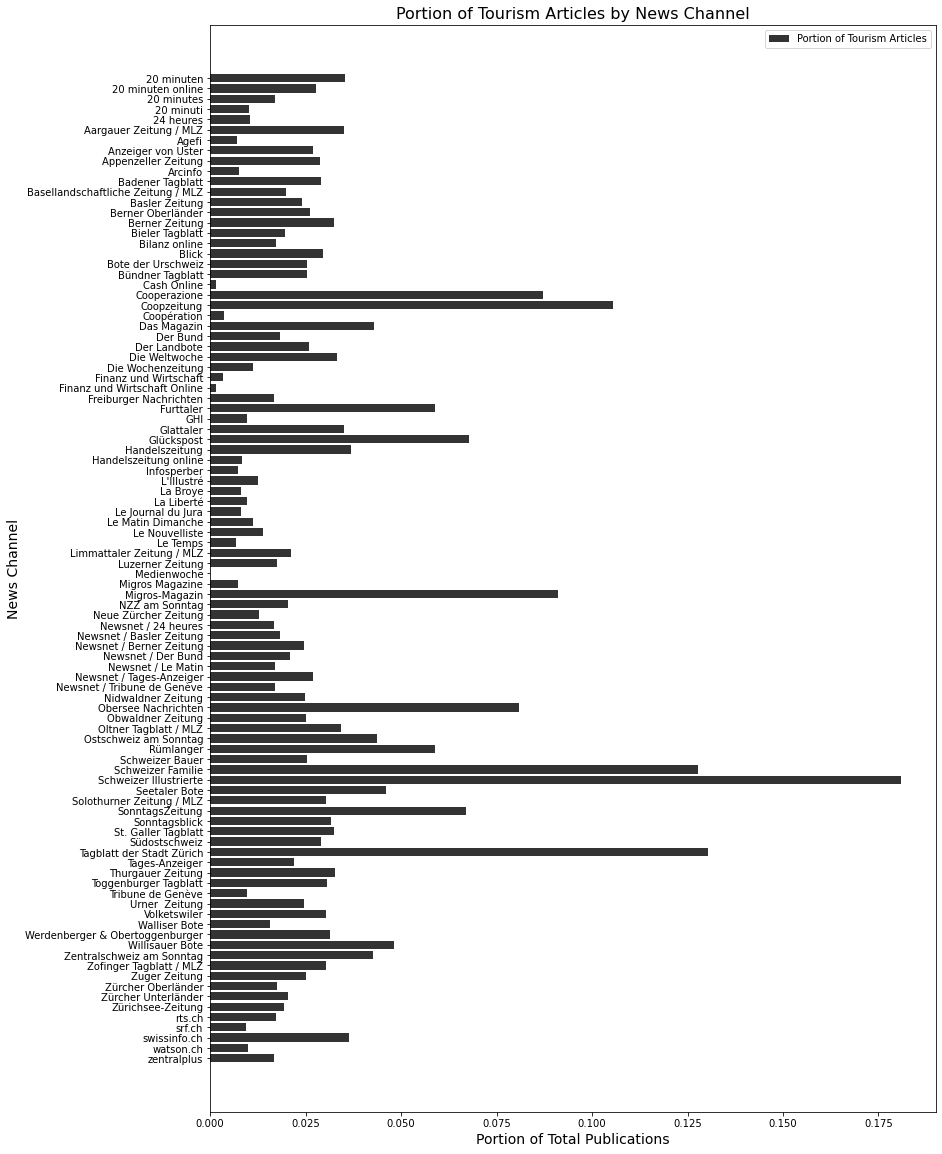

In [93]:
# tourism
show_COVID_topic_publication_portion_by_channels(articles, 'tourism', 'Tourism')

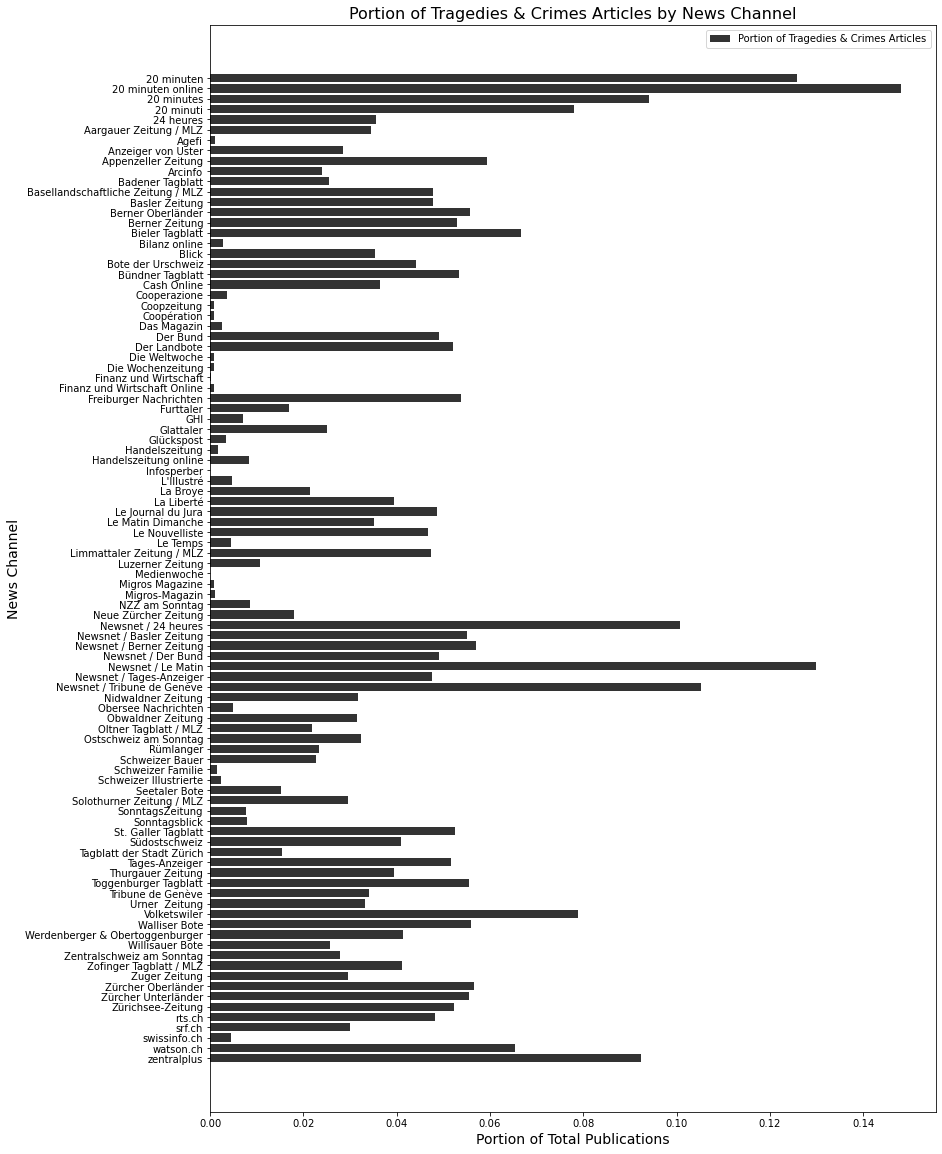

In [94]:
# tragedies_crimes
show_COVID_topic_publication_portion_by_channels(articles, 'tragedies_crimes', 'Tragedies & Crimes')

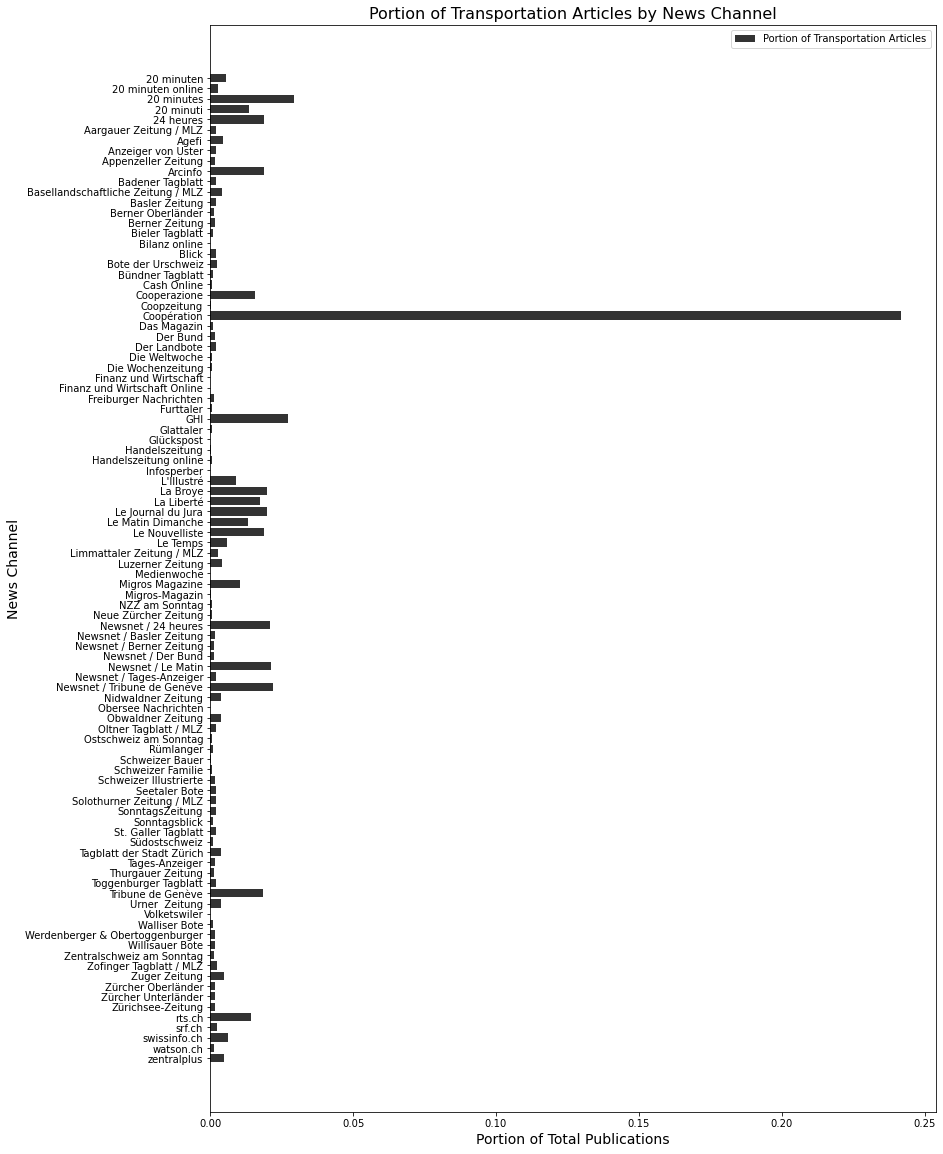

In [95]:
# transportation
show_COVID_topic_publication_portion_by_channels(articles, 'transportation', 'Transportation')

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
4. COVID specific Statistics and Graphs
</h2>
</div>

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
4.1 Covid Metrics (Daily Cases and Deaths)
</h3>
</div>

In [96]:
# Read in the readership data
covid_metrics = pd.read_csv("Corona_data/Cases_switzerland/COVID19_Fallzahlen_CH_total.csv")
# Remove unneeded columns
covid_metrics = covid_metrics[['date', 'abbreviation_canton_and_fl', 'ncumul_tested', 'ncumul_conf', 'ncumul_deceased']]
# Rename the columns as desired
covid_metrics.rename(columns = {'date': 'publication_date', 'abbreviation_canton_and_fl': 'canton', 'ncumul_deceased': 'ncumul_deaths'}, inplace = True)
# Transform publication_date into a daily date type
covid_metrics.publication_date = pd.to_datetime(covid_metrics.publication_date, yearfirst = True).astype('datetime64[D]')
# Remove rows with entries concerning the country Fürstentum Lichtenstein (LI/FL), since only Switzerland is considered within the analysis
covid_metrics = covid_metrics.loc[np.logical_not(covid_metrics['canton'] == 'FL')]
# The column ncumul_tested appears to contain mostly missing values (10869 out of 11074). Thus it does not add much informative value and therefore is dropped
covid_metrics.drop('ncumul_tested', axis = 1, inplace = True)
## Missing-value imputation
# First sort the dataframe according to canton and publication date
covid_metrics.sort_values(['canton', 'publication_date'], ignore_index = True, inplace = True)
# For each canton, fill the missing values in the columns ncumul_conf and ncumul_deaths with the most recently preceding non-missing value
for canton in np.unique(covid_metrics['canton']):
    covid_metrics.loc[covid_metrics['canton'] == canton, 'ncumul_conf']   = covid_metrics.loc[covid_metrics['canton'] == canton, 'ncumul_conf'].fillna(method = 'ffill')
    covid_metrics.loc[covid_metrics['canton'] == canton, 'ncumul_deaths'] = covid_metrics.loc[covid_metrics['canton'] == canton, 'ncumul_deaths'].fillna(method = 'ffill')
# The remaining missing values appear to occur only before the first instances were reported. Thus, we simply replace them with 0
covid_metrics.fillna(0, inplace = True)
## Calculate the daily new instances
# Get the number of daily confirmed covid cases
covid_metrics['new_conf'] = covid_metrics.groupby(['canton'])['ncumul_conf'].diff().values
covid_metrics.loc[covid_metrics['new_conf'].isna(), 'new_conf'] = covid_metrics.loc[covid_metrics['new_conf'].isna(), 'ncumul_conf']
# Get the number of daily covid deaths
covid_metrics['new_deaths'] = covid_metrics.groupby(['canton'])['ncumul_deaths'].diff().values
covid_metrics.loc[covid_metrics['new_deaths'].isna(), 'new_deaths'] = covid_metrics.loc[covid_metrics['new_deaths'].isna(), 'ncumul_deaths']
# Aggregate the metrics to get the corresponding values on a national level and add them to the covid_metrics dataframe
national_covid_metrics = covid_metrics.groupby(['publication_date'])['ncumul_conf', 'ncumul_deaths', 'new_conf', 'new_deaths'].sum().reset_index()
national_covid_metrics['canton'] = np.repeat('CH', national_covid_metrics.shape[0])
national_covid_metrics = national_covid_metrics[['publication_date', 'canton', 'ncumul_conf', 'ncumul_deaths', 'new_conf', 'new_deaths']]
covid_metrics = pd.concat([covid_metrics, national_covid_metrics], ignore_index = True)
# Define functions to calculate the 7-day-average of the metrics of interest
def seven_day_avg_conf(data):
    '''
    Takes the covid_metrics DataFrame created above and adds a column containing the 7-day-average of the daily new covid cases
    '''
    temp_array = np.array(data['new_conf'].shift(0).fillna(0))
    for i in range(7)[1:]:
        temp_array = np.vstack([temp_array, np.array(data['new_conf'].shift(i).fillna(0))])
    data['7d_avg_conf'] = temp_array.mean(0)
    return data

def seven_day_avg_deaths(data):
    '''
    Takes the covid_metrics DataFrame created above and adds a column containing the 7-day-average of the daily covid deaths
    '''
    temp_array = np.array(data['new_deaths'].shift(0).fillna(0))
    for i in range(7)[1:]:
        temp_array = np.vstack([temp_array, np.array(data['new_deaths'].shift(i).fillna(0))])
    data['7d_avg_deaths'] = temp_array.mean(0)
    return data
## Apply the previously defined functions for each canton separately
# 7-day-average of daily new covid cases
covid_metrics = covid_metrics.groupby(['canton']).apply(seven_day_avg_conf)
# 7-day-average of daily covid deaths
covid_metrics = covid_metrics.groupby(['canton']).apply(seven_day_avg_deaths)
# Read in the population data from 2019 (since this is the most recent year for which the population data is available)
population_by_canton = pd.read_csv("Corona_data/CH-Ständige_Wohnbevölkerung_nach_Kanton_2019.csv", sep = ';')
# Merge the covid_metrics dataframe with the population dataframe according to the canton
covid_metrics = covid_metrics.merge(population_by_canton, how = 'left', on = 'canton', validate = "m:1")
## Create columns containing the metrics per million population
# daily new covid cases per million population
covid_metrics['new_conf_pm'] =      covid_metrics['new_conf'].values /      (covid_metrics['canton_population'].values / 10**6)
# daily covid deaths per million population
covid_metrics['new_deaths_pm'] =    covid_metrics['new_deaths'].values /    (covid_metrics['canton_population'].values / 10**6)
# 7-day-average of daily new covid cases per million population
covid_metrics['7d_avg_conf_pm'] =   covid_metrics['7d_avg_conf'].values /   (covid_metrics['canton_population'].values / 10**6)
# 7-day-average of daily covid deaths per million population
covid_metrics['7d_avg_deaths_pm'] = covid_metrics['7d_avg_deaths'].values / (covid_metrics['canton_population'].values / 10**6)
# Take a look at the resulting dataframe
covid_metrics

publication_date canton  ncumul_conf  ncumul_deaths  new_conf  \
0           2020-02-26     AG          1.0            0.0       1.0   
1           2020-02-27     AG          1.0            0.0       0.0   
2           2020-02-28     AG          1.0            0.0       0.0   
3           2020-02-29     AG          3.0            0.0       2.0   
4           2020-03-01     AG          4.0            0.0       1.0   
...                ...    ...          ...            ...       ...   
11585       2021-05-30     CH     651800.0        10310.0     325.0   
11586       2021-05-31     CH     684701.0        10812.0     783.0   
11587       2021-06-01     CH     685345.0        10812.0     644.0   
11588       2021-06-02     CH     647981.0        10028.0     496.0   
11589       2021-06-03     CH     288790.0         4646.0     176.0   

       new_deaths  7d_avg_conf  7d_avg_deaths  canton_population  new_conf_pm  \
0             0.0     0.142857       0.000000             677102     1.476882   
1             0.0     0.142857       0.000000             677102     0.000000   
2             0.0     0.142857       0.000000             677102     0.000000   
3             0.0     0.428571       0.000000             677102     2.953765   
4             0.0     0.571429       0.000000             677102     1.476882   
...           ...          ...            ...                ...          ...   
11585         0.0   722.285714       3.428571            8438822    38.512484   
11586         1.0   766.571429       3.000000            8438822    92.785462   
11587         0.0   698.000000       2.285714            8438822    76.313969   
11588         0.0   633.857143       2.285714            8438822    58.775976   
11589         2.0   530.428571       1.571429            8438822    20.855992   

       new_deaths_pm  7d_avg_conf_pm  7d_avg_deaths_pm  
0             0.0000        0.210983          0.000000  
1             0.0000        0.210983          0.000000  
2             0.0000        0.210983          0.000000  
3             0.0000        0.632950          0.000000  
4             0.0000        0.843933          0.000000  
...              ...             ...               ...  
11585         0.0000       85.590822          0.406286  
11586         0.1185       90.838677          0.355500  
11587         0.0000       82.712966          0.270857  
11588         0.0000       75.112041          0.270857  
11589         0.2370       62.855760          0.186214  

[11590 rows x 13 columns]

In [97]:
# Define a function to display the development of the constructed covid metrics
def show_covid_metric_development(covid_metrics, metric, metric_fulltext):
    # Reduce the dataframe to the nationally aggregated values
    covid_metrics = covid_metrics.loc[covid_metrics['canton'] == 'CH']
    # Show the development of the weekly average polarity scores of the topic specific articles
    fig, ax1 = plt.subplots(figsize = (10, 8))
    # Set up the plot to show the development of the chosen covid metric
    ax1.plot(covid_metrics['publication_date'], covid_metrics[metric], color = 'black', linewidth = 1, alpha = 1, linestyle = 'solid', label = metric_fulltext)
    ax1.set_title('Development of '+metric_fulltext+' in Switzerland over Time')
    ax1.set_xlabel("Date")
    ax1.set_ylabel('Daily instances')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Create a legend and display the plot
    fig.legend()
    plt.show()

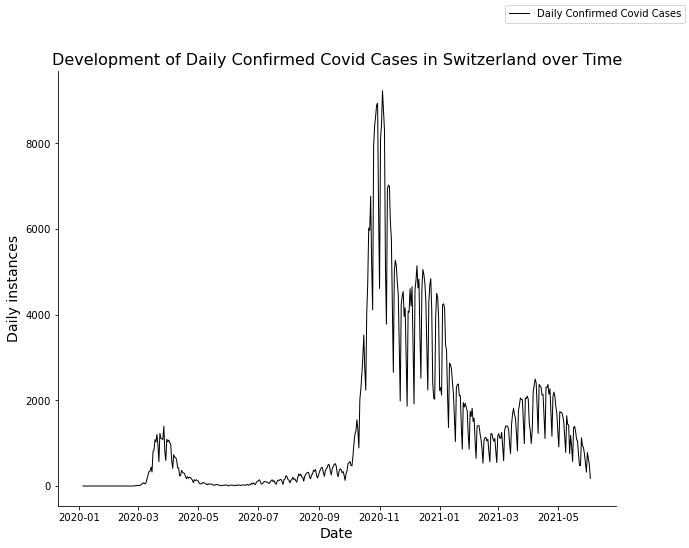

In [99]:
# Display the development of the daily confirmed covid cases over time
show_covid_metric_development(covid_metrics, 'new_conf', 'Daily Confirmed Covid Cases')

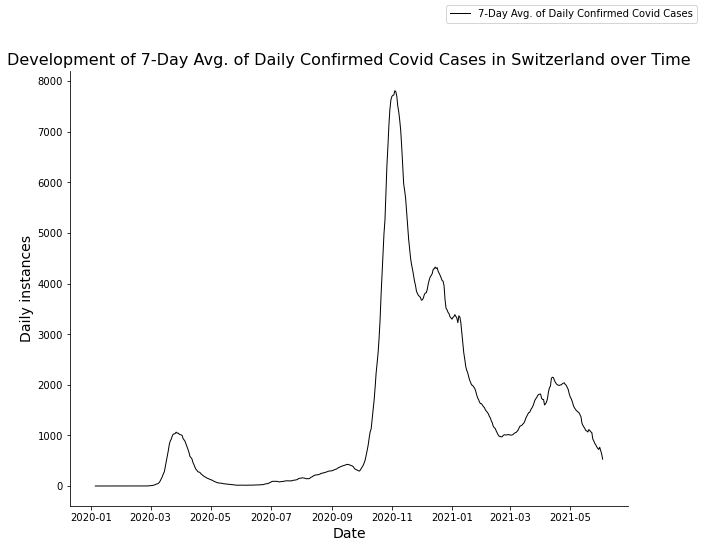

In [100]:
# Display the development of the 7-day average of daily confirmed covid cases over time
show_covid_metric_development(covid_metrics, '7d_avg_conf', '7-Day Avg. of Daily Confirmed Covid Cases')

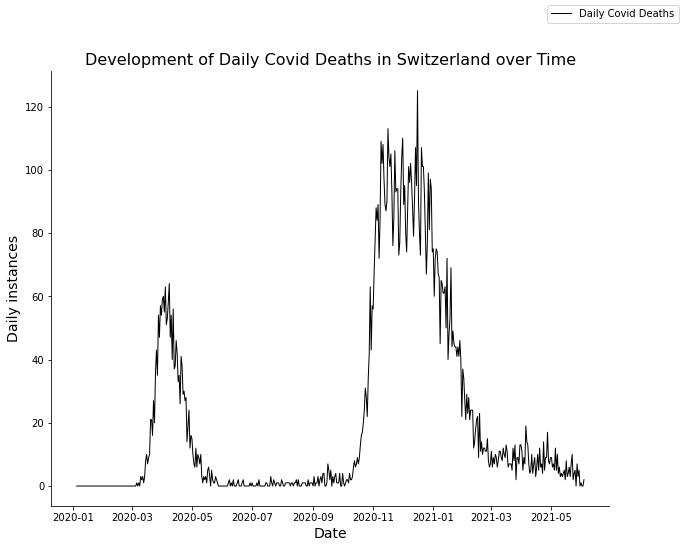

In [101]:
# Display the development of the daily covid deaths over time
show_covid_metric_development(covid_metrics, 'new_deaths', 'Daily Covid Deaths')

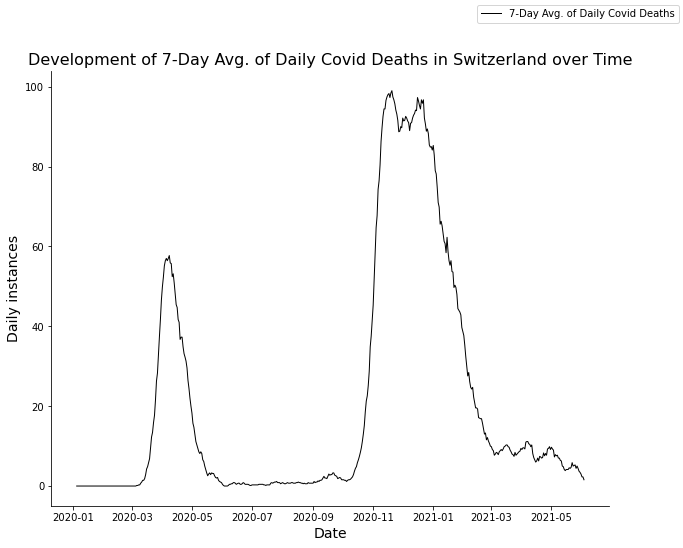

In [102]:
# Display the development of the 7-day average of daily covid deaths over time
show_covid_metric_development(covid_metrics, '7d_avg_deaths', '7-Day Avg. of Daily Covid Deaths')

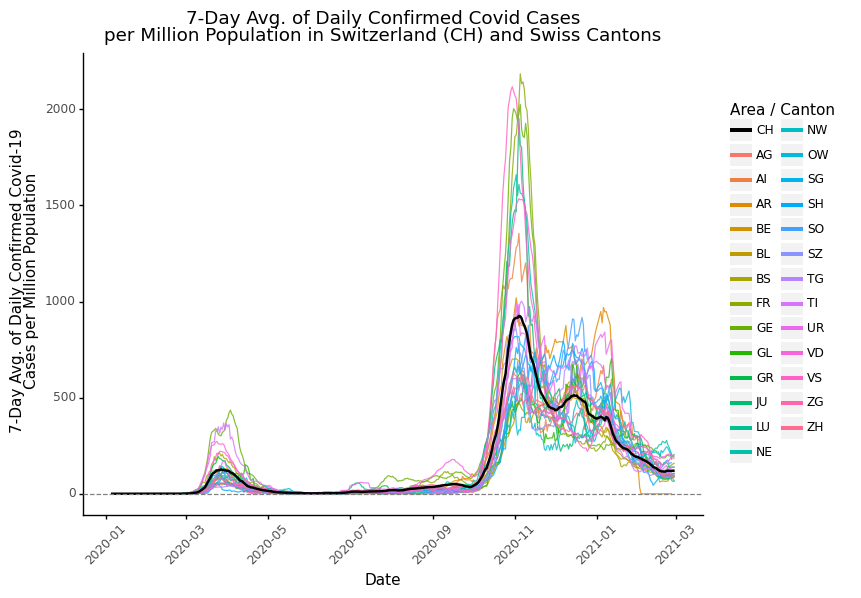

<ggplot: (-9223371893474725924)>

In [103]:
# Display the 7-Day Avg. of Daily Confirmed Covid Cases per Million Population in Switzerland (CH) and Swiss Cantons
(
 ggplot() +
    geom_line(data = covid_metrics.loc[np.logical_and(np.logical_not(covid_metrics['canton'] == 'CH'), covid_metrics['publication_date'] < pd.to_datetime("2021-03-01", yearfirst = True))], 
              mapping = aes(x = 'publication_date', y = '7d_avg_conf_pm', color = 'canton'), size = 0.5, alpha = 0.8) +
    geom_line(data = covid_metrics.loc[np.logical_and(covid_metrics['canton'] == 'CH', covid_metrics['publication_date'] < pd.to_datetime("2021-03-01", yearfirst = True))], 
              mapping = aes(x = 'publication_date', y = '7d_avg_conf_pm', color = 'canton'), size = 1) +
    geom_hline(yintercept = 0, color = 'grey', linetype = 'dashed') +
    scale_color_manual(name = 'Area / Canton', breaks = ["CH", 'AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 
                                                               'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VD', 'VS', 'ZG', 'ZH'], 
                       values =["black", "#F8766D", "#EE8043", "#E18A00", "#D19300", "#BE9C00", "#A8A400", "#8CAB00", "#68B100", "#24B700", "#00BB49", "#00BE70", "#00C090", "#00C1AB", 
                                         "#00BFC4", "#00BBDA", "#00B5ED", "#00ACFC", "#42A0FF", "#8B93FF", "#B684FF", "#D575FE", "#EB69F0", "#F962DD", "#FF61C6", "#FF65AC", "#FF6C91"]) +
    scale_x_date(date_labels = "%Y-%m") +
    theme(figure_size = (8, 6),
          panel_background = element_rect(fill = 'white', colour = 'black'), 
          axis_text_x = element_text(angle = 45),
          panel_border = None,
          axis_line = element_line(color = 'black'),
          plot_title = element_text(hjust = 0.5)) + 
    ggtitle("7-Day Avg. of Daily Confirmed Covid Cases\nper Million Population in Switzerland (CH) and Swiss Cantons") +
    xlab("Date") +
    ylab("7-Day Avg. of Daily Confirmed Covid-19\nCases per Million Population")
)

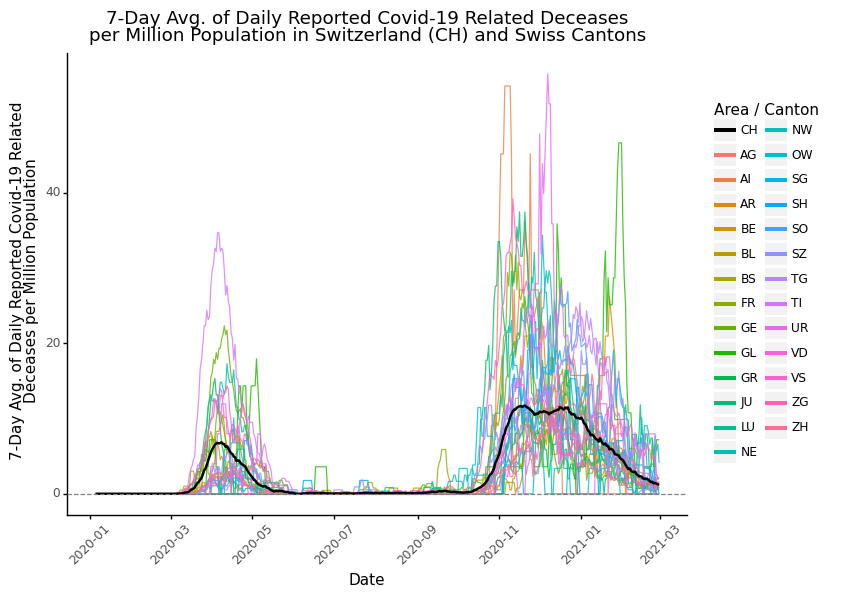

<ggplot: (-9223371893474440792)>

In [104]:
# Display the 7-Day Avg. of Daily Reported Covid-19 Related Deceases per Million Population in Switzerland (CH) and Swiss Cantons
(
 ggplot() +
    geom_line(data = covid_metrics.loc[np.logical_and(np.logical_not(covid_metrics['canton'] == 'CH'), covid_metrics['publication_date'] < pd.to_datetime("2021-03-01", yearfirst = True))], 
              mapping = aes(x = 'publication_date', y = '7d_avg_deaths_pm', color = 'canton'), size = 0.5, alpha = 0.8) +
    geom_line(data = covid_metrics.loc[np.logical_and(covid_metrics['canton'] == 'CH', covid_metrics['publication_date'] < pd.to_datetime("2021-03-01", yearfirst = True))], 
              mapping = aes(x = 'publication_date', y = '7d_avg_deaths_pm', color = 'canton'), size = 1) +
    geom_hline(yintercept = 0, color = 'grey', linetype = 'dashed') +
    scale_color_manual(name = 'Area / Canton', breaks = ["CH", 'AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 
                                                               'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VD', 'VS', 'ZG', 'ZH'], 
                       values =["black", "#F8766D", "#EE8043", "#E18A00", "#D19300", "#BE9C00", "#A8A400", "#8CAB00", "#68B100", "#24B700", "#00BB49", "#00BE70", "#00C090", "#00C1AB", 
                                         "#00BFC4", "#00BBDA", "#00B5ED", "#00ACFC", "#42A0FF", "#8B93FF", "#B684FF", "#D575FE", "#EB69F0", "#F962DD", "#FF61C6", "#FF65AC", "#FF6C91"]) +
    scale_x_date(date_labels = "%Y-%m") +
    theme(figure_size = (8, 6),
          panel_background = element_rect(fill = 'white', colour = 'black'), 
          axis_text_x = element_text(angle = 45),
          panel_border = None,
          axis_line = element_line(color = 'black'),
          plot_title = element_text(hjust = 0.5)) + 
    ggtitle("7-Day Avg. of Daily Reported Covid-19 Related Deceases\nper Million Population in Switzerland (CH) and Swiss Cantons") +
    xlab("Date") +
    ylab("7-Day Avg. of Daily Reported Covid-19 Related\nDeceases per Million Population")  
)

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
4.2 Covid Stringency Index (KOFSPI)
</h3>
</div>

In [105]:
# Read in the Swiss Stringency Index data
stringency = pd.read_csv("Corona_data/Stringency_index_switzerland/kof_data_export.csv")
## Rename the columns as desired
# Get a dictionary containing the desired columnnames
columnnames = {}
columnnames['date'] = 'publication_date'
for i in range(1,len(stringency.columns)):
    columnnames[stringency.columns[i]] = stringency.columns[i][18:20]
# Rename the columns
stringency.rename(columns = columnnames, inplace = True)
# Transform the column publication_date into a date type
stringency.publication_date = pd.to_datetime(stringency.publication_date, yearfirst = True).astype('datetime64[D]')
# Take a look at the resulting dataframe
stringency

publication_date         ag         ai         ar         be         bl  \
0         2020-01-01   0.000000   0.000000   0.000000   0.000000   0.000000   
1         2020-01-02   0.000000   0.000000   0.000000   0.000000   0.000000   
2         2020-01-03   0.000000   0.000000   0.000000   0.000000   0.000000   
3         2020-01-04   0.000000   0.000000   0.000000   0.000000   0.000000   
4         2020-01-05   0.000000   0.000000   0.000000   0.000000   0.000000   
..               ...        ...        ...        ...        ...        ...   
478       2021-04-23  55.833332  55.833332  55.833332  55.833332  55.833332   
479       2021-04-24  55.833332  55.833332  55.833332  55.833332  55.833332   
480       2021-04-25  55.833332  55.833332  55.833332  55.833332  55.833332   
481       2021-04-26  55.833332  55.833332  55.833332  55.833332  55.833332   
482       2021-04-27  55.833332  55.833332  55.833332  55.833332  55.833332   

            bs         ch         fr         ge  ...         sh         so  \
0     0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
1     0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
2     0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
3     0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
4     0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
..         ...        ...        ...        ...  ...        ...        ...   
478  55.833332  55.833332  55.833332  55.833332  ...  55.833332  55.833332   
479  55.833332  55.833332  55.833332  55.833332  ...  55.833332  55.833332   
480  55.833332  55.833332  55.833332  55.833332  ...  55.833332  55.833332   
481  55.833332  55.833332  55.833332  55.833332  ...  55.833332  55.833332   
482  55.833332  55.833332  55.833332  55.833332  ...  55.833332  55.833332   

            sz         tg         ti         ur         vd         vs  \
0     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
2     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
3     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
..         ...        ...        ...        ...        ...        ...   
478  55.833332  55.833332  55.833332  55.833332  55.833332  55.833332   
479  55.833332  55.833332  55.833332  55.833332  55.833332  55.833332   
480  55.833332  55.833332  55.833332  55.833332  55.833332  55.833332   
481  55.833332  55.833332  55.833332  55.833332  55.833332  55.833332   
482  55.833332  55.833332  55.833332  55.833332  55.833332  55.833332   

            zg         zh  
0     0.000000   0.000000  
1     0.000000   0.000000  
2     0.000000   0.000000  
3     0.000000   0.000000  
4     0.000000   0.000000  
..         ...        ...  
478  55.833332  55.833332  
479  55.833332  55.833332  
480  55.833332  55.833332  
481  55.833332  55.833332  
482  55.833332  55.833332  

[483 rows x 28 columns]

In [106]:
# Create a dataframe which can be used to plot the stringency index conveniently
stringency_plot = stringency.iloc[:,[0,1]].copy()
stringency_plot.rename(columns = {stringency_plot.columns[1]: 'stridx'}, inplace = True)
stringency_plot['canton'] = stringency.columns[1].upper()
for i in np.arange(2,28):
    stringency_temp = stringency.iloc[:,[0,i]].copy()
    stringency_temp.rename(columns = {stringency_temp.columns[1]: 'stridx'}, inplace = True)
    stringency_temp['canton'] = stringency.columns[i].upper()
    stringency_plot = pd.concat([stringency_plot, stringency_temp], ignore_index = True)
stringency_plot

publication_date     stridx canton
0           2020-01-01   0.000000     AG
1           2020-01-02   0.000000     AG
2           2020-01-03   0.000000     AG
3           2020-01-04   0.000000     AG
4           2020-01-05   0.000000     AG
...                ...        ...    ...
13036       2021-04-23  55.833332     ZH
13037       2021-04-24  55.833332     ZH
13038       2021-04-25  55.833332     ZH
13039       2021-04-26  55.833332     ZH
13040       2021-04-27  55.833332     ZH

[13041 rows x 3 columns]

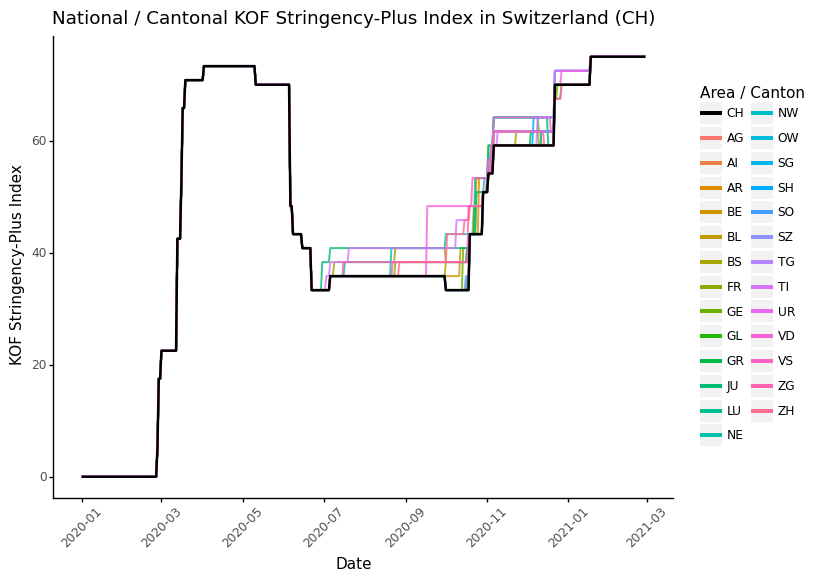

<ggplot: (-9223371893474600088)>

In [107]:
# Display the National / Cantonal KOF Stringency-Plus Index in Switzerland (CH)
(
 ggplot() +
    geom_line(data = stringency_plot.loc[np.logical_and(np.logical_not(stringency_plot['canton'] == 'CH'), stringency_plot['publication_date'] < pd.to_datetime("2021-03-01", yearfirst = True))], 
              mapping = aes(x = 'publication_date', y = 'stridx', color = 'canton'), size = 0.8, alpha = 0.8) +
    geom_line(data = stringency_plot.loc[np.logical_and(stringency_plot['canton'] == 'CH', stringency_plot['publication_date'] < pd.to_datetime("2021-03-01", yearfirst = True))], 
              mapping = aes(x = 'publication_date', y = 'stridx', color = 'canton'), size = 1) +
    scale_color_manual(name = 'Area / Canton', breaks = ["CH", 'AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 
                                                               'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VD', 'VS', 'ZG', 'ZH'], 
                       values =["black", "#F8766D", "#EE8043", "#E18A00", "#D19300", "#BE9C00", "#A8A400", "#8CAB00", "#68B100", "#24B700", "#00BB49", "#00BE70", "#00C090", "#00C1AB", 
                                         "#00BFC4", "#00BBDA", "#00B5ED", "#00ACFC", "#42A0FF", "#8B93FF", "#B684FF", "#D575FE", "#EB69F0", "#F962DD", "#FF61C6", "#FF65AC", "#FF6C91"]) +
    scale_x_date(date_labels = "%Y-%m") +
    theme(figure_size = (8, 6),
          panel_background = element_rect(fill = 'white', colour = 'black'), 
          axis_text_x = element_text(angle = 45),
          panel_border = None,
          axis_line = element_line(color = 'black'),
          plot_title = element_text(hjust = 0.5)) + 
    ggtitle("National / Cantonal KOF Stringency-Plus Index in Switzerland (CH)") +
    xlab("Date") +
    ylab("KOF Stringency-Plus Index")  
)

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
5. Visualization of the Readership data
</h2>
</div>

In [108]:
# Read in the readership data
readership = pd.read_csv("NewsOutlets_metadata/ReadershipByDistrict_2008-2013.csv", sep = ';')
# Remove rows with entries concerning the country LI, since only Switzerland is considered within the analysis
readership = readership.loc[readership['country'] == 'CH']
# Remove rows containing 'CH' in the column 'canton', since those contain the nationally aggregated readership per source (which we do not need here)
readership = readership.loc[np.logical_not(readership['canton'] == 'CH')]
# Remove rows with the entry '(Leer)' in the column newspaper_title, since such entries stand for missing values
readership = readership.loc[np.logical_not(readership['newspaper_title'] == '(Leer)')]
# Remove unneeded columns
readership = readership[['newspaper_title', 'edition', 'canton', 'district_2010', 'year', 'readers_population (in k)']]
# Multiply the column 'readers_population (in k)' by 1000 to get the readers population in proper numbers
readership['readers_population (in k)'] = readership['readers_population (in k)']*1000
# Rename the columns as desired
readership.rename(columns = {'newspaper_title': 'source_long', 'district_2010': 'district', 'readers_population (in k)': 'readers_population'}, inplace = True)

## Unify the entries in the column 'source_long', such that the according labels coincide with the ones in the articles dataframe
# 20 Minuten
readership.loc[np.logical_and(readership['source_long'] == "20minuten", readership['edition'] == 'de'), 'source_long'] = '20 minuten'
readership.loc[np.logical_and(readership['source_long'] == "20minuten", readership['edition'] == 'fr'), 'source_long'] = '20 minutes'
readership.loc[np.logical_and(readership['source_long'] == "20minuten", readership['edition'] == 'it'), 'source_long'] = '20 minuti'
readership.drop(readership.loc[np.logical_and(readership['source_long'] == "20minuten", readership['edition'] == 'complete')].index, inplace = True)
# Migros Magazin
readership.loc[np.logical_and(readership['source_long'] == "migros_magazin", readership['edition'] == 'de'), 'source_long'] = 'Migros-Magazin'
readership.loc[np.logical_and(readership['source_long'] == "migros_magazin", readership['edition'] == 'fr'), 'source_long'] = 'Migros Magazine'
readership.drop(readership.loc[np.logical_and(readership['source_long'] == "migros_magazin", readership['edition'] == 'complete')].index, inplace = True)
# For the remaining source labels, we define a dictionary to replace the source labels from the readership dataframe with the corresponding labels used in the articles dataframe
sourcenames = {'24heures': '24 heures', 'aargauer_zeitung': 'Aargauer Zeitung / MLZ', 'agefi': 'Agefi', 'appenzeller_zeitung': 'Appenzeller Zeitung',
               'basellandschaftliche_zeitung': 'Basellandschaftliche Zeitung / MLZ', 'basler_zeitung': 'Basler Zeitung', 'berner_zeitung': 'Berner Zeitung',
               'bieler_tagblatt': 'Bieler Tagblatt', 'bilanz': 'Bilanz online', 'blick': 'Blick', 'bote_der_urschweiz': 'Bote der Urschweiz', 'cashdaily': 'Cash Online',
               'cooperazione': 'Cooperazione', 'coopration': 'Coopération', 'coopzeitung': 'Coopzeitung', 'das_magazin': 'Das Magazin', 'der_bund': 'Der Bund', 
               'der_landbote': 'Der Landbote', 'die_nordostschweiz': 'Ostschweiz am Sonntag', 'die_suedostschweiz': 'Südostschweiz', 'die_weltwoche': 'Die Weltwoche', 
               'die_wochenzeitung': 'Die Wochenzeitung', 'finanz_und_wirtschaft': 'Finanz und Wirtschaft', 'freiburger_nachrichten': 'Freiburger Nachrichten', 
               'furttaler': 'Furttaler', 'ghi': 'GHI', 'glattaler': 'Glattaler', 'glueckspost': 'Glückspost', 'handelszeitung': 'Handelszeitung', 'la_liberte': 'La Liberté', 
               'le_journal_du_jura': 'Le Journal du Jura', 'le_matin': 'Newsnet / Le Matin', 'le_matin_dimanche': 'Le Matin Dimanche', 'le_nouvelliste': 'Le Nouvelliste', 
               'le_temps': 'Le Temps', 'lillustre': "L'Illustré", 'limmattaler_zeitung': 'Limmattaler Zeitung / MLZ', 'neue_luzerner_zeitung': 'Luzerner Zeitung', 
               'neue_nidwaldner_zeitung': 'Nidwaldner Zeitung', 'neue_obwaldner_zeitung': 'Obwaldner Zeitung', 'neue_urner_zeitung': 'Urner  Zeitung', 
               'neue_zuercher_zeitung': 'Neue Zürcher Zeitung', 'neue_zuger_zeitung': 'Zuger Zeitung', 'nzz_am_sonntag': 'NZZ am Sonntag',
               'obersee_nachrichten': 'Obersee Nachrichten', 'oltner_tagblatt': 'Oltner Tagblatt / MLZ', 'schweizer_familie': 'Schweizer Familie', 
               'schweizer_illustrierte': 'Schweizer Illustrierte', 'solothurner_zeitung': 'Solothurner Zeitung / MLZ', 'sonntagsblick': 'Sonntagsblick', 
               'sonntagszeitung': 'SonntagsZeitung', 'stgaller_tagblatt': 'St. Galler Tagblatt', 'tagblatt_stadt_zuerich': 'Tagblatt der Stadt Zürich', 
               'tagesanzeiger': 'Tages-Anzeiger', 'thurgauer_zeitung': 'Thurgauer Zeitung', 'tribune_de_geneve': 'Tribune de Genève', 'walliser_bote': 'Walliser Bote',
               'werdenberger_obertoggenburger': 'Werdenberger & Obertoggenburger', 'willisauer_boter': 'Willisauer Bote', 'zentralschweiz_am_Sonntag': 'Zentralschweiz am Sonntag',
               'zofinger_tagblatt': 'Zofinger Tagblatt / MLZ', 'zuercher_oberlaender': 'Zürcher Oberländer', 'zuercher_unterlaender': 'Zürcher Unterländer', 
               'zuerichsee_zeitung': 'Zürichsee-Zeitung'}
# Apply the relabeling according to the defined dictionary
readership['source_long'].replace(sourcenames, inplace = True)

## Take a look at the sources that are contained in the readership dataframe but not in the articles dataframe
# Get the sources contained in the readership dataframe
readership_sources = np.unique(readership['source_long'])
# Get the sources contained in the articles dataframe
articles_sources = np.unique(articles['source_long'])

# Reduce the readership dataframe to solely those entries that contain information on sources contained in the articles data
readership = readership.loc[readership.source_long.isin(articles_sources)]

## Apply further cleaning according to the different editions per source, wherever it is required
## Note: Edition 'complete' simply adds up the readership data of all considered editions
# 24 heures (keep only edition 'complete')
readership.drop(labels = readership.loc[np.logical_and(readership['source_long'] == '24 heures',                          np.logical_not(readership['edition'] == 'complete'))].index, inplace = True)
# Basellandschaftliche Zeitung (keep only edition 'complete')
readership.drop(labels = readership.loc[np.logical_and(readership['source_long'] == 'Basellandschaftliche Zeitung / MLZ', np.logical_not(readership['edition'] == 'complete'))].index, inplace = True)
# Basler Zeitung (keep only edition 'complete')
readership.drop(labels = readership.loc[np.logical_and(readership['source_long'] == 'Basler Zeitung',                     np.logical_not(readership['edition'] == 'complete'))].index, inplace = True)
# Der Landbote (keep only edition 'complete')
readership.drop(labels = readership.loc[np.logical_and(readership['source_long'] == 'Der Landbote',                       np.logical_not(readership['edition'] == 'complete'))].index, inplace = True)
# Freiburger Nachrichten (keep only edition 'complete')
readership.drop(labels = readership.loc[np.logical_and(readership['source_long'] == 'Freiburger Nachrichten',             np.logical_not(readership['edition'] == 'complete'))].index, inplace = True)
# Luzerner Zeitung (keep only edition 'complete')
readership.drop(labels = readership.loc[np.logical_and(readership['source_long'] == 'Luzerner Zeitung',                   np.logical_not(readership['edition'] == 'complete'))].index, inplace = True)
# Ostschweiz am Sonntag (keep only edition 'complete')
readership.drop(labels = readership.loc[np.logical_and(readership['source_long'] == 'Ostschweiz am Sonntag',              np.logical_not(readership['edition'] == 'complete'))].index, inplace = True)
# Südostschweiz (keep only edition 'complete')
readership.drop(labels = readership.loc[np.logical_and(readership['source_long'] == 'Südostschweiz',                      np.logical_not(readership['edition'] == 'complete'))].index, inplace = True)
# Tages-Anzeiger (keep only edition 'complete')
readership.drop(labels = readership.loc[np.logical_and(readership['source_long'] == 'Tages-Anzeiger',                     np.logical_not(readership['edition'] == 'complete'))].index, inplace = True)
# Thurgauer Zeitung (keep only edition 'complete')
readership.drop(labels = readership.loc[np.logical_and(readership['source_long'] == 'Thurgauer Zeitung',                  np.logical_not(readership['edition'] == 'complete'))].index, inplace = True)
# Zürcher Oberländer (keep only edition 'complete')
readership.drop(labels = readership.loc[np.logical_and(readership['source_long'] == 'Zürcher Oberländer',                 np.logical_not(readership['edition'] == 'complete'))].index, inplace = True)
# Zürcher Unterländer (keep only edition 'complete')
readership.drop(labels = readership.loc[np.logical_and(readership['source_long'] == 'Zürcher Unterländer',                np.logical_not(readership['edition'] == 'complete'))].index, inplace = True)
# Zürichsee-Zeitung (keep only edition 'complete')
readership.drop(labels = readership.loc[np.logical_and(readership['source_long'] == 'Zürichsee-Zeitung',                  np.logical_not(readership['edition'] == 'complete'))].index, inplace = True)

# Reduce the readership dataframe to the most recent entry (according to the column year) for each source-district combination
readership.sort_values(['source_long', 'canton', 'district', 'year'], ignore_index = True, inplace = True)
readership = readership.groupby(['source_long', 'canton', 'district']).tail(1)

# Get the aggregated readers population for each source
readership_new = readership.groupby(['source_long'])['readers_population'].sum().reset_index()
readership_new.rename(columns = {'readers_population': 'tot_readers_population'}, inplace = True)

# Add rows for missing sources whose readership shares coincide with one of the sources that are already contained
readership_new = readership_new.merge(pd.DataFrame(['20 minuten online', 'Finanz und Wirtschaft Online', 'Handelszeitung online', 'Newsnet / 24 heures', 'Newsnet / Basler Zeitung', 'Newsnet / Berner Zeitung',
                                                    'Newsnet / Der Bund', 'Newsnet / Tages-Anzeiger', 'Newsnet / Tribune de Genève'], columns = ['source_long']),
                                      how = 'outer', on = ['source_long'])
# Get the corresponding values to fill readership shares in the newly added rows
readership_new.loc[readership_new['source_long'] == '20 minuten online',            'tot_readers_population'] = readership_new.loc[
    readership_new['source_long'] == '20 minuten', 'tot_readers_population'].values
readership_new.loc[readership_new['source_long'] == 'Finanz und Wirtschaft Online', 'tot_readers_population'] = readership_new.loc[
    readership_new['source_long'] == 'Finanz und Wirtschaft', 'tot_readers_population'].values
readership_new.loc[readership_new['source_long'] == 'Handelszeitung online',        'tot_readers_population'] = readership_new.loc[
    readership_new['source_long'] == 'Handelszeitung', 'tot_readers_population'].values
readership_new.loc[readership_new['source_long'] == 'Newsnet / 24 heures',          'tot_readers_population'] = readership_new.loc[
    readership_new['source_long'] == '24 heures', 'tot_readers_population'].values
readership_new.loc[readership_new['source_long'] == 'Newsnet / Basler Zeitung',     'tot_readers_population'] = readership_new.loc[
    readership_new['source_long'] == 'Basler Zeitung', 'tot_readers_population'].values
readership_new.loc[readership_new['source_long'] == 'Newsnet / Berner Zeitung',     'tot_readers_population'] = readership_new.loc[
    readership_new['source_long'] == 'Berner Zeitung', 'tot_readers_population'].values
readership_new.loc[readership_new['source_long'] == 'Newsnet / Der Bund',           'tot_readers_population'] = readership_new.loc[
    readership_new['source_long'] == 'Der Bund', 'tot_readers_population'].values
readership_new.loc[readership_new['source_long'] == 'Newsnet / Tages-Anzeiger',     'tot_readers_population'] = readership_new.loc[
    readership_new['source_long'] == 'Tages-Anzeiger', 'tot_readers_population'].values
readership_new.loc[readership_new['source_long'] == 'Newsnet / Tribune de Genève',  'tot_readers_population'] = readership_new.loc[
    readership_new['source_long'] == 'Tribune de Genève', 'tot_readers_population'].values

# Sort the dataframe alphabetically according to the media outlet names
readership_new.sort_values(['source_long'], ignore_index = True, inplace = True)

# Take a look at the created dataframe
readership_new

source_long  tot_readers_population
0                20 minuten               1568000.0
1         20 minuten online               1568000.0
2                20 minutes                567000.0
3                 20 minuti                 82000.0
4                 24 heures                204000.0
..                      ...                     ...
73  Zofinger Tagblatt / MLZ                 26000.0
74            Zuger Zeitung                 44000.0
75       Zürcher Oberländer                127000.0
76      Zürcher Unterländer                 93000.0
77        Zürichsee-Zeitung                104000.0

[78 rows x 2 columns]

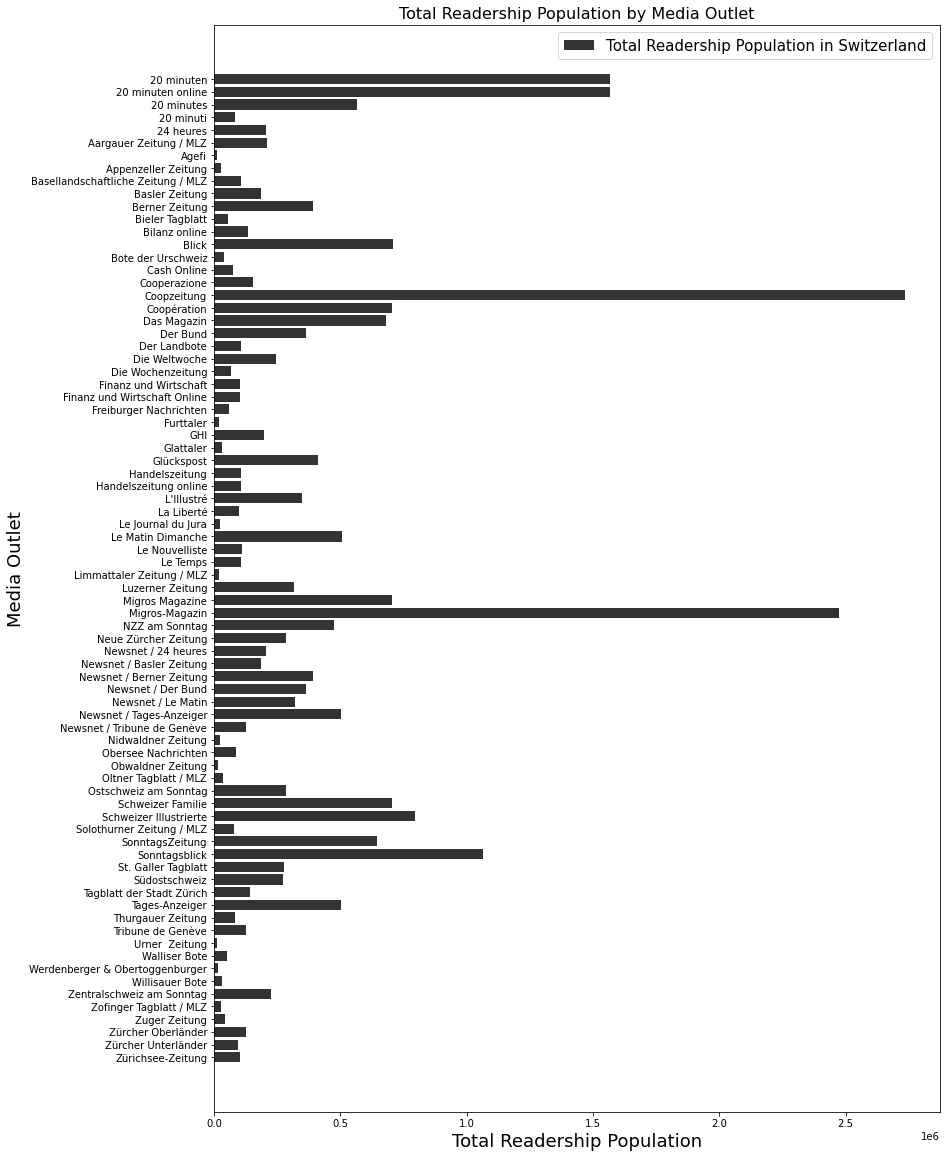

In [109]:
# Plot the total Readership for each News Channel for which the readership data is available
plt.rc('legend', fontsize = 15)
fig = plt.figure(figsize = (13,20))
ax = fig.add_subplot(111)
y_pos = np.arange(readership_new.shape[0])
ax.barh(y_pos, readership_new['tot_readers_population'].values, align = 'center', color = 'black', alpha = 0.8, label = 'Total Readership Population in Switzerland')
ax.set_yticks(y_pos)
ax.set_yticklabels(readership_new['source_long'].values)
ax.set_title('Total Readership Population by Media Outlet')
ax.set_ylabel('Media Outlet')
ax.xaxis.label.set_size(18)
ax.set_xlabel('Total Readership Population')
ax.yaxis.label.set_size(18)
ax.invert_yaxis() # to read labels from top-to-bottom
# Display the plot
plt.legend()
plt.show()